## Basics

### Imports

In [52]:
import pandas as pd
import numpy as np
import math
import os
import json

import torch
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, max_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

In [111]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

### Working Directory Path

In [3]:
# Local Path for Running Locally
path = "./data/"
path_images = path + "images/"
path_features = path + "features/"

### Read Data & Features

In [4]:
data = pd.read_csv(path + 'agora12_data_pp.csv')
data

Id  \
0        Agora:Object:Agora XII:1   
1        Agora:Object:Agora XII:2   
2        Agora:Object:Agora XII:3   
3        Agora:Object:Agora XII:4   
4        Agora:Object:Agora XII:5   
...                           ...   
1995  Agora:Object:Agora XII:2036   
1996  Agora:Object:Agora XII:2037   
1997  Agora:Object:Agora XII:2038   
1998  Agora:Object:Agora XII:2039   
1999  Agora:Object:Agora XII:2040   

                                               FullText  \
0     foot missing. offset neck and echinoid mouth; ...   
1     spreading ring foot with torus outer and conve...   
2     flaring ring foot. torus mouth. ridge at junct...   
3     ring foot. echinoid mouth inset from neck and ...   
4     echinus ring foot. torus mouth; strap handles....   
...                                                 ...   
1995  fragment of rim and floor with handle. deep ba...   
1996  handles missing. basin and lid; handles probab...   
1997  small series. plain flat-topped rim; flaring b...   
1998  small series. rim flat on top, roughly moulded...   
1999  stand and floor fragment. lower edge of stand ...   

                     ImageFilename  StartYear  EndYear  MidpointYear  \
0     Agora_Image_2012.54.1450.jpg     -575.0   -550.0        -562.5   
1                              NaN     -525.0   -500.0        -512.5   
2                              NaN     -500.0   -500.0        -500.0   
3                              NaN     -500.0   -500.0        -500.0   
4     Agora_Image_2012.27.0009.jpg     -525.0   -500.0        -512.5   
...                            ...        ...      ...           ...   
1995                           NaN     -350.0   -320.0        -335.0   
1996  Agora_Image_2012.55.1261.jpg     -350.0   -301.0        -325.5   
1997  Agora_Image_2012.25.0184.jpg     -435.0   -425.0        -430.0   
1998  Agora_Image_2012.55.1268.jpg     -375.0   -325.0        -350.0   
1999                           NaN     -400.0   -300.0        -350.0   

      YearRange HistoricalPeriod  ValidChronology  
0          25.0          Archaic             True  
1          25.0          Archaic             True  
2           0.0          Archaic             True  
3           0.0          Archaic             True  
4          25.0          Archaic             True  
...         ...              ...              ...  
1995       30.0        Classical             True  
1996       49.0        Classical             True  
1997       10.0        Classical             True  
1998       50.0        Classical             True  
1999      100.0        Classical            False  

[2000 rows x 9 columns]

In [5]:
f_types = {
    "vectors": ("csv", pd.read_csv, {}),
    "tensors": ("pt", torch.load, {"weights_only": True})
}
d_types_methods = {
    "text": ("tfidf", "bert"),
    "image": ("cannyhog", "resnet", "vit")
}

In [6]:
features = {ft: {} for ft in f_types}
for feature_type, (ext, loader, params) in f_types.items():
    for data_type, methods in d_types_methods.items():
        for method in methods:
            filename = f"{data_type}_{method}_{feature_type}.{ext}"
            file_path = os.path.join(path_features, filename)
            if os.path.exists(file_path):
                features[feature_type][method] = loader(file_path, **params)
                print(f"Loaded {filename}")

Loaded text_tfidf_vectors.csv
Loaded text_bert_vectors.csv
Loaded image_cannyhog_vectors.csv
Loaded image_resnet_vectors.csv
Loaded image_vit_vectors.csv
Loaded text_bert_tensors.pt
Loaded image_resnet_tensors.pt
Loaded image_vit_tensors.pt


In [7]:
for method in features["vectors"]:
    print(f"\nfeatures[\"vectors\"][\"{method}\"] = ")
    print(features["vectors"][method].info())


features["vectors"]["tfidf"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 300 entries, F0 to F299
dtypes: float64(300)
memory usage: 4.6 MB
None

features["vectors"]["bert"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 768 entries, F0 to F767
dtypes: float64(768)
memory usage: 11.7 MB
None

features["vectors"]["cannyhog"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2917 entries, F0 to F2916
dtypes: float64(2917)
memory usage: 44.5 MB
None

features["vectors"]["resnet"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2048 entries, F0 to F2047
dtypes: float64(2048)
memory usage: 31.3 MB
None

features["vectors"]["vit"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 768 entries, F0 to F767
dtypes: float64(768)
memory usage: 11.7 MB
None


In [8]:
for method in features["tensors"]:
    if method in features["tensors"]:
        print(f"\nfeatures[\"tensors\"][\"{method}\"] = ")
        tensor = features["tensors"][method]
        print(
            f"Dimensions: {tensor.ndim}\nShape: {tensor.shape}\ndtype: {tensor.dtype}\nMemory usage: {(tensor.element_size() * tensor.numel()) / (1024 * 1024)} MB")


features["tensors"]["bert"] = 
Dimensions: 2
Shape: torch.Size([2000, 768])
dtype: torch.float32
Memory usage: 5.859375 MB

features["tensors"]["resnet"] = 
Dimensions: 2
Shape: torch.Size([2000, 2048])
dtype: torch.float32
Memory usage: 15.625 MB

features["tensors"]["vit"] = 
Dimensions: 2
Shape: torch.Size([2000, 768])
dtype: torch.float32
Memory usage: 5.859375 MB


### Evaluation Metrics Table

In [9]:
metrics = [
    "mae",
    "rmse",
    "r2",
    "medae",
    "maxerror"
]

cv_scores = pd.DataFrame(columns=["model", "target", "features"] + metrics)

### Drop Records with Non-Valid Chronology (Null or Range > 50)

In [10]:
valid_mask = data["ValidChronology"]

In [11]:
data = data.loc[valid_mask].reset_index(drop=True)
data

Id  \
0        Agora:Object:Agora XII:1   
1        Agora:Object:Agora XII:2   
2        Agora:Object:Agora XII:3   
3        Agora:Object:Agora XII:4   
4        Agora:Object:Agora XII:5   
...                           ...   
1905  Agora:Object:Agora XII:2035   
1906  Agora:Object:Agora XII:2036   
1907  Agora:Object:Agora XII:2037   
1908  Agora:Object:Agora XII:2038   
1909  Agora:Object:Agora XII:2039   

                                               FullText  \
0     foot missing. offset neck and echinoid mouth; ...   
1     spreading ring foot with torus outer and conve...   
2     flaring ring foot. torus mouth. ridge at junct...   
3     ring foot. echinoid mouth inset from neck and ...   
4     echinus ring foot. torus mouth; strap handles....   
...                                                 ...   
1905  fragments from two closely similar examples; c...   
1906  fragment of rim and floor with handle. deep ba...   
1907  handles missing. basin and lid; handles probab...   
1908  small series. plain flat-topped rim; flaring b...   
1909  small series. rim flat on top, roughly moulded...   

                     ImageFilename  StartYear  EndYear  MidpointYear  \
0     Agora_Image_2012.54.1450.jpg     -575.0   -550.0        -562.5   
1                              NaN     -525.0   -500.0        -512.5   
2                              NaN     -500.0   -500.0        -500.0   
3                              NaN     -500.0   -500.0        -500.0   
4     Agora_Image_2012.27.0009.jpg     -525.0   -500.0        -512.5   
...                            ...        ...      ...           ...   
1905  Agora_Image_2012.56.0490.jpg     -375.0   -325.0        -350.0   
1906                           NaN     -350.0   -320.0        -335.0   
1907  Agora_Image_2012.55.1261.jpg     -350.0   -301.0        -325.5   
1908  Agora_Image_2012.25.0184.jpg     -435.0   -425.0        -430.0   
1909  Agora_Image_2012.55.1268.jpg     -375.0   -325.0        -350.0   

      YearRange HistoricalPeriod  ValidChronology  
0          25.0          Archaic             True  
1          25.0          Archaic             True  
2           0.0          Archaic             True  
3           0.0          Archaic             True  
4          25.0          Archaic             True  
...         ...              ...              ...  
1905       50.0        Classical             True  
1906       30.0        Classical             True  
1907       49.0        Classical             True  
1908       10.0        Classical             True  
1909       50.0        Classical             True  

[1910 rows x 9 columns]

In [12]:
for method in features["vectors"]:
    features["vectors"][method] = features["vectors"][method].loc[valid_mask].reset_index(drop=True)

    print(f"\nfeatures[\"vectors\"][\"{method}\"] = ")
    print(features["vectors"][method].info())


features["vectors"]["tfidf"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 300 entries, F0 to F299
dtypes: float64(300)
memory usage: 4.4 MB
None

features["vectors"]["bert"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 768 entries, F0 to F767
dtypes: float64(768)
memory usage: 11.2 MB
None

features["vectors"]["cannyhog"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 2917 entries, F0 to F2916
dtypes: float64(2917)
memory usage: 42.5 MB
None

features["vectors"]["resnet"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 2048 entries, F0 to F2047
dtypes: float64(2048)
memory usage: 29.8 MB
None

features["vectors"]["vit"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 768 entries, F0 to F767
dtypes: float64(768)
memory usage: 11.2 MB
None


In [13]:
for method, tensor in features["tensors"].items():
    features["tensors"][method] = tensor[valid_mask.values]  # convert mask to numpy

    print(f"\nfeatures[\"tensors\"][\"{method}\"] = ")
    tensor = features["tensors"][method]
    print(
        f"Dimensions: {tensor.ndim}\nShape: {tensor.shape}\ndtype: {tensor.dtype}\nMemory usage: {(tensor.element_size() * tensor.numel()) / (1024 * 1024)} MB")


features["tensors"]["bert"] = 
Dimensions: 2
Shape: torch.Size([1910, 768])
dtype: torch.float32
Memory usage: 5.595703125 MB

features["tensors"]["resnet"] = 
Dimensions: 2
Shape: torch.Size([1910, 2048])
dtype: torch.float32
Memory usage: 14.921875 MB

features["tensors"]["vit"] = 
Dimensions: 2
Shape: torch.Size([1910, 768])
dtype: torch.float32
Memory usage: 5.595703125 MB


## Target

In [14]:
target_cols = ["StartYear", "YearRange"]  #, "EndYear", "MidpointYear"
target = data[target_cols]
target

StartYear  YearRange
0        -575.0       25.0
1        -525.0       25.0
2        -500.0        0.0
3        -500.0        0.0
4        -525.0       25.0
...         ...        ...
1905     -375.0       50.0
1906     -350.0       30.0
1907     -350.0       49.0
1908     -435.0       10.0
1909     -375.0       50.0

[1910 rows x 2 columns]

## Split Train & Test Sets

In [15]:
indices = np.arange(data.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=42)

In [16]:
X = {
    "train": {method: vectors.loc[train_idx] for method, vectors in features["vectors"].items()},
    "test": {method: vectors.loc[test_idx] for method, vectors in features["vectors"].items()}
}

In [17]:
X

{'train': {'tfidf':        F0        F1        F2   F3        F4        F5   F6   F7   F8  \
  1455  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  482   0.0  0.139391  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  772   0.0  0.000000  0.000000  0.0  0.000000  0.133552  0.0  0.0  0.0   
  1192  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  1007  0.0  0.000000  0.202137  0.0  0.000000  0.000000  0.0  0.0  0.0   
  ...   ...       ...       ...  ...       ...       ...  ...  ...  ...   
  1130  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  1294  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  860   0.0  0.160136  0.000000  0.0  0.170923  0.143958  0.0  0.0  0.0   
  1459  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  1126  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  
              F9  ...  F290  F291  F292  F293  F294  F295  F296      F297  \
  

In [18]:
y = {
    "train": target.loc[train_idx],
    "test": target.loc[test_idx]
}

In [19]:
y

{'train':       StartYear  YearRange
 1455     -425.0       25.0
 482      -430.0        0.0
 772      -410.0        0.0
 1192     -550.0        0.0
 1007     -425.0       25.0
 ...         ...        ...
 1130     -400.0        0.0
 1294     -500.0        0.0
 860      -375.0       25.0
 1459     -520.0       40.0
 1126     -420.0       20.0
 
 [1719 rows x 2 columns],
 'test':       StartYear  YearRange
 1228     -525.0        0.0
 111      -425.0       25.0
 1843     -375.0       25.0
 1324     -600.0       25.0
 415      -500.0       25.0
 ...         ...        ...
 420      -500.0       25.0
 903      -500.0       20.0
 173      -500.0       20.0
 1606     -375.0       50.0
 1206     -350.0       25.0
 
 [191 rows x 2 columns]}

## Feature Standardization

In [20]:
X_std = {
    "train": {},
    "test": {}
}
for method, xtrain in X["train"].items():
    xtest = X["test"][method]
    scaler = StandardScaler()
    X_std["train"][method] = pd.DataFrame(scaler.fit_transform(xtrain), columns=xtrain.columns, index=xtrain.index)
    X_std["test"][method] = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns, index=xtest.index)

In [21]:
X_std

{'train': {'tfidf':             F0        F1        F2        F3        F4        F5        F6  \
  1455 -0.181848 -0.199051 -0.241043 -0.226923 -0.161691 -0.246069 -0.163713   
  482  -0.181848  3.406195 -0.241043 -0.226923 -0.161691 -0.246069 -0.163713   
  772  -0.181848 -0.199051 -0.241043 -0.226923 -0.161691  2.725789 -0.163713   
  1192 -0.181848 -0.199051 -0.241043 -0.226923 -0.161691 -0.246069 -0.163713   
  1007 -0.181848 -0.199051  4.215477 -0.226923 -0.161691 -0.246069 -0.163713   
  ...        ...       ...       ...       ...       ...       ...       ...   
  1130 -0.181848 -0.199051 -0.241043 -0.226923 -0.161691 -0.246069 -0.163713   
  1294 -0.181848 -0.199051 -0.241043 -0.226923 -0.161691 -0.246069 -0.163713   
  860  -0.181848  3.942727 -0.241043 -0.226923  4.864142  2.957349 -0.163713   
  1459 -0.181848 -0.199051 -0.241043 -0.226923 -0.161691 -0.246069 -0.163713   
  1126 -0.181848 -0.199051 -0.241043 -0.226923 -0.161691 -0.246069 -0.163713   
  
              F7   

## Combine Features Function

In [178]:
# def combine_features(X, subset, feature_methods):
#     return pd.concat([X[subset][method] for method in feature_methods], axis=1)

def combine_features(X, subset, feature_methods):
    col_offset = 0
    dfs = []
    for method in feature_methods:
        df = X[subset][method]
        n = df.shape[1]
        df.columns = [f"F{i}" for i in range(col_offset, col_offset + n)]
        col_offset += n
        dfs.append(df)
    return pd.concat(dfs, axis=1)

#
# def combine_features(X, subset, feature_methods):
#     dfs = []
#     for method in feature_methods:
#         df = X[subset][method]
#
#         # If tensor, convert to DataFrame
#         if isinstance(df, torch.Tensor):
#             df = pd.DataFrame(df.cpu().numpy())
#
#         # If Series (e.g. a vector column), expand it
#         if isinstance(df, pd.Series):
#             # Check if each value is a list/array
#             if isinstance(df.iloc[0], (list, np.ndarray)):
#                 df = pd.DataFrame(df.tolist(), index=df.index)
#             else:
#                 df = df.to_frame()
#
#         # Confirm it's a DataFrame and numeric
#         assert isinstance(df, pd.DataFrame)
#         assert all(np.issubdtype(dt, np.number) for dt in df.dtypes), f"{method} has non-numeric columns"
#
#         dfs.append(df)
#
#     combined = pd.concat(dfs, axis=1)
#
#     # Final sanity check
#     if combined.select_dtypes(include='object').shape[1] > 0:
#         raise ValueError("Combined features contain non-numeric columns.")
#
#     print(combined.shape)
#     print(combined.dtypes.value_counts())
#     print(combined.head(1).applymap(type))  # Shows if any columns are entire arrays or Series
#
#     return combined
#


## 10-Fold Cross Validation

In [23]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(y["train"].shape[0])))

In [175]:
def cross_validation(model, X, y):
    scores = {metric: [] for metric in metrics}

    convert_to_numpy = isinstance(model, XGBRegressor)

    for train_idx, val_idx in folds:
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if convert_to_numpy:
            X_train = X_train.to_numpy()
            X_val = X_val.to_numpy()
            y_train = y_train.to_numpy()
            y_val = y_val.to_numpy()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        scores["mae"] += [mean_absolute_error(y_val, y_pred)]
        scores["rmse"] += [np.sqrt(mean_squared_error(y_val, y_pred))]
        scores["r2"] += [r2_score(y_val, y_pred)]
        scores["medae"] += [median_absolute_error(y_val, y_pred)]
        scores["maxerror"] += [max_error(y_val, y_pred)]

    scores = {metric: (np.mean(values), values) for metric, values in scores.items()}

    return scores

In [128]:
def run_cv(model_name, model_class, best_params, X, y, method, target, enable_plots=True):
    if best_params:
        if (method, target) not in best_params: return
        model = model_class(**best_params[(method, target)])
    else:
        model = model_class()
    s = cross_validation(model, X, y)
    save_cv_scores(s, model_name, target, method)
    if enable_plots: plot_cv_scores(s, model_name, target, method)

def run_cv_all(model_name, model_class, best_params, X, y, enable_plots=True):
    for target, _y in y["train"].items():
        # Single Feature Sets
        for method, _X in X["train"].items():
            run_cv(model_name, model_class, best_params, _X, _y, method, target, enable_plots)

        # Combined Feature Sets (Text+Image)
        for text_method in d_types_methods["text"]:
            for image_method in d_types_methods["image"]:
                _X = combine_features(X, "train", [text_method, image_method])
                method = f"{text_method} + {image_method}"

                run_cv(model_name, model_class, best_params, _X, _y, method, target, enable_plots)

## Hyperparameter Tuning

In [141]:
def hyperparameter_tuning(model_class, param_grid, X, y, verbose=0):
    param_mae = []
    for params in ParameterGrid(param_grid):
        model = model_class(**params)
        s = cross_validation(model, X, y)
        param_mae += [(params, s["mae"][0])]

    best_params, best_mae = min(param_mae, key=lambda x: x[1])
    if verbose:
        print(f"Best params: {best_params}")
        print(f"Best MAE: {best_mae:.2f}")
    return best_params  #, best_mae

In [181]:
def run_hp_all(model_class, param_grid, X, y, verbose=0):
    model_best_params = {}
    for target, _y in y["train"].items():
        for method, _X in X["train"].items():
            if verbose: print(f"\nFeatures: {method} | Target: {target}")
            model_best_params[(method, target)] = hyperparameter_tuning(model_class, param_grid, _X, _y, verbose)

        for text_method in d_types_methods["text"]:
            for image_method in d_types_methods["image"]:
                _X = combine_features(X, "train", [text_method, image_method])
                method = f"{text_method} + {image_method}"

                if verbose: print(f"\nFeatures: {method} | Target: {target}")
                model_best_params[(method, target)] = hyperparameter_tuning(model_class, param_grid, _X, _y, verbose)

    return model_best_params

### Run Once per Model & Save Best Params

In [182]:
model_param_grids = {
    "Ridge": (
        Ridge, {
            "alpha": [0.01, 0.1, 1, 10, 100, 1000],
            "random_state": [42]
        }
    ),
    "Lasso": (
        Lasso, {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
            "random_state": [42],
            "max_iter": [10000]
        }
    ),
    "RandomForest": (
        RandomForestRegressor, {
            "n_estimators": [100],
            "max_depth": [None, 20],
            "min_samples_split": [2],
            "min_samples_leaf": [1, 2],
            "random_state": [42],
            "n_jobs": [-1]
        }
    ),
    "XGBoost": (
        XGBRegressor,
        {
            "n_estimators": [100],
            "max_depth": [3, 6],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8],
            "colsample_bytree": [0.8],
            "tree_method": ["hist"],
            "device": ["cuda"],
            "random_state": [42]
        }
    ),
    "LightGBM": (
        LGBMRegressor,
        {
            "n_estimators": [100],
            "max_depth": [-1, 20],
            "learning_rate": [0.05, 0.1],
            "num_leaves": [31, 64],
            "device": ["gpu"],
            "random_state": [42],
            "verbose": [-1]
        }
    )
}

Load best_params dictionary from JSON file, if it exists, else initialize dictionary

In [188]:
path_params = "best_params.json"

# Load or initialize
if os.path.exists(path_params):
    with open(path_params, "r") as f:
        best_params = json.load(f)

        # Convert stringified tuples back to tuple keys
        best_params = {
            model: {
                eval(k): v for k, v in param_dict.items()
            } for model, param_dict in best_params.items()
        }
else:
    best_params = {}

In [189]:
best_params

{'Ridge': {('tfidf', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('bert', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('cannyhog', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('resnet', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('vit', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('tfidf + cannyhog', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('tfidf + resnet', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('tfidf + vit', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('bert + cannyhog', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('bert + resnet', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('bert + vit', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('tfidf', 'YearRange'): {'alpha': 1, 'random_state': 42},
  ('bert', 'YearRange'): {'alpha': 100, 'random_state': 42},
  ('cannyhog', 'YearRange'): {'alpha': 100, 'random_state': 42},
  ('resnet', 'YearRange'): {'alpha': 100, 'random_state': 42},
  ('vit', 'YearRange'): {'a

Run tuning only for models missing from the saved params

In [185]:
verbose = True
flag_new_model = False
for model_name, (model_class, param_grid) in model_param_grids.items():

    if model_name not in best_params:
        flag_new_model = True

        if verbose: print(f"\n🎚️ Hyperparameter Tuning '{model_name}' Model")
        best_params[model_name] = run_hp_all(model_class, param_grid, X, y, verbose)
    else:
        if verbose: print(f"\n✅ '{model_name}' Model Already Tuned")



✅ 'Ridge' Model Already Tuned

✅ 'Lasso' Model Already Tuned

✅ 'RandomForest' Model Already Tuned

✅ 'XGBoost' Model Already Tuned

🎚️ Hyperparameter Tuning 'LightGBM' Model

Features: tfidf | Target: StartYear
Best params: {'device': 'gpu', 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 31, 'random_state': 42, 'verbose': -1}
Best MAE: 36.12

Features: bert | Target: StartYear
Best params: {'device': 'gpu', 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 31, 'random_state': 42, 'verbose': -1}
Best MAE: 46.26

Features: cannyhog | Target: StartYear
Best params: {'device': 'gpu', 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 64, 'random_state': 42, 'verbose': -1}
Best MAE: 47.15

Features: resnet | Target: StartYear
Best params: {'device': 'gpu', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'random_state': 42, 'verbose': -1}
Best MAE: 46.95

Features: vit | Target: StartYea

In [186]:
best_params

{'Ridge': {('tfidf', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('bert', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('cannyhog', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('resnet', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('vit', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('tfidf + cannyhog', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('tfidf + resnet', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('tfidf + vit', 'StartYear'): {'alpha': 1, 'random_state': 42},
  ('bert + cannyhog', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('bert + resnet', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('bert + vit', 'StartYear'): {'alpha': 10, 'random_state': 42},
  ('tfidf', 'YearRange'): {'alpha': 1, 'random_state': 42},
  ('bert', 'YearRange'): {'alpha': 100, 'random_state': 42},
  ('cannyhog', 'YearRange'): {'alpha': 100, 'random_state': 42},
  ('resnet', 'YearRange'): {'alpha': 100, 'random_state': 42},
  ('vit', 'YearRange'): {'a

Save best params if new models added

In [187]:
if flag_new_model:
    # Convert tuple keys to strings to make JSON serializable
    serializable_params = {
        model: {
            str(k): v for k, v in param_dict.items()
        } for model, param_dict in best_params.items()
    }

    with open(path_params, "w") as f:
        json.dump(serializable_params, f, indent=2)

    print(f"✅ Saved best parameters to {path_params}")
else:
    print("✅ No new tuning needed — using existing parameters.")

✅ Saved best parameters to ./data/best_params.json


 ## Score Save & Plot Helper Functions

In [34]:
def save_cv_scores(scores, model, target, method):
    mask = (
            (cv_scores["model"] == model) &
            (cv_scores["target"] == target) &
            (cv_scores["features"] == method)
    )
    new_row = [model, target, method] + [scores[m][0] for m in metrics]

    if cv_scores[mask].shape[0] > 0:
        cv_scores.loc[mask, metrics] = new_row[3:]
    else:
        cv_scores.loc[len(cv_scores)] = new_row


In [35]:
def plt_title(model, target, features):
    title = ""
    if model:
        title += f"Model: '{model}'"
        if target or features:
            title += " | "
    if target:
        title += f"Target: '{target}'"
        if features:
            title += " | "
    if features:
        title += f"Features: '{features.upper()}'"
    return title


subplots = [
    {
        'metrics': ["mae", "rmse", "medae"],
        'colors': ['blue', 'green', 'orange'],
        'ylabel': 'Years',
    },
    {
        'metrics': ["r2"],
        'colors': ['purple'],
        'ylabel': 'Score',
        'ylim': 1

    }
]


def plot_cv_scores(scores, model, target, method, cols=2):
    plt.figure(figsize=(14, 5))

    for idx, subplot in enumerate(subplots):
        rows = len(subplots) // cols + (1 if len(subplots) % 2 > 0 else 0)
        plt.subplot(rows, cols, idx + 1)

        min_y = 0
        max_y = 0
        for metric, color in zip(subplot['metrics'], subplot['colors']):
            if metric in scores:
                mean_val, vals = scores[metric]
                plt.plot(range(1, len(vals) + 1), vals, marker='o', label=f"{metric.upper()} per Fold", color=color)
                plt.axhline(mean_val, color=color, alpha=0.8, linestyle='--',
                            label=f"Mean {metric.upper()}: {mean_val:.2f}")

                max_y = max(max_y, max(vals))
                min_y = min(min_y, min(vals))

        plt.axhline(0, color='gray', alpha=0.5, linestyle='--')
        plt.title(', '.join(subplot['metrics']).upper() + " Across Folds", fontsize="12")
        plt.xlabel("Fold")
        plt.ylabel(subplot['ylabel'])
        plt.ylim(min_y * 1.1, subplot['ylim'] if 'ylim' in subplot else max_y * 1.2)
        plt.xticks(range(1, len(vals) + 1))
        plt.legend(ncol=len(subplot['metrics']), fontsize="8")
        plt.grid(True)

    plt.suptitle(plt_title(model, target, method), fontsize="16")
    plt.tight_layout()
    plt.show()
    print("\n")


def plot_compare_feature_scores(cv_scores, model, target, cols=2):
    # Filter for the selected model and target
    df = cv_scores[
        (cv_scores["model"] == model) &
        (cv_scores["target"] == target)
        ].copy()

    plt.figure(figsize=(14, 6))
    x = np.arange(len(df))

    for idx, subplot in enumerate(subplots):
        rows = len(subplots) // cols + (1 if len(subplots) % 2 > 0 else 0)
        plt.subplot(rows, cols, idx + 1)

        bar_width = 0.6 / len(subplot['metrics'])
        offsets = [i - (len(subplot['metrics']) - 1) / 2 for i in range(len(subplot['metrics']))]

        for metric, color, offset in zip(subplot['metrics'], subplot['colors'], offsets):
            plt.bar(x + offset * bar_width, df[metric], width=bar_width, label=metric.upper(), color=color)

        plt.axhline(0, color='gray', alpha=0.5, linestyle='--')
        plt.xticks(ticks=x, labels=df["features"], rotation=45, ha='right')
        plt.ylabel(subplot['ylabel'])
        plt.title(', '.join(subplot['metrics']).upper(), fontsize="12")
        plt.legend()
        plt.grid(True)

    plt.suptitle(plt_title(model, target, ""), fontsize="16")
    plt.tight_layout()
    plt.show()

## Linear Regression

In [91]:
model_name = 'LinearRegression'
model_class = LinearRegression

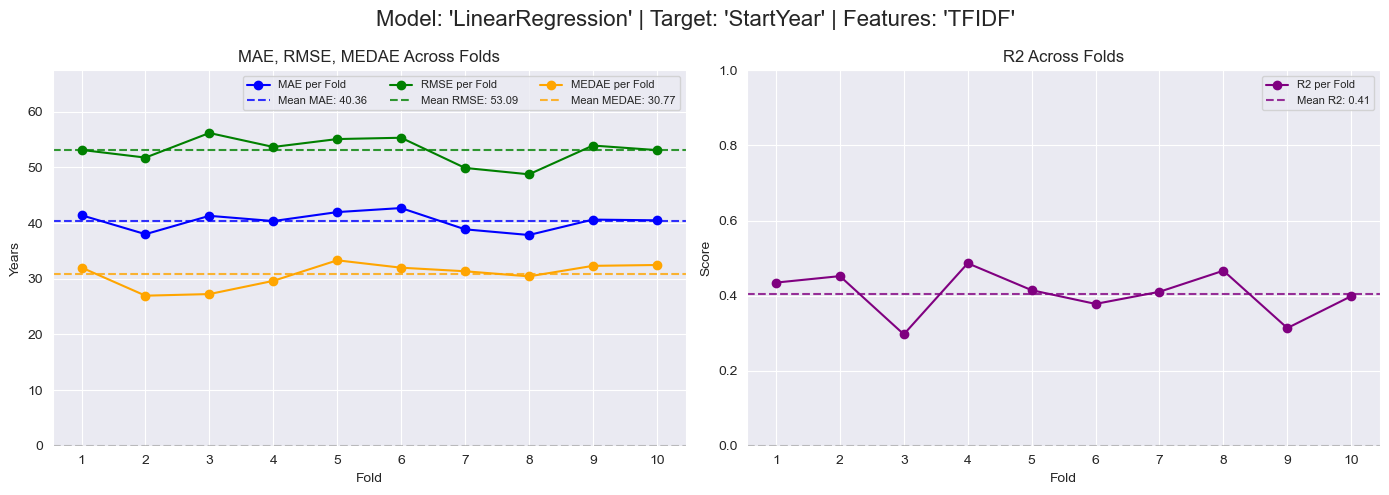

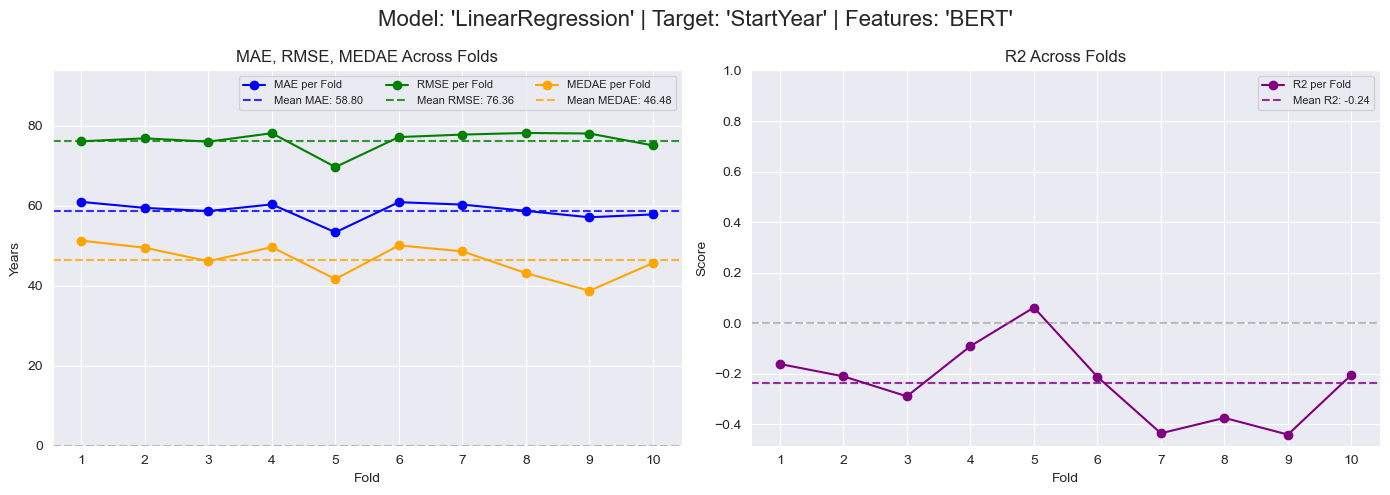

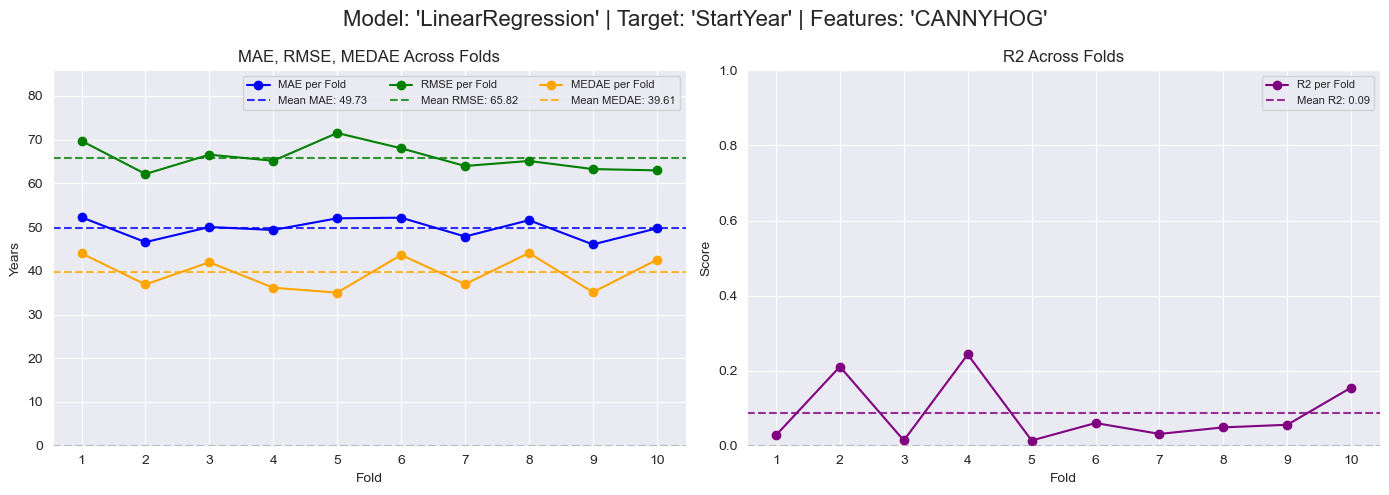

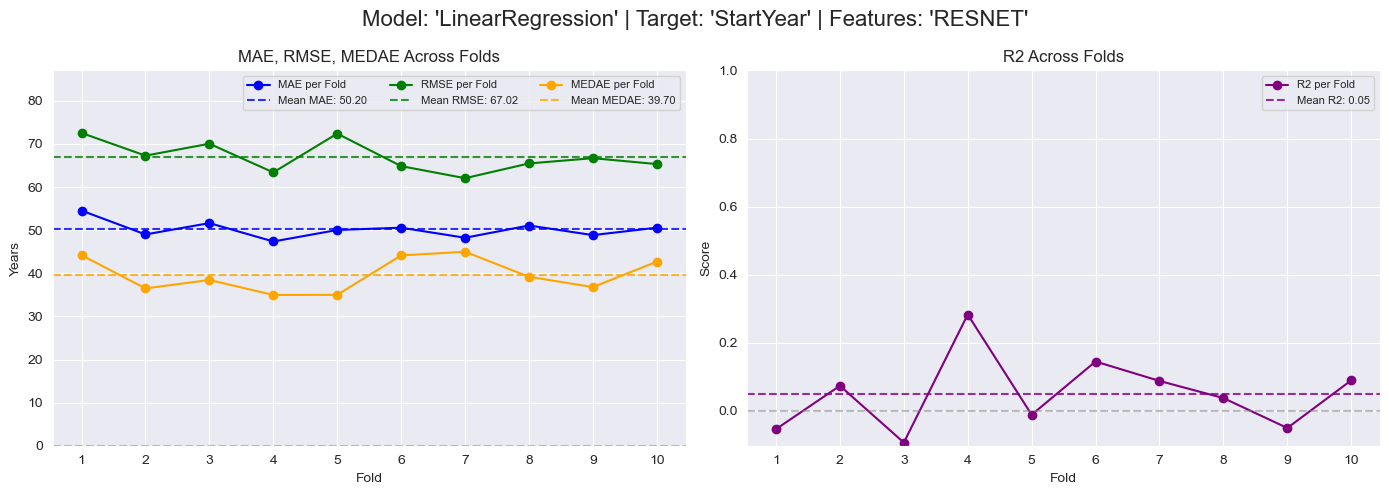

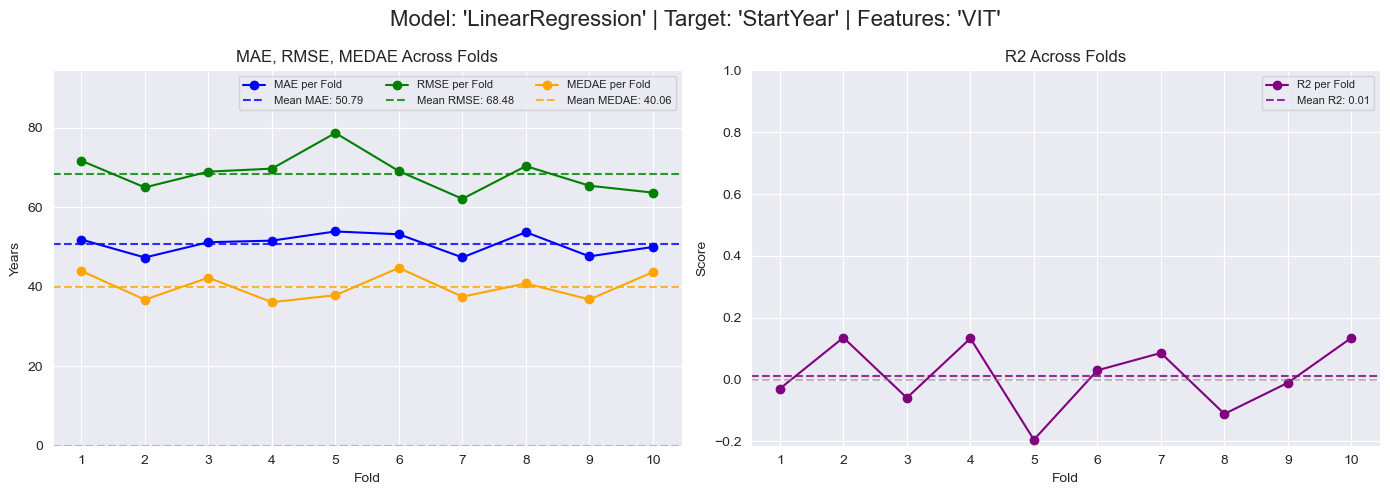

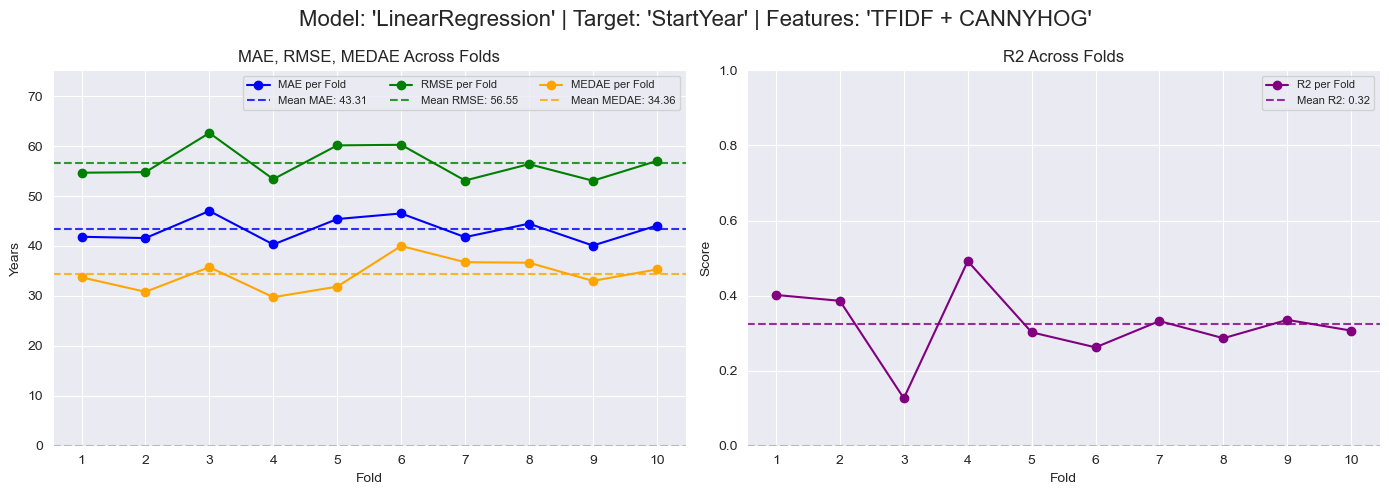

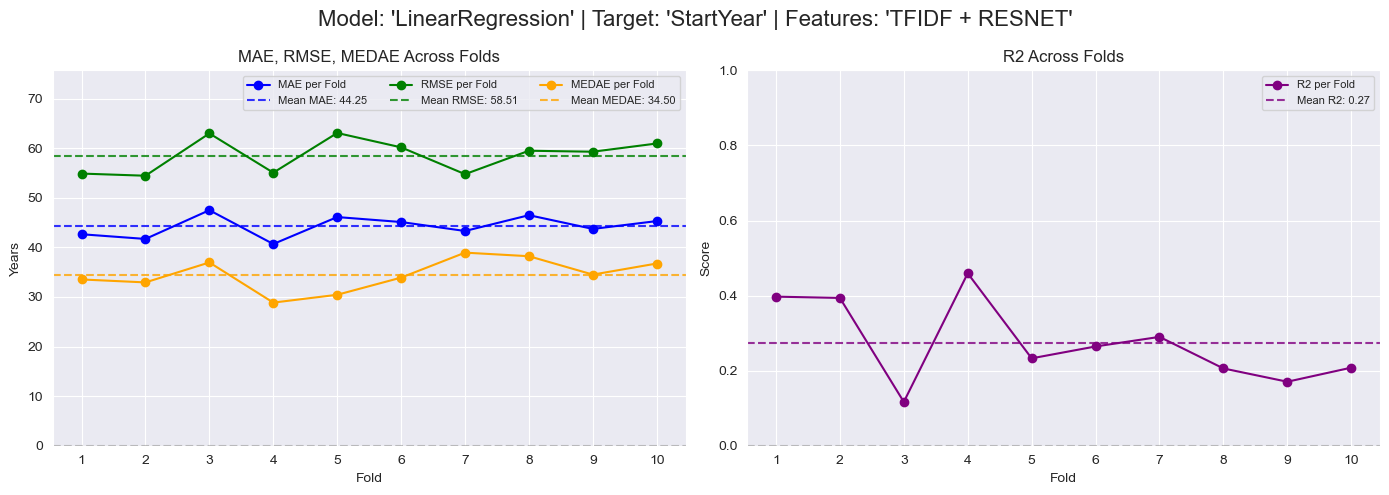

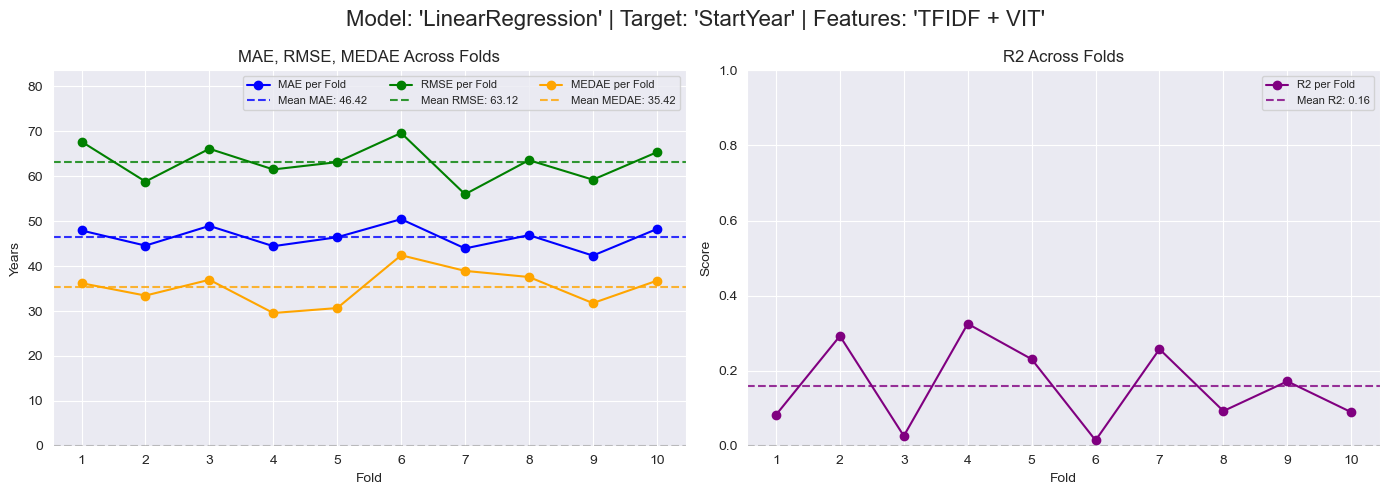

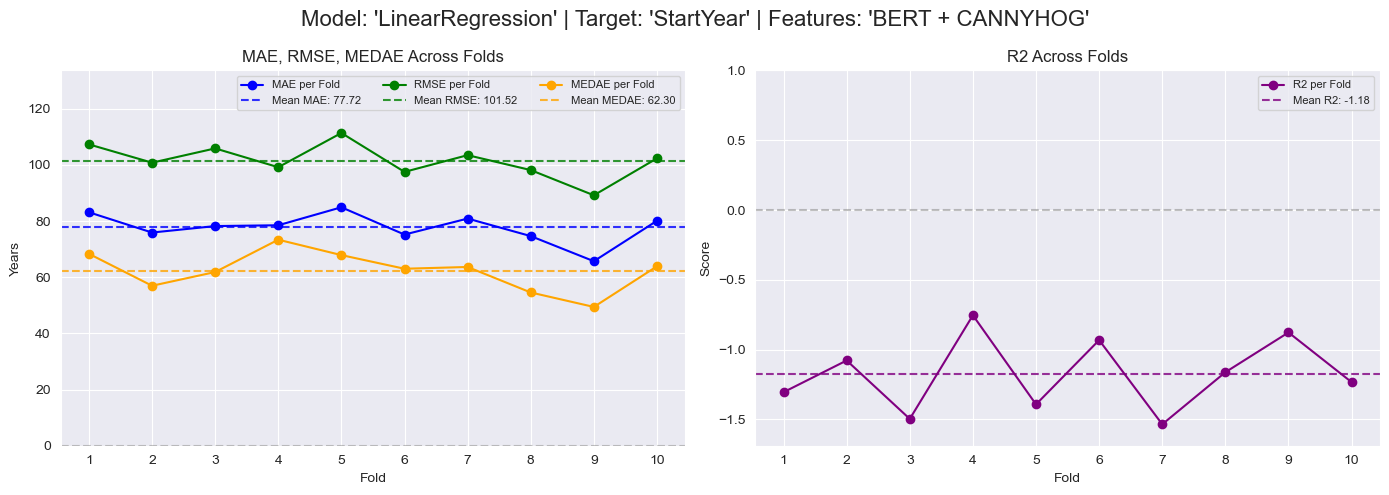

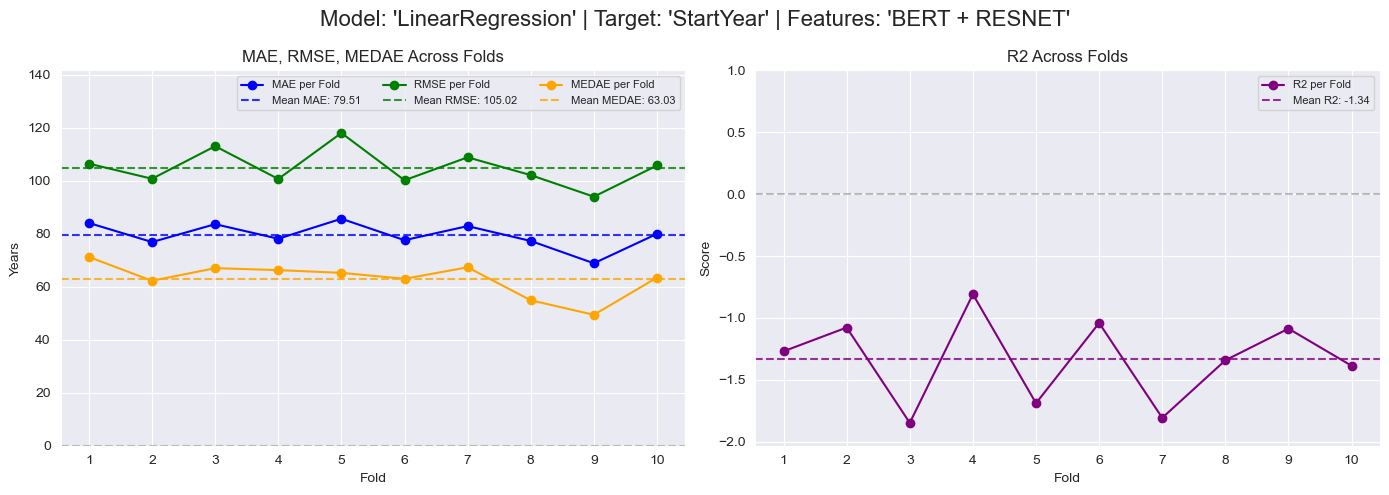

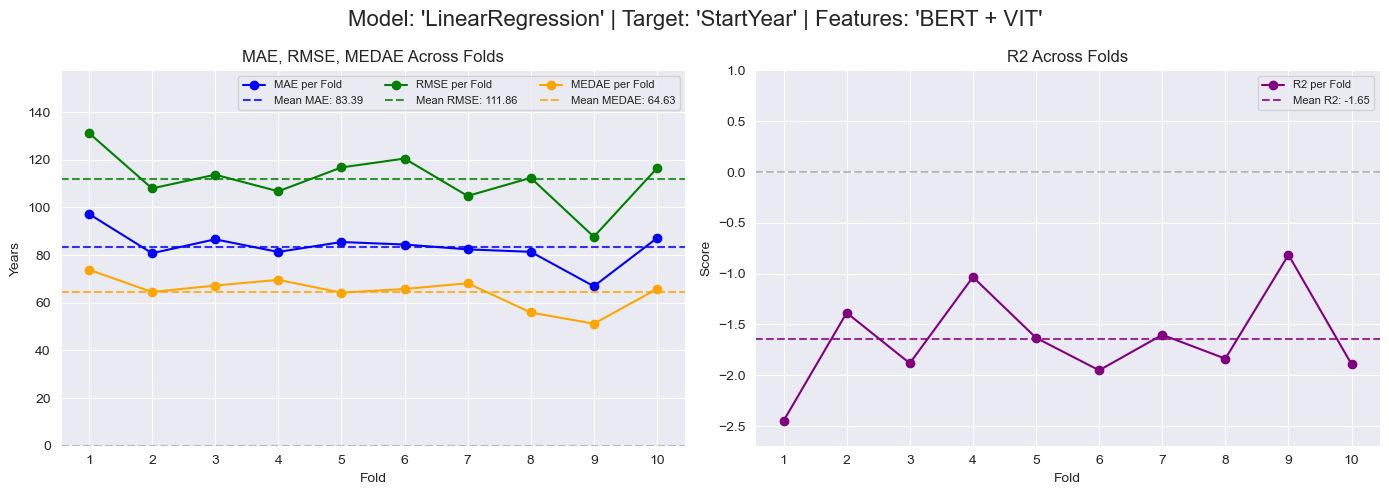

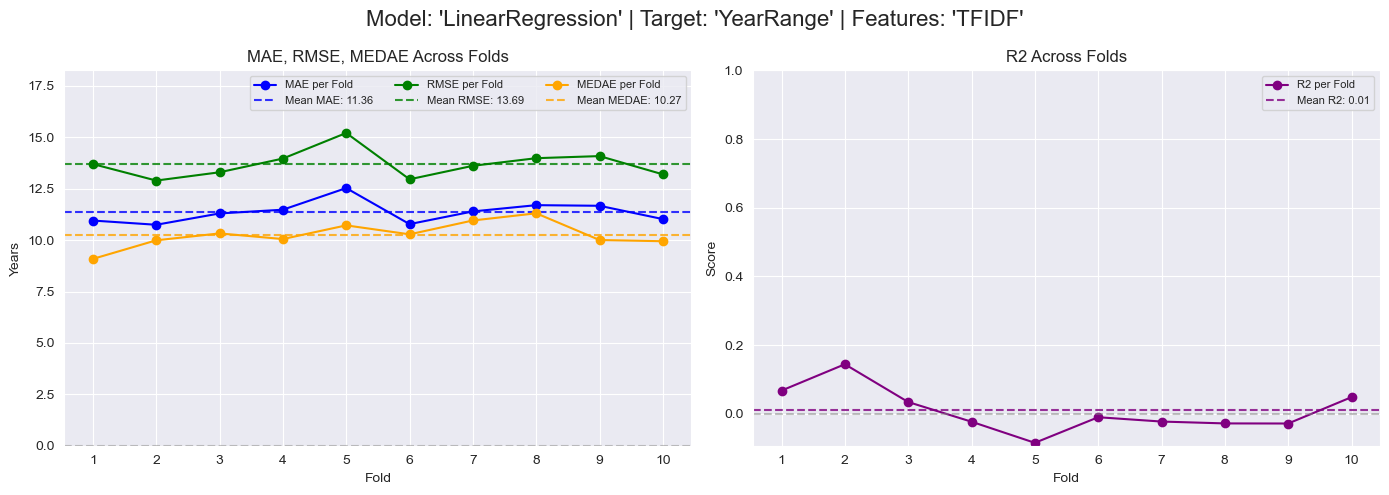

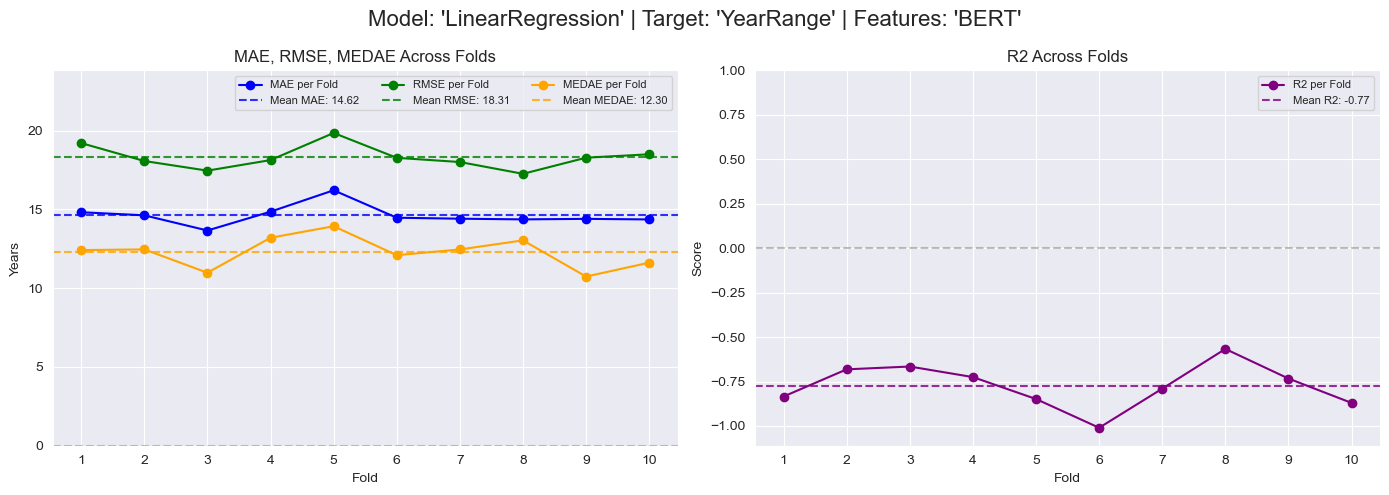

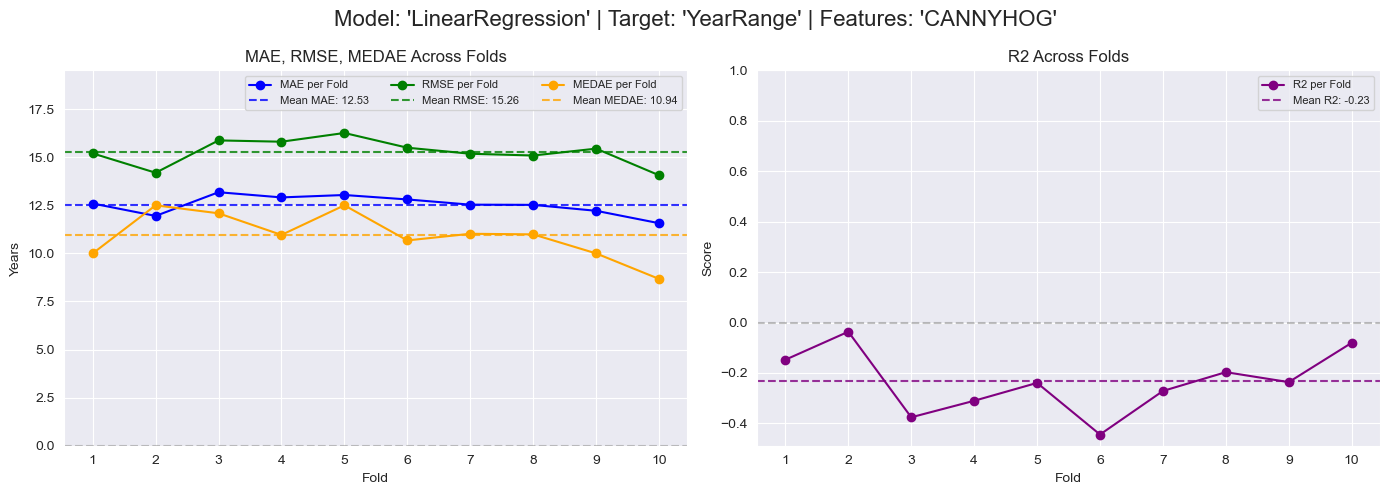

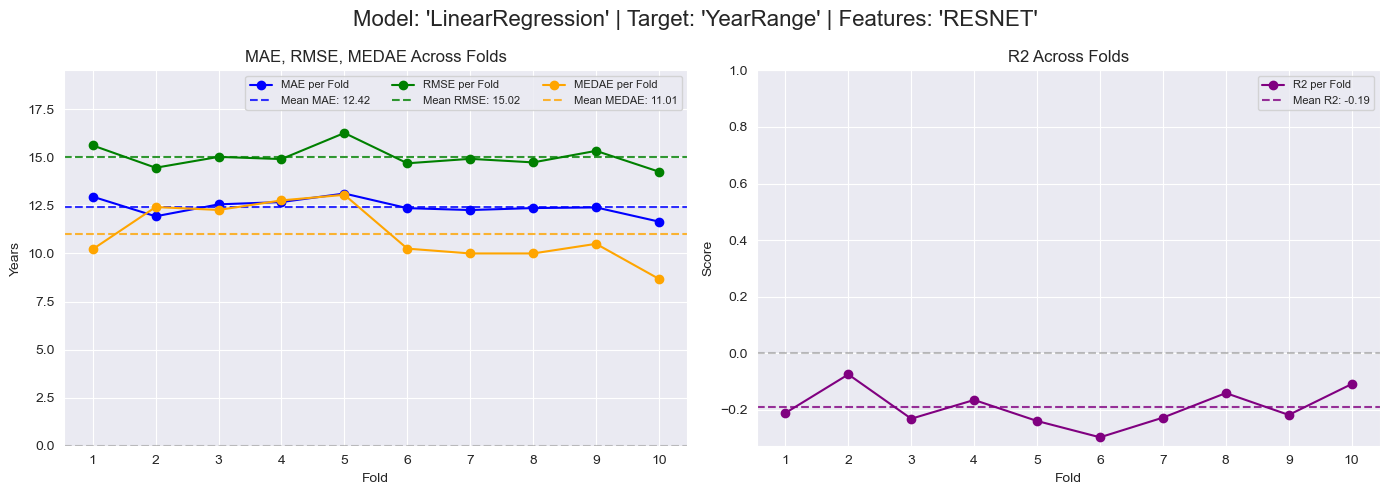

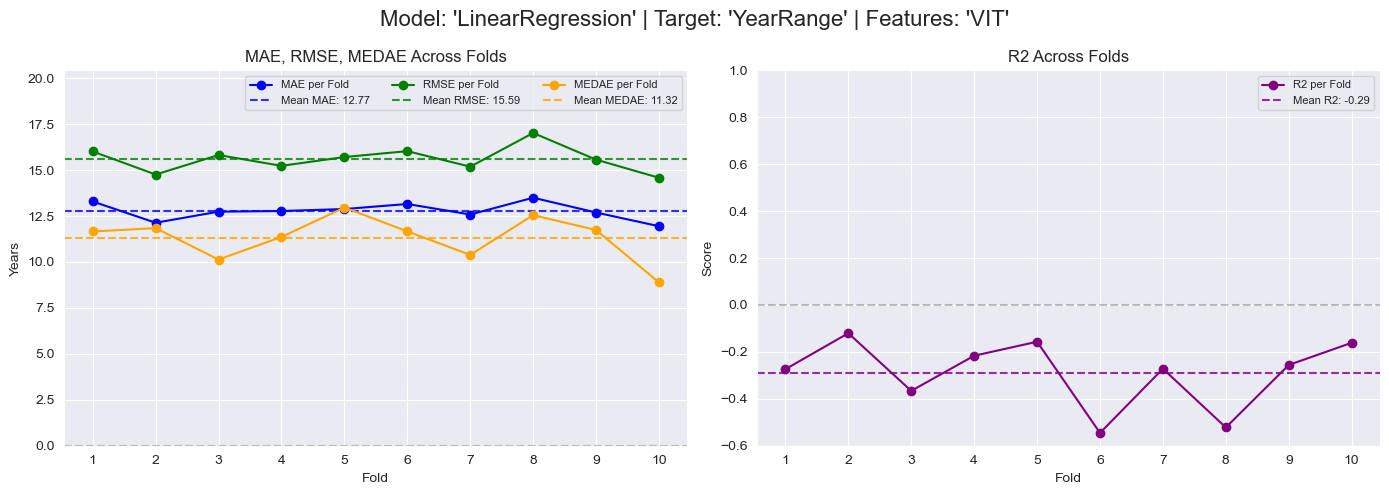

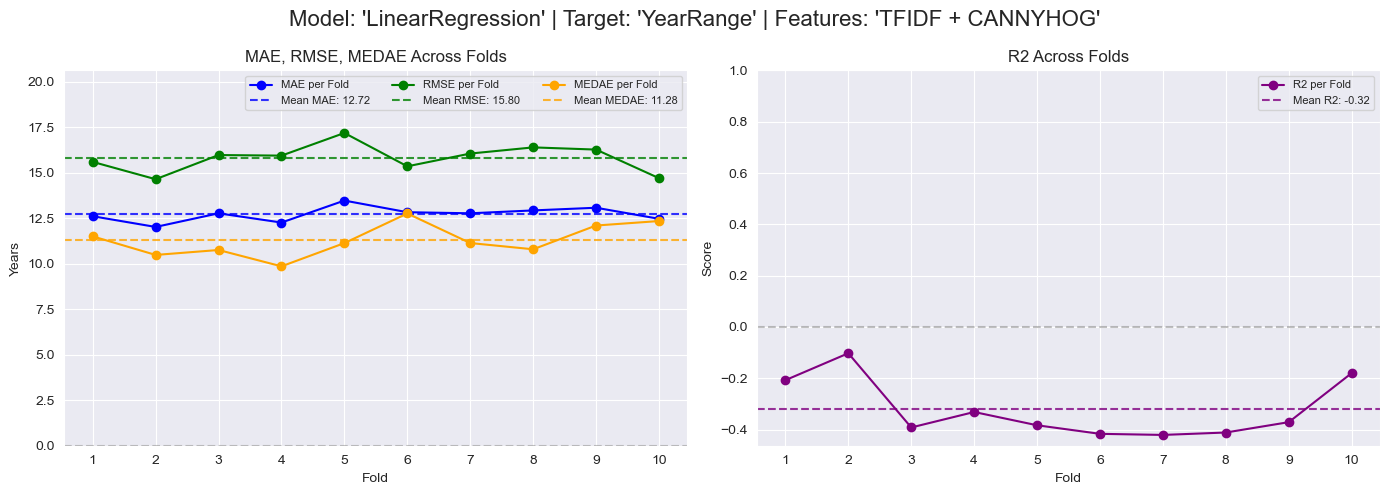

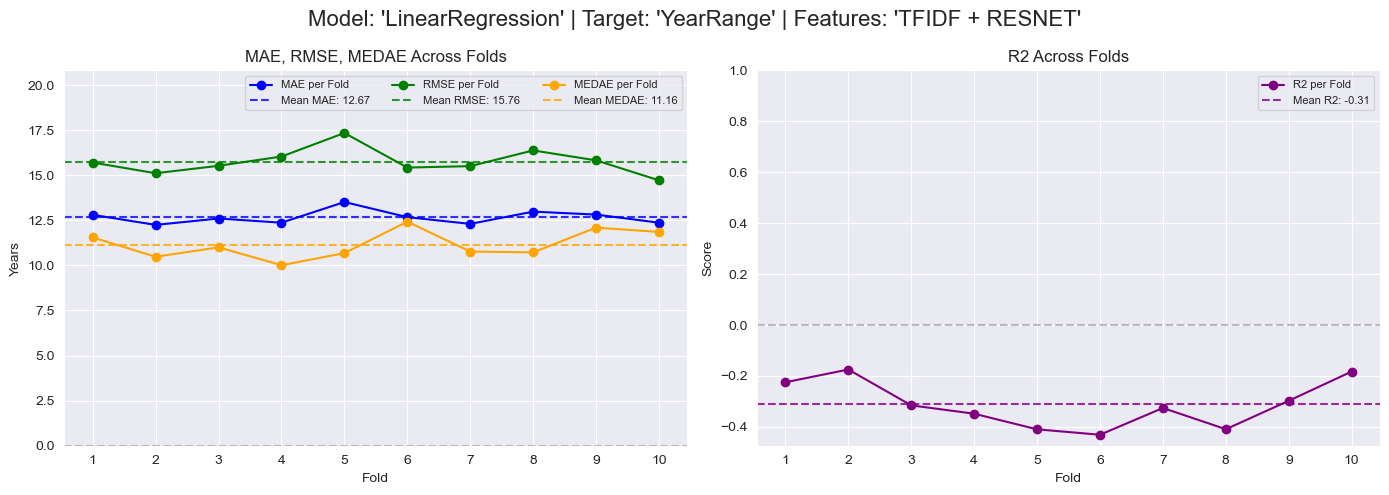

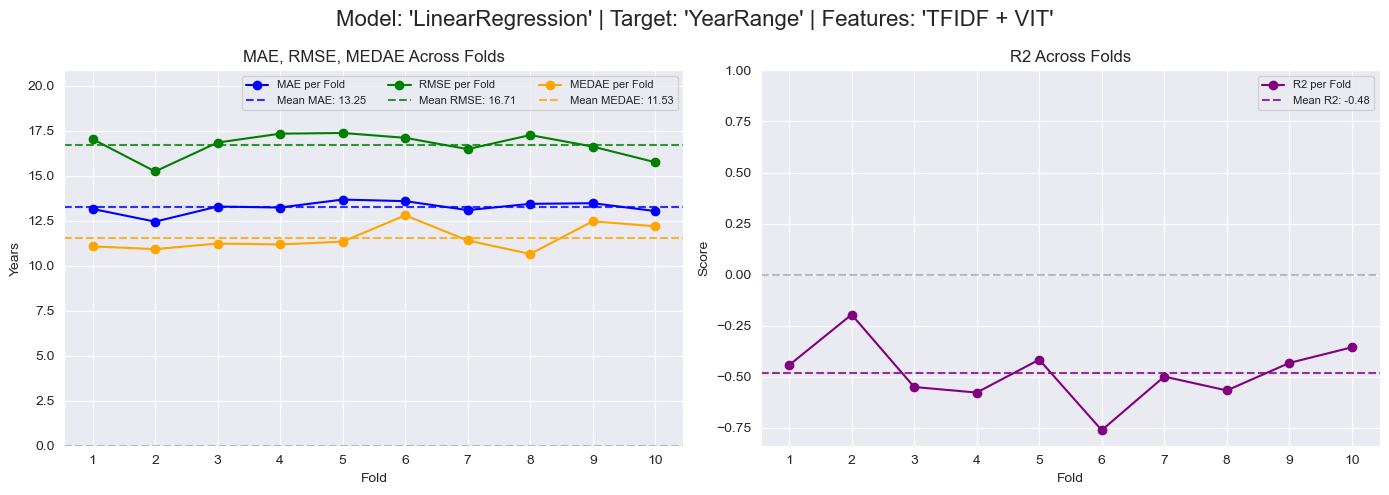

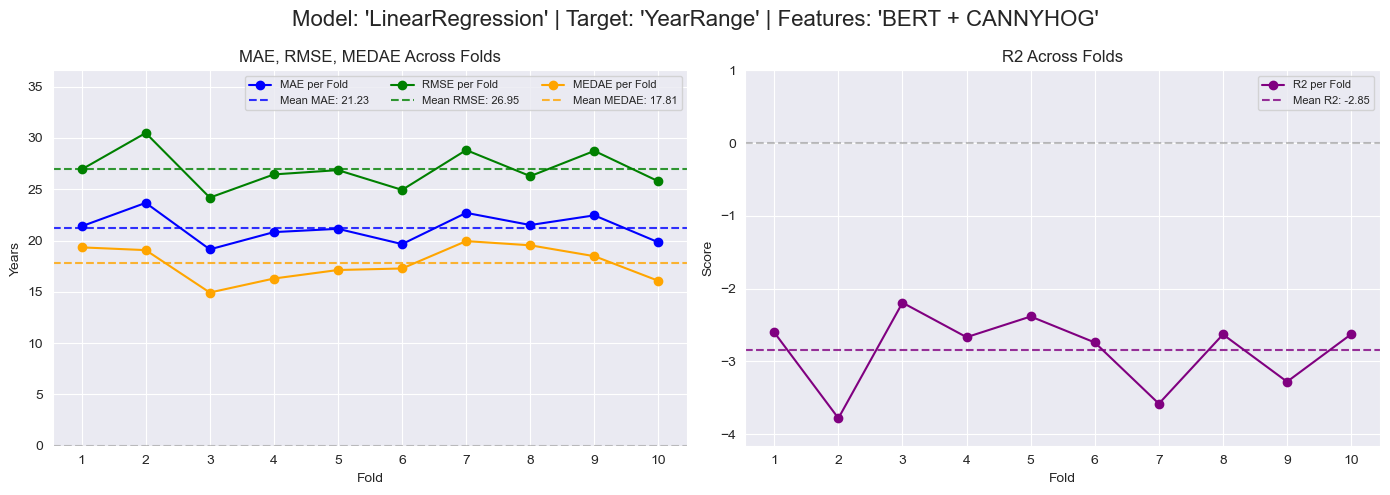

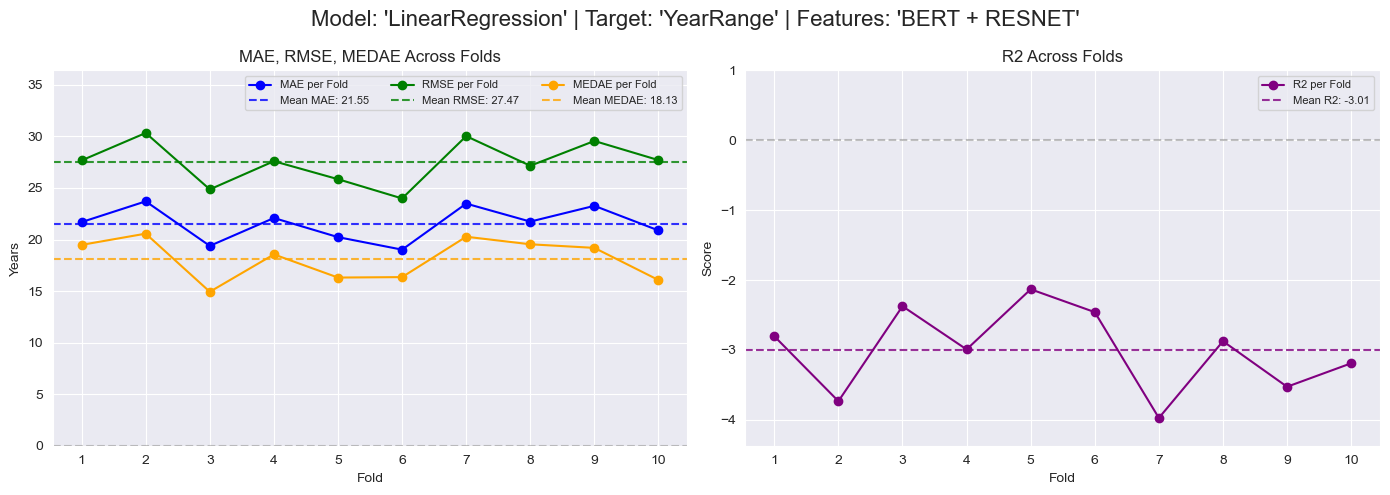

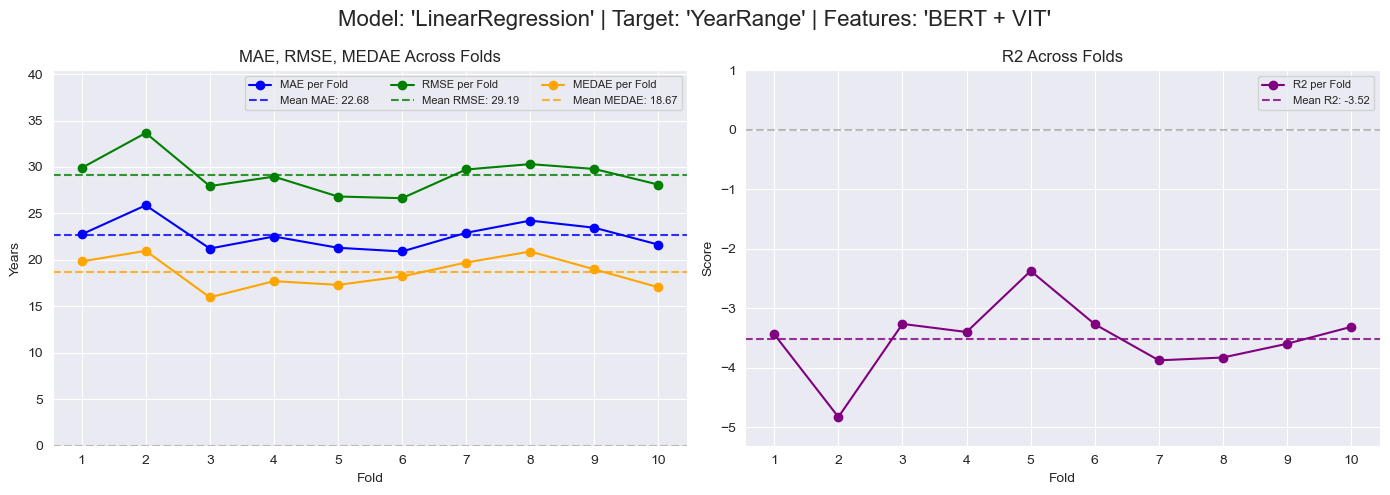

In [92]:
run_cv_all(model_name, model_class, None, X, y)

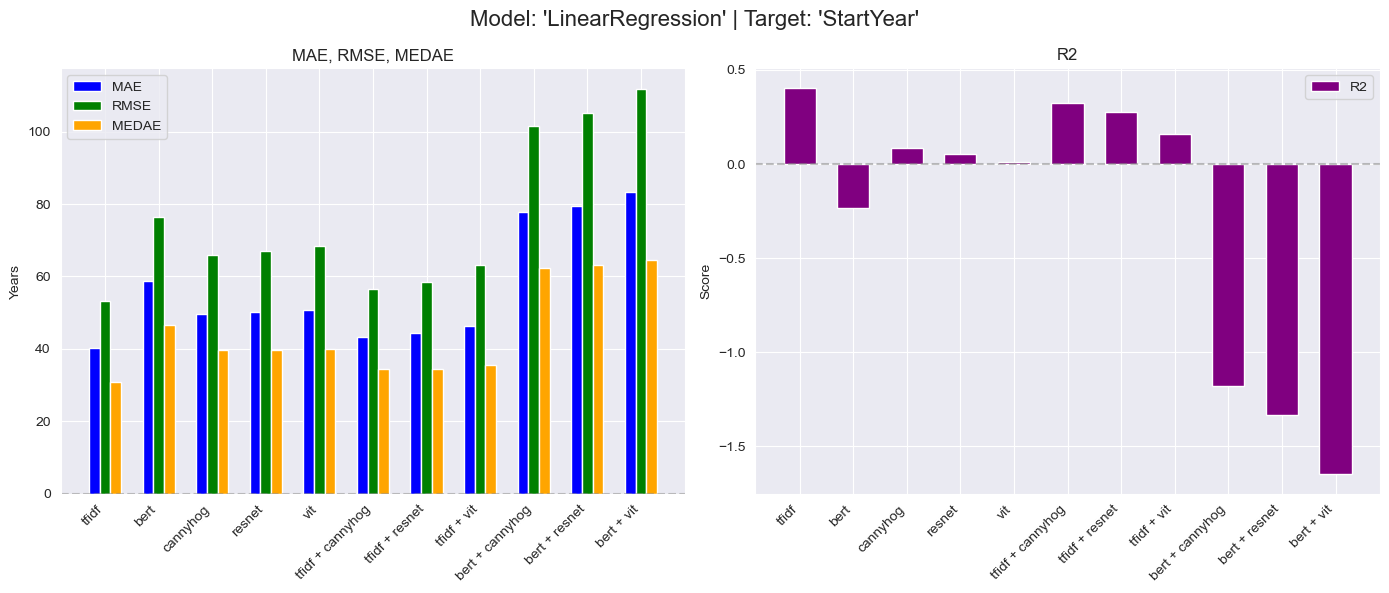

In [93]:
plot_compare_feature_scores(cv_scores, "LinearRegression", "StartYear")

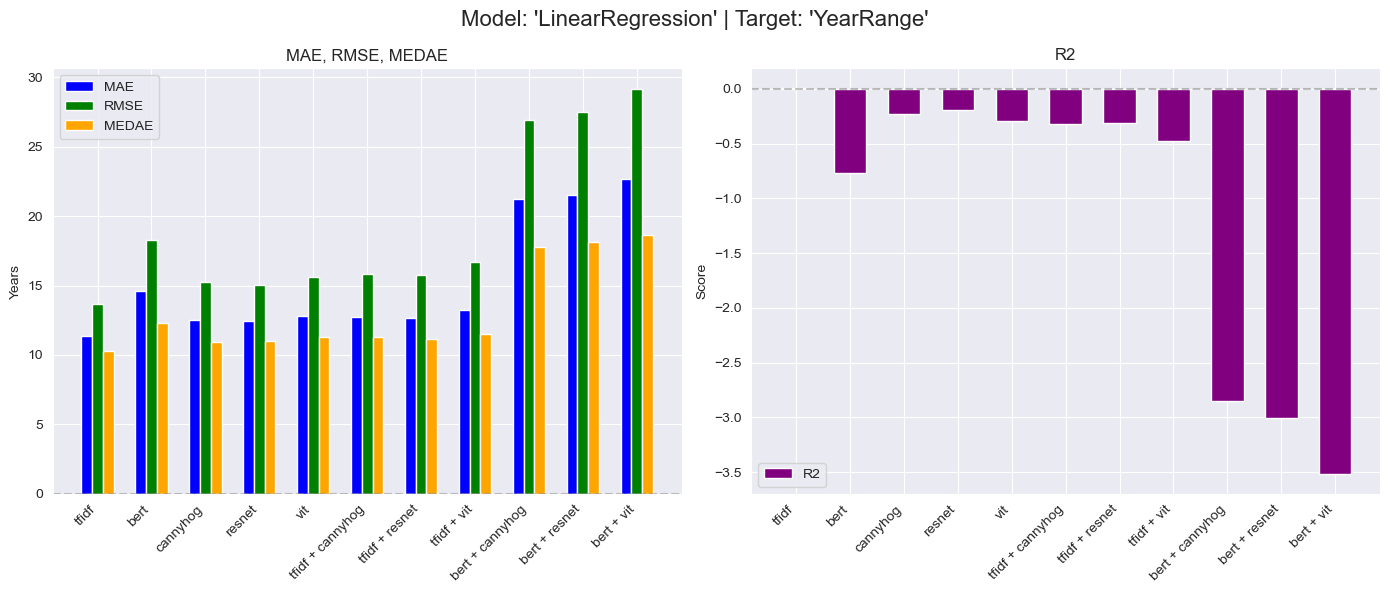

In [95]:
plot_compare_feature_scores(cv_scores, "LinearRegression", "YearRange")

## Ridge Regression

In [96]:
model_name = "Ridge"
model_class = Ridge

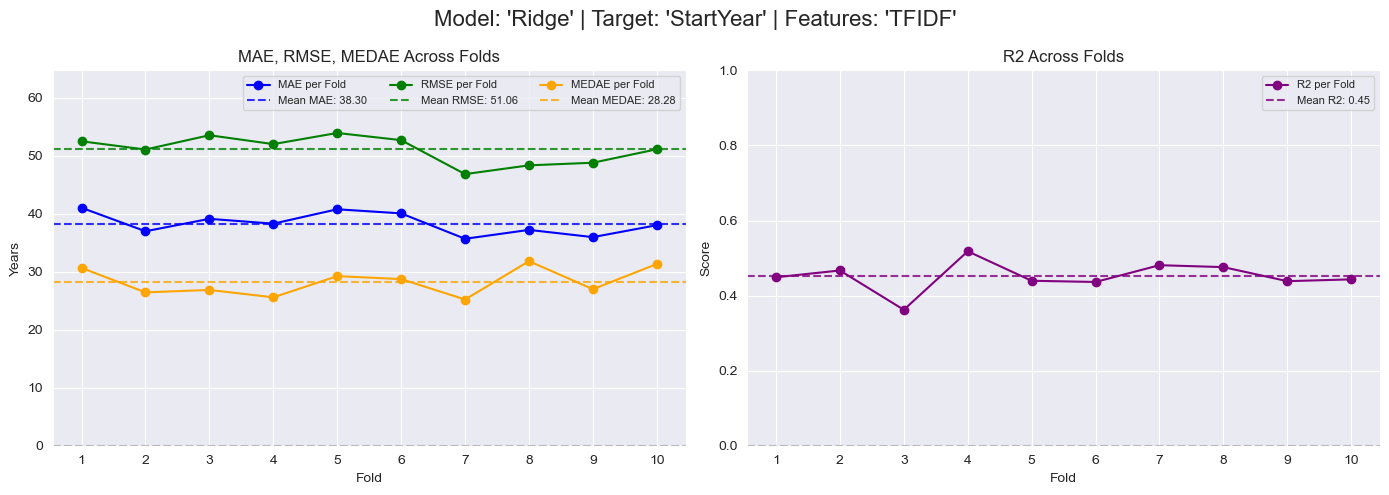

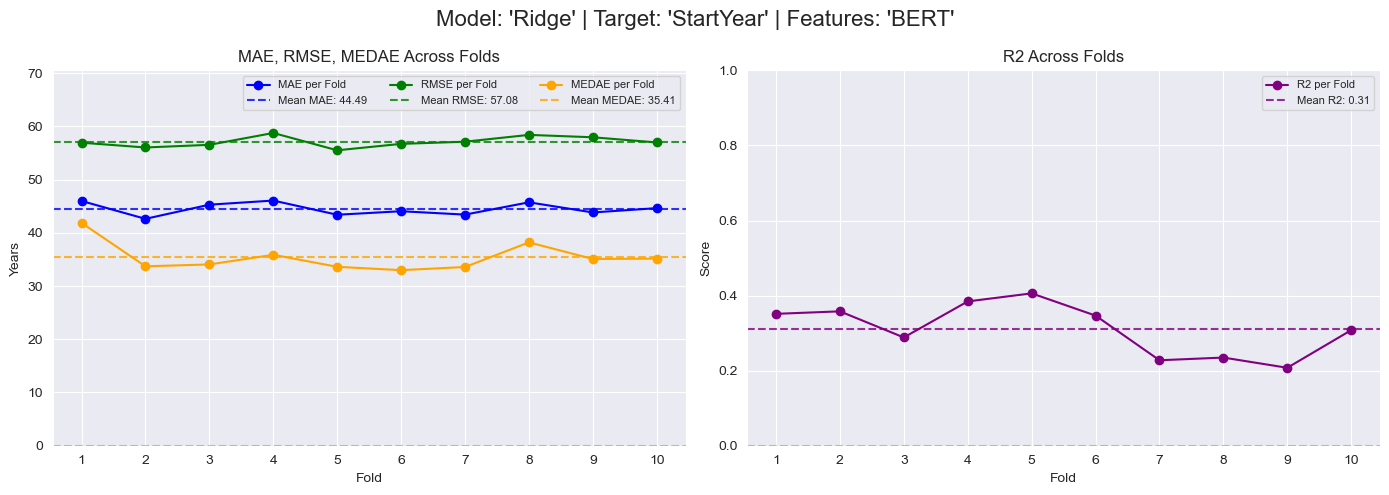

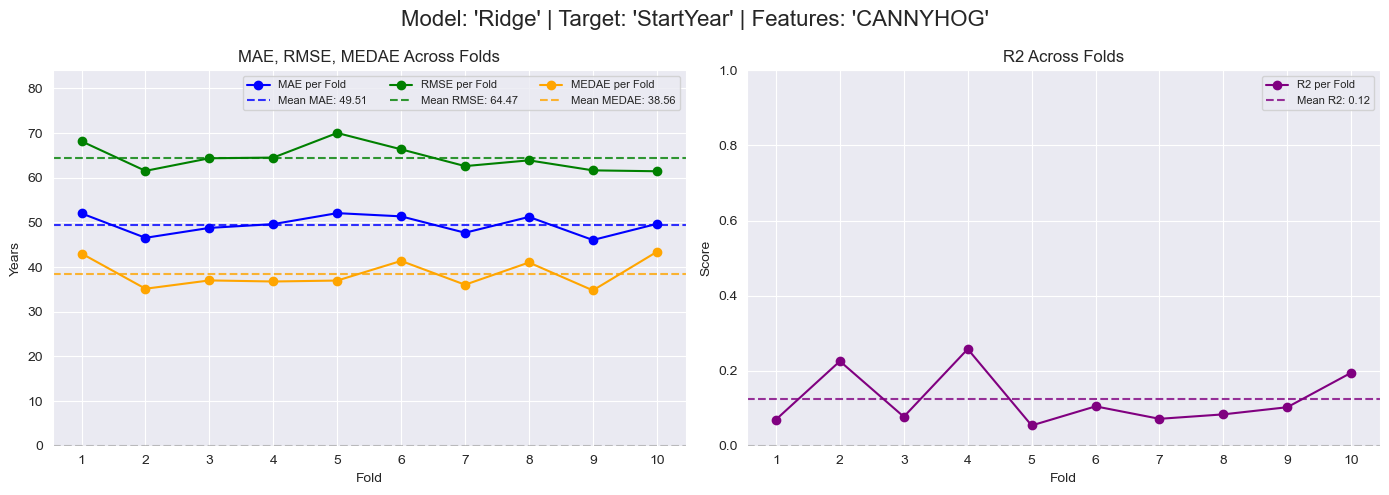

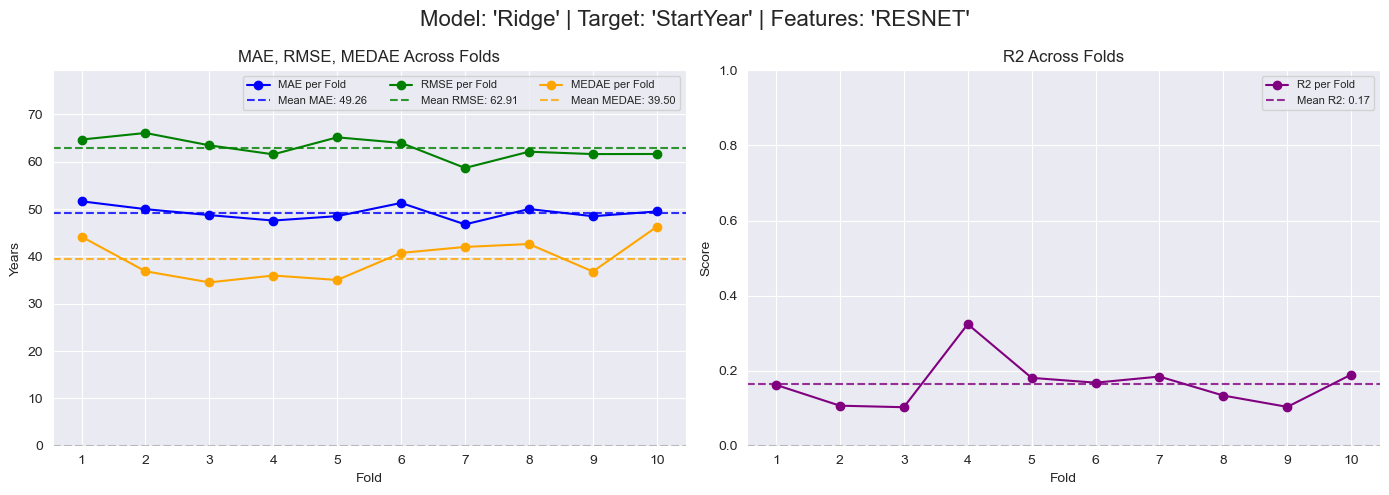

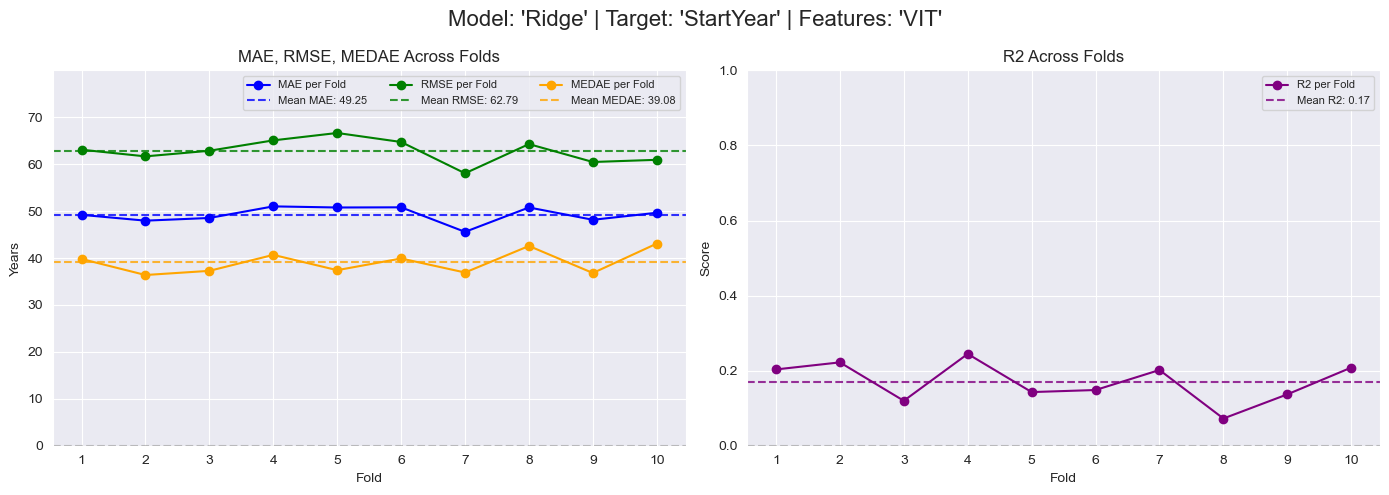

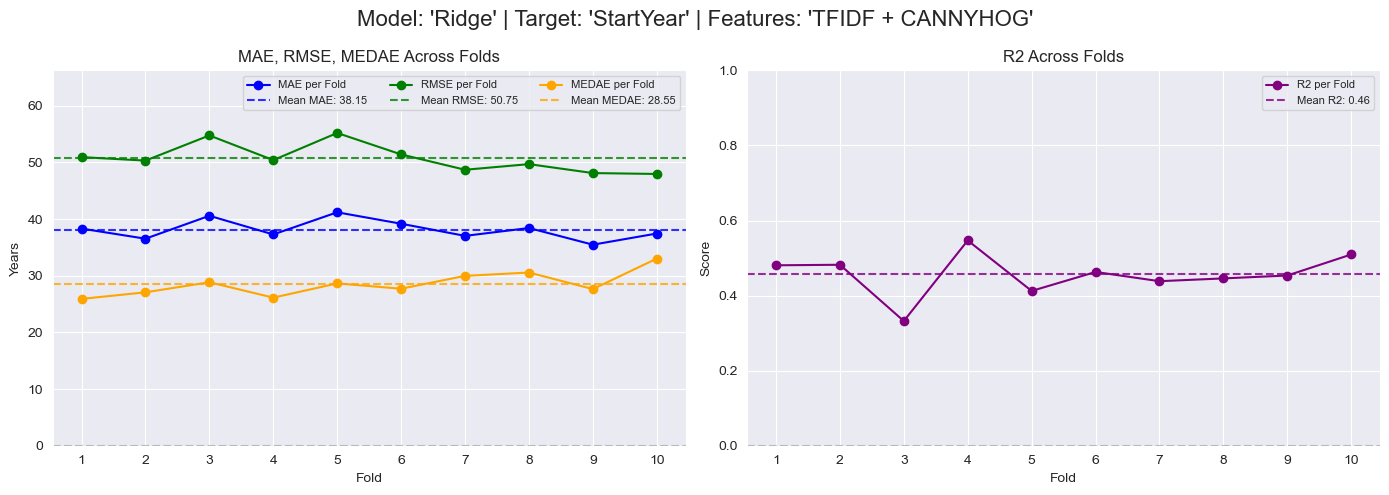

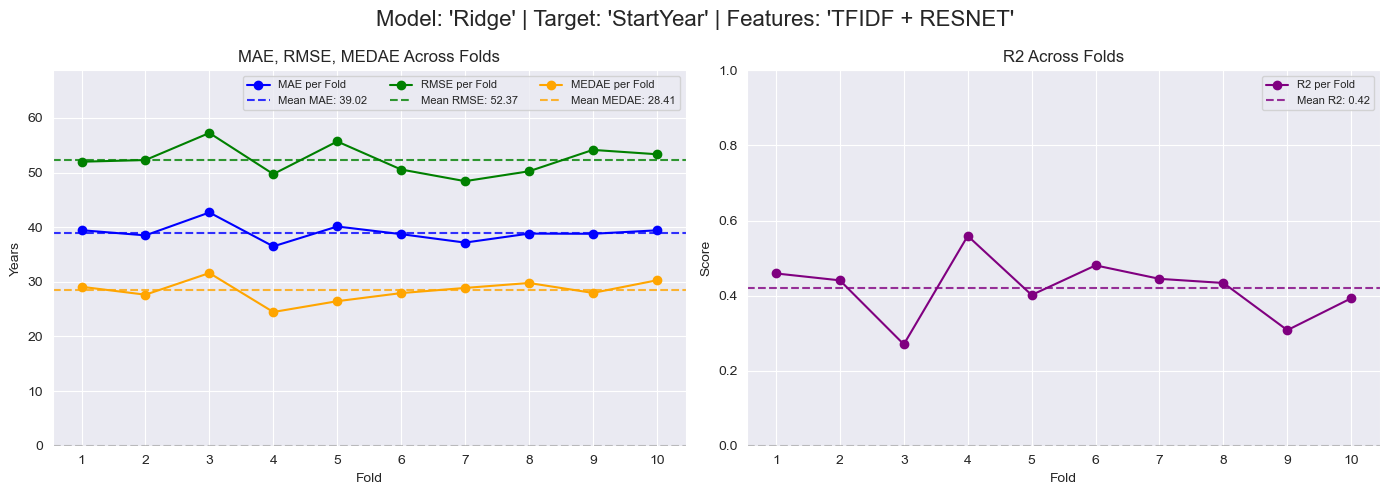

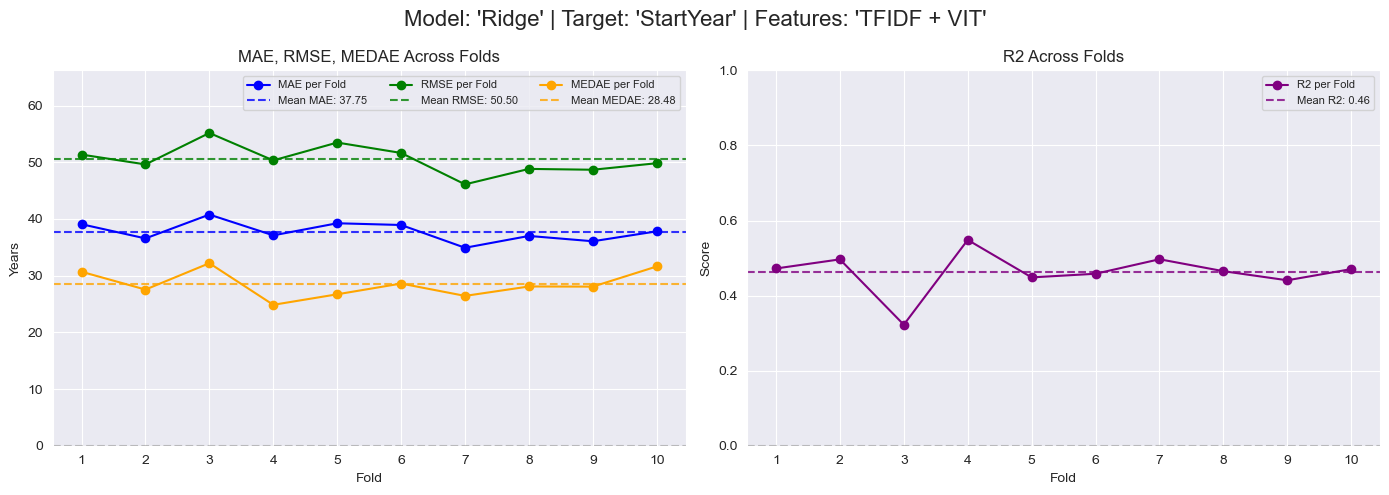

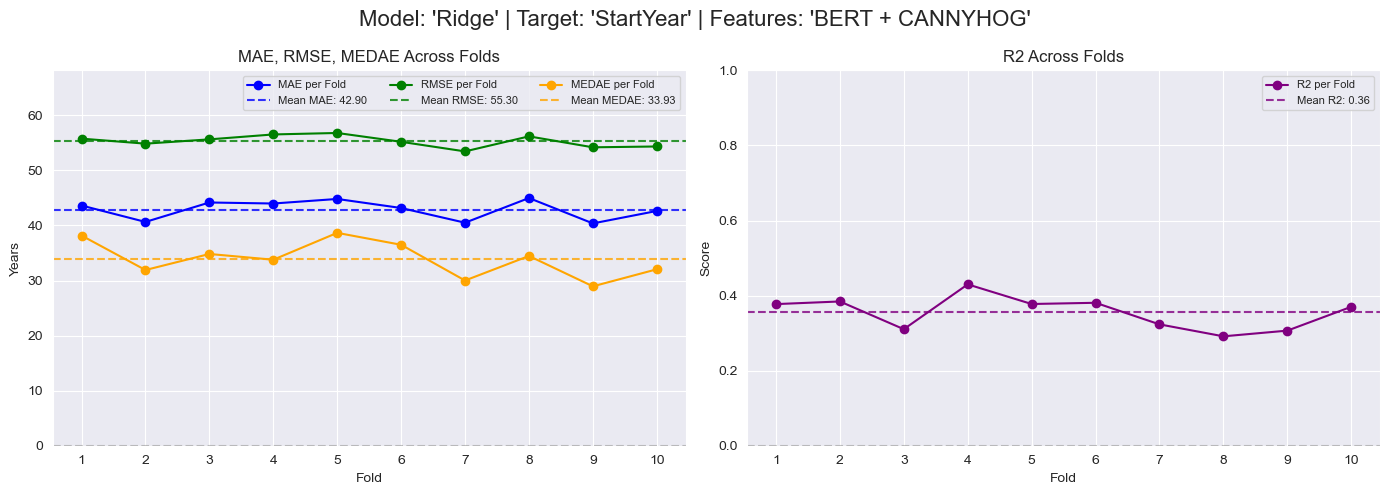

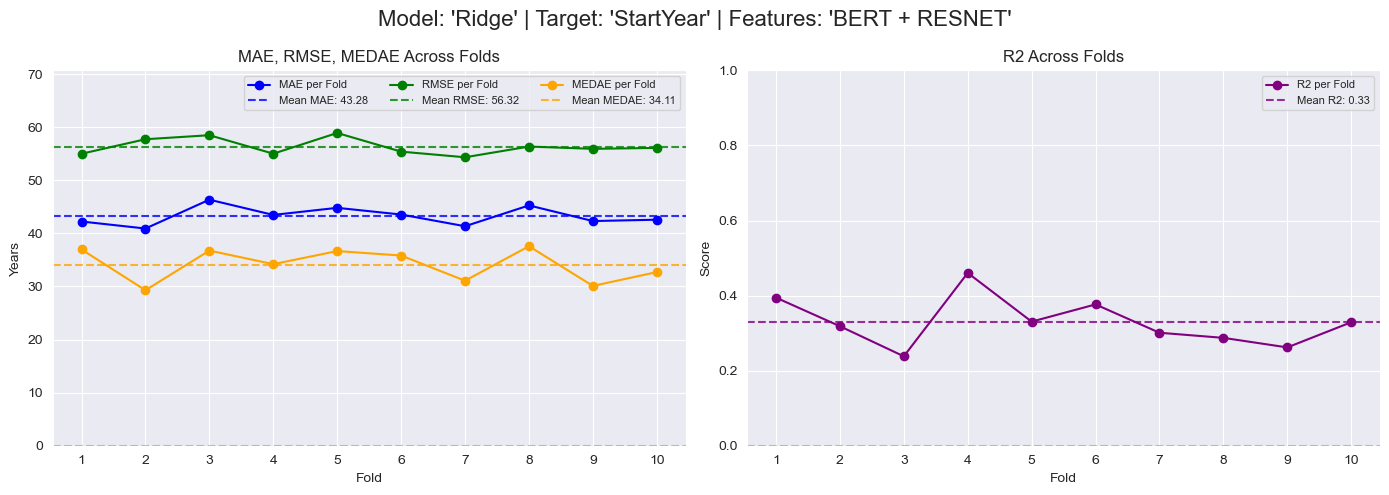

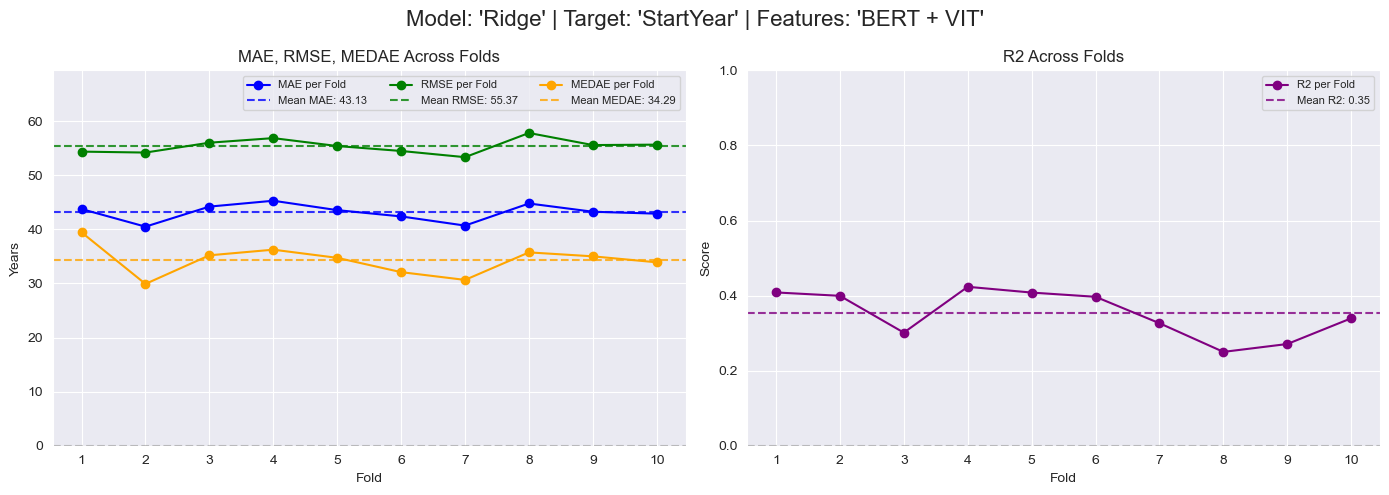

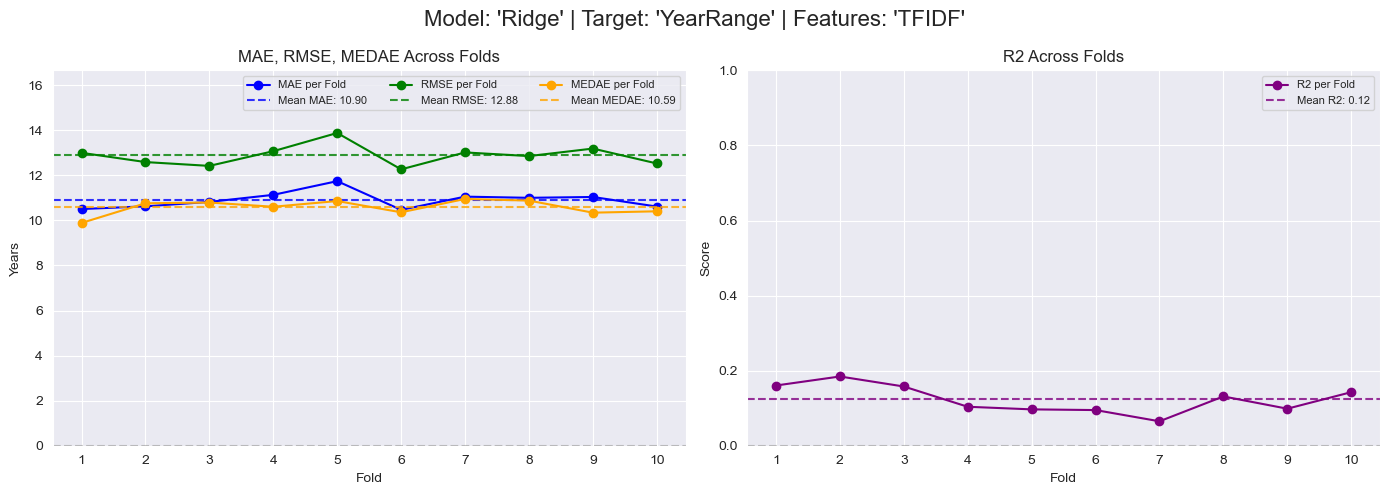

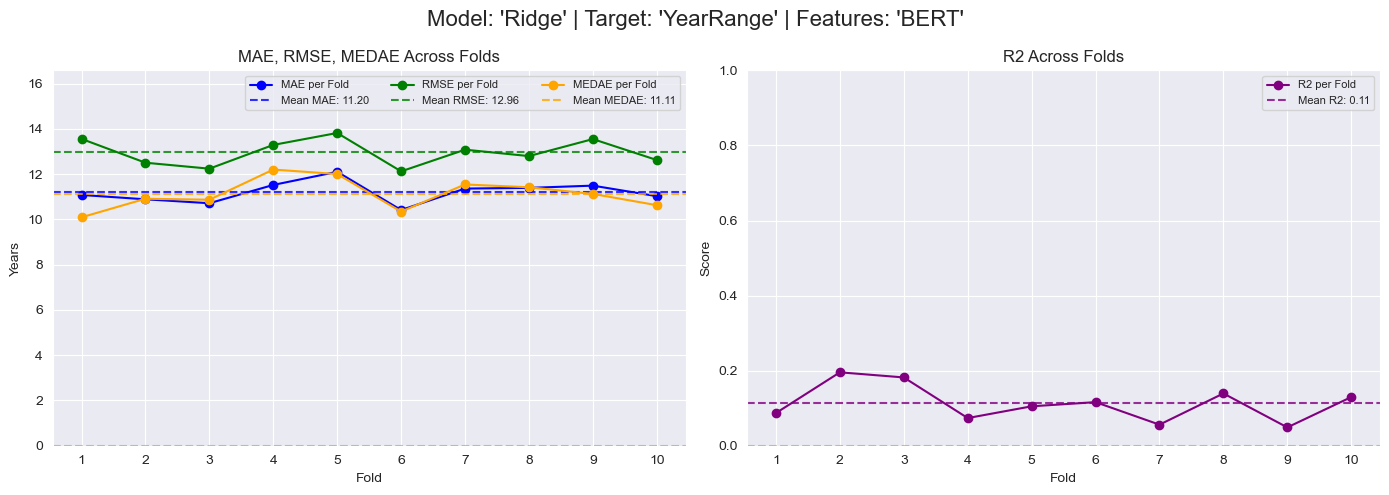

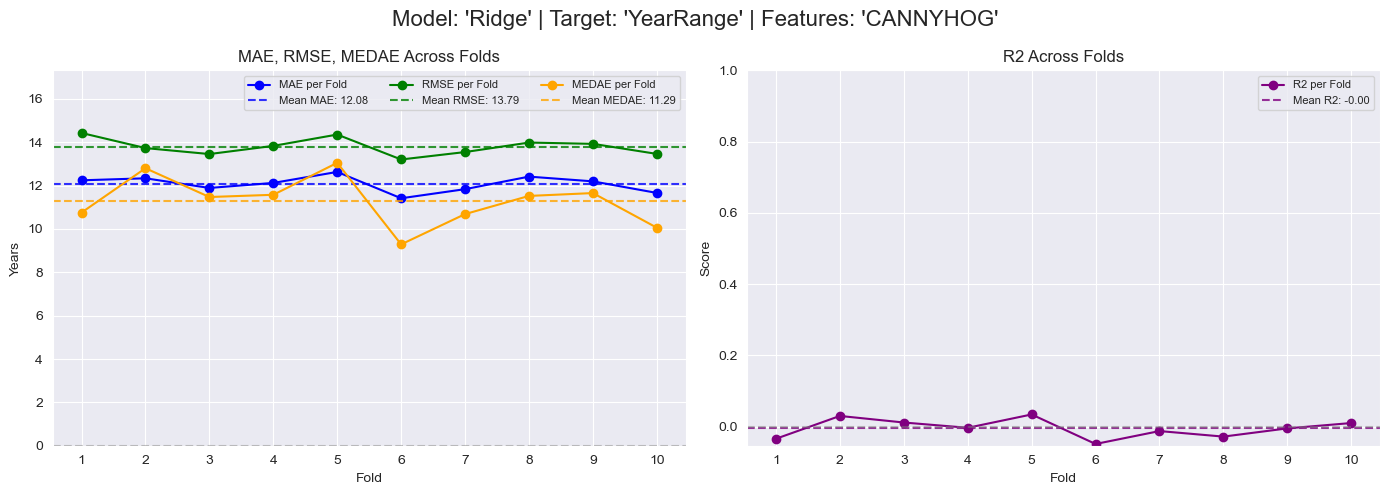

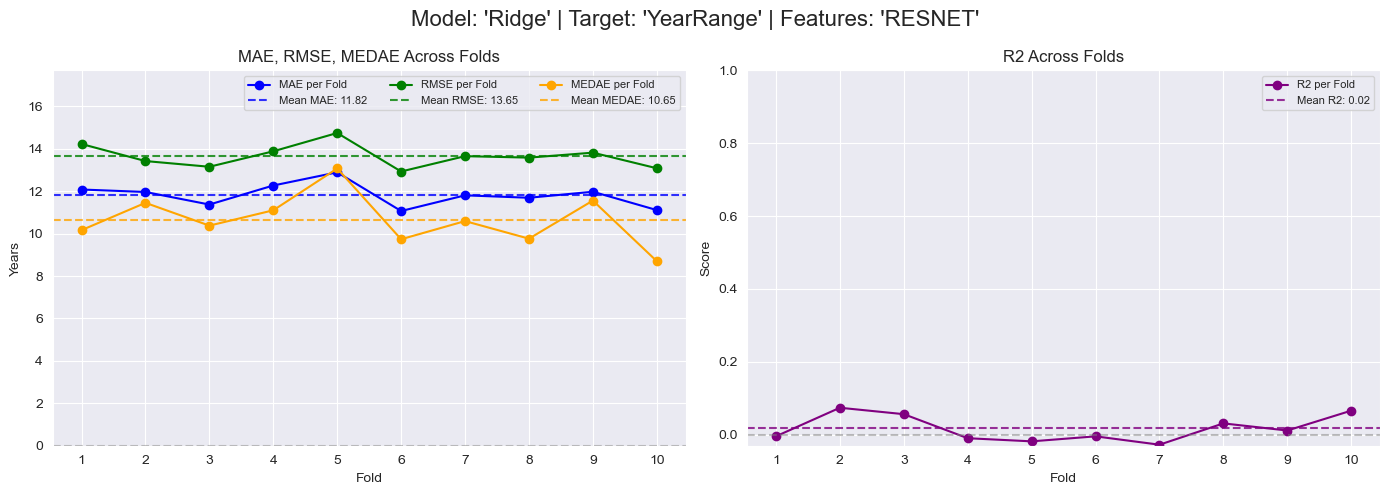

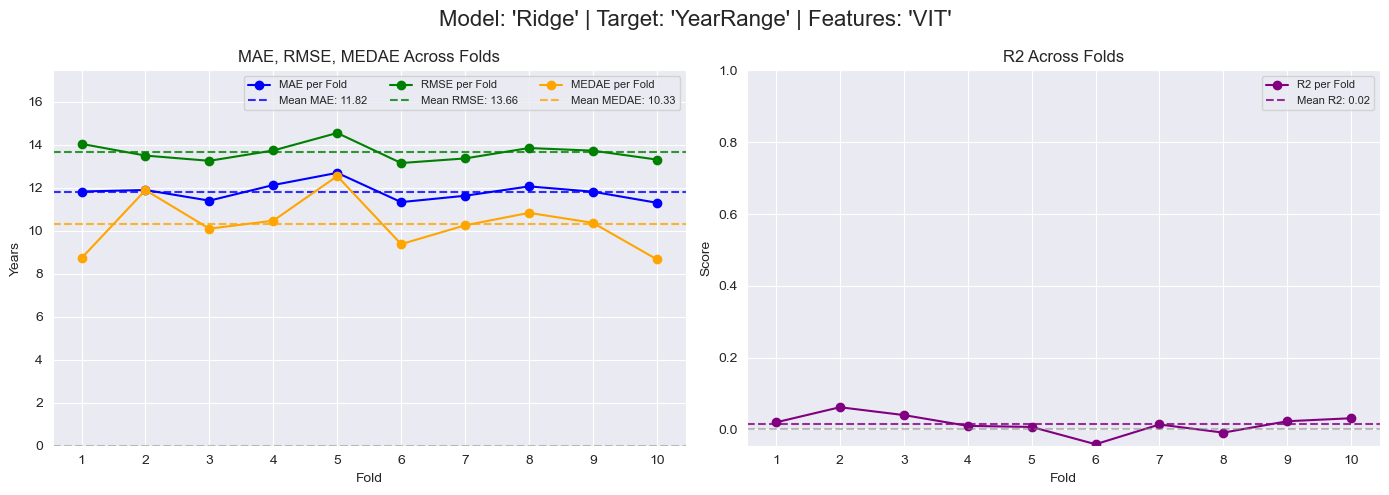

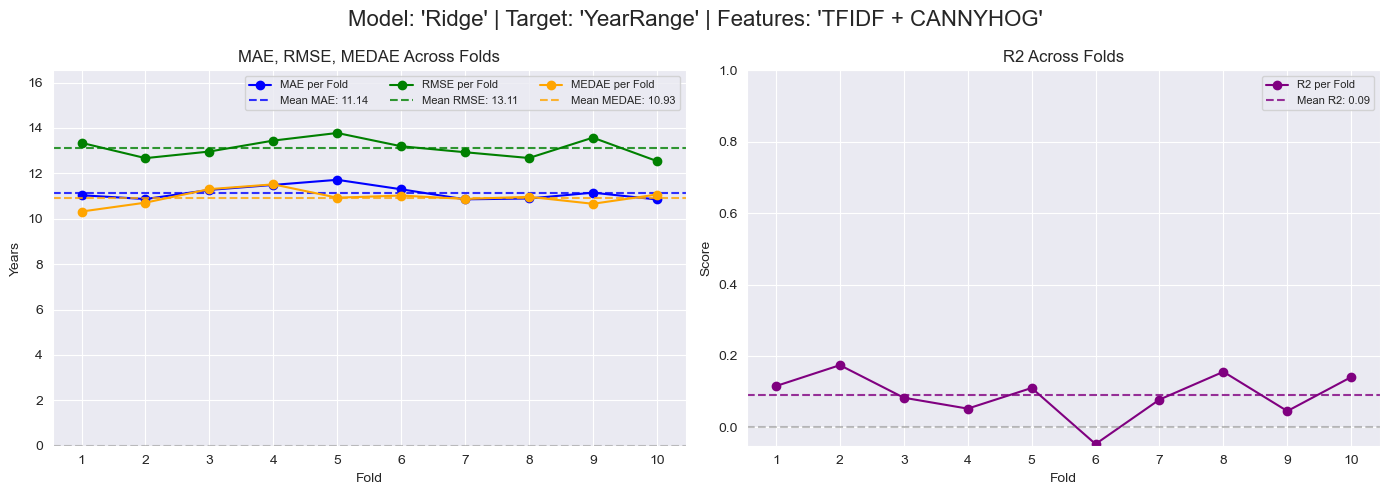

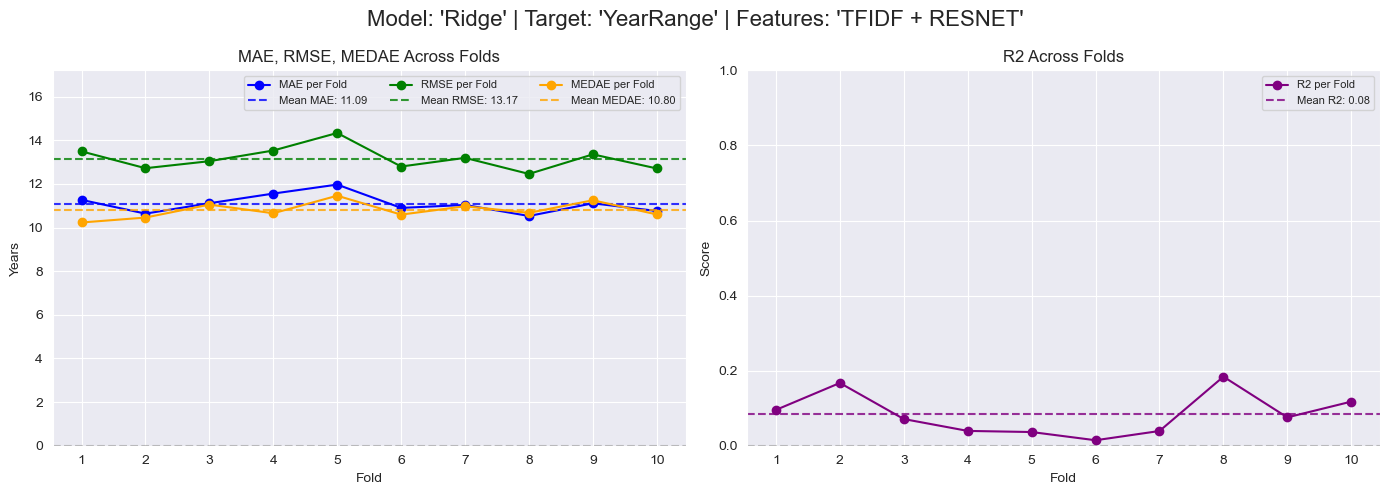

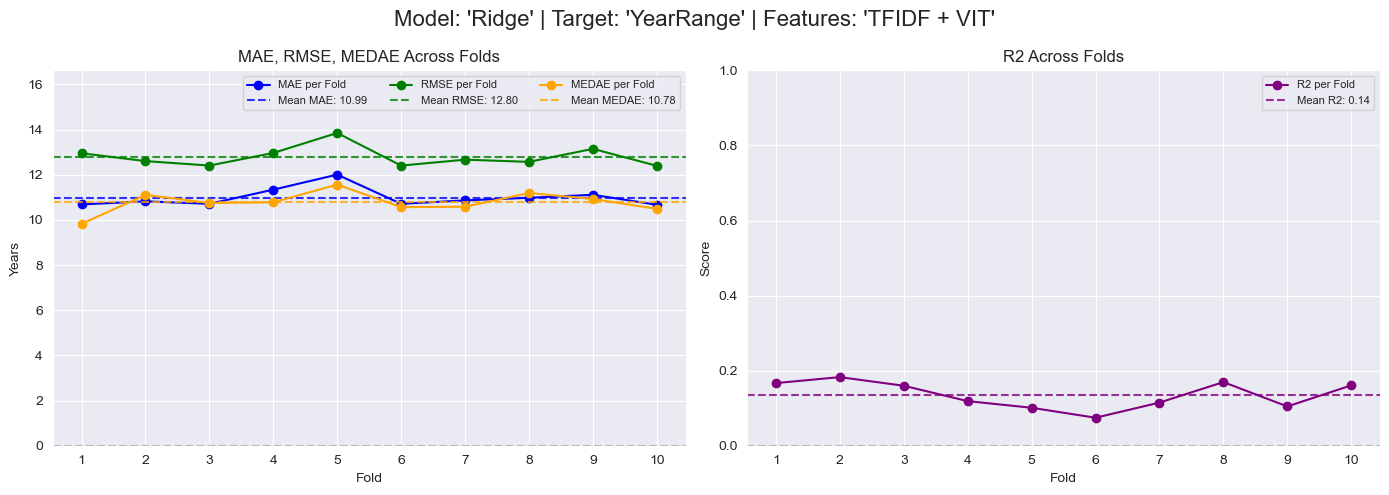

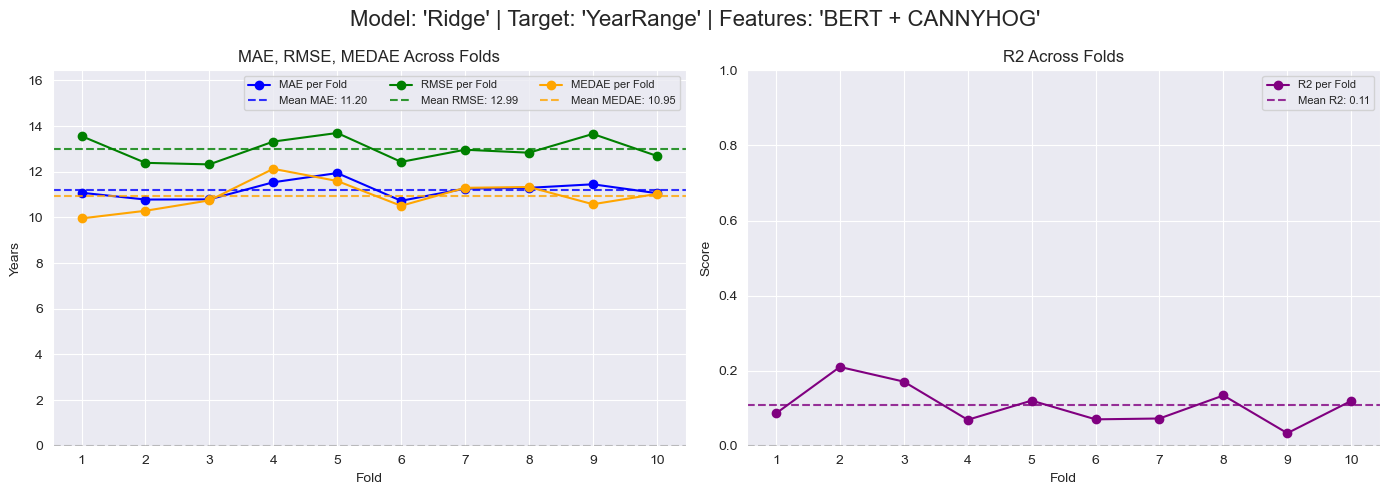

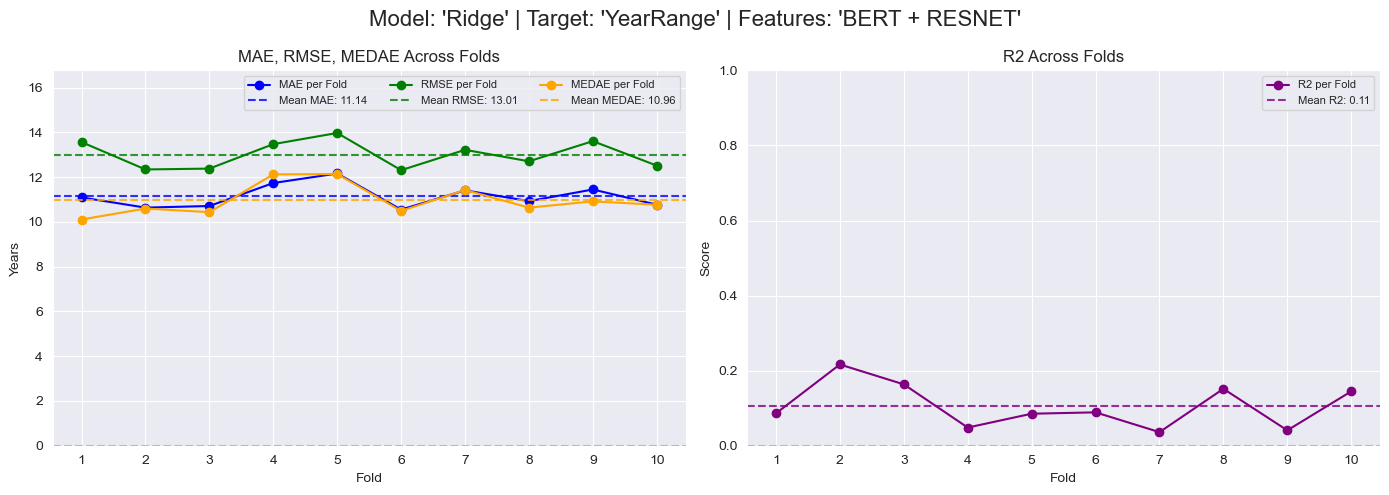

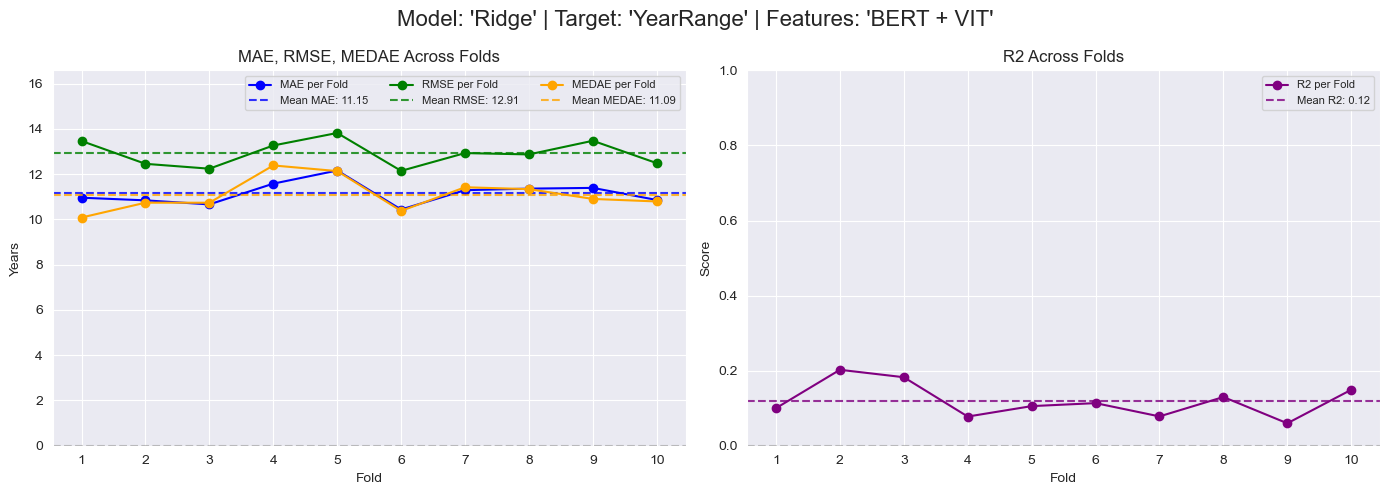

In [97]:
run_cv_all(model_name, model_class, best_params[model_name], X, y)

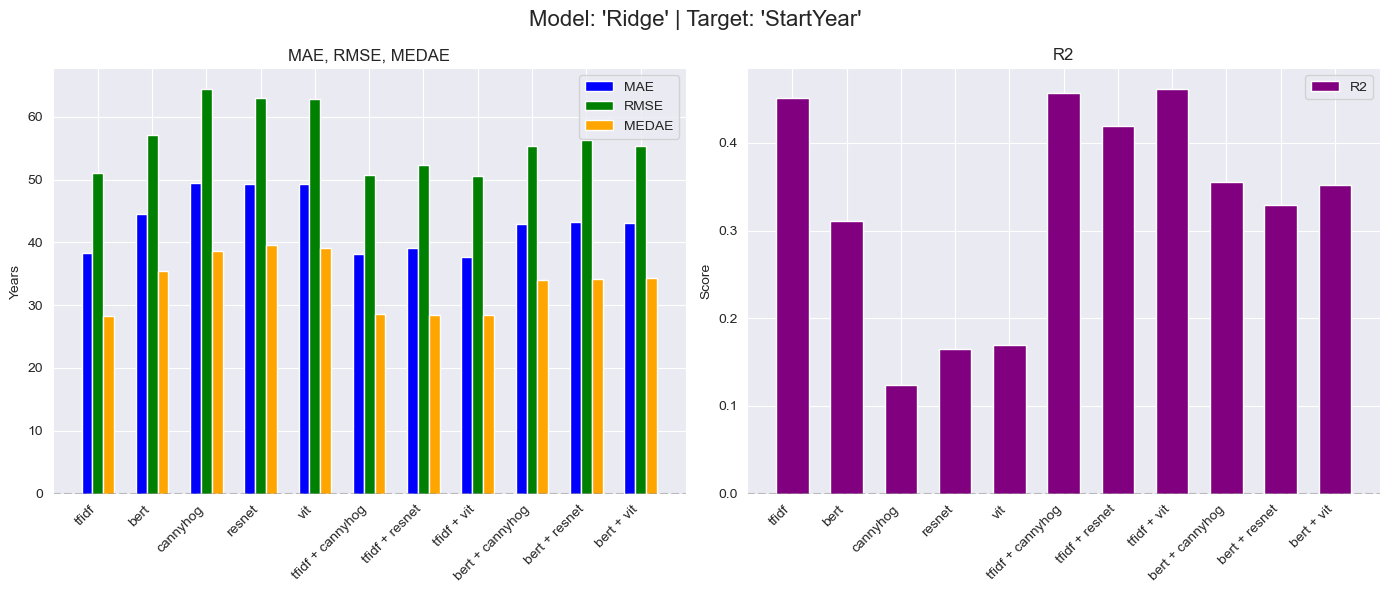

In [98]:
plot_compare_feature_scores(cv_scores, model_name, "StartYear")

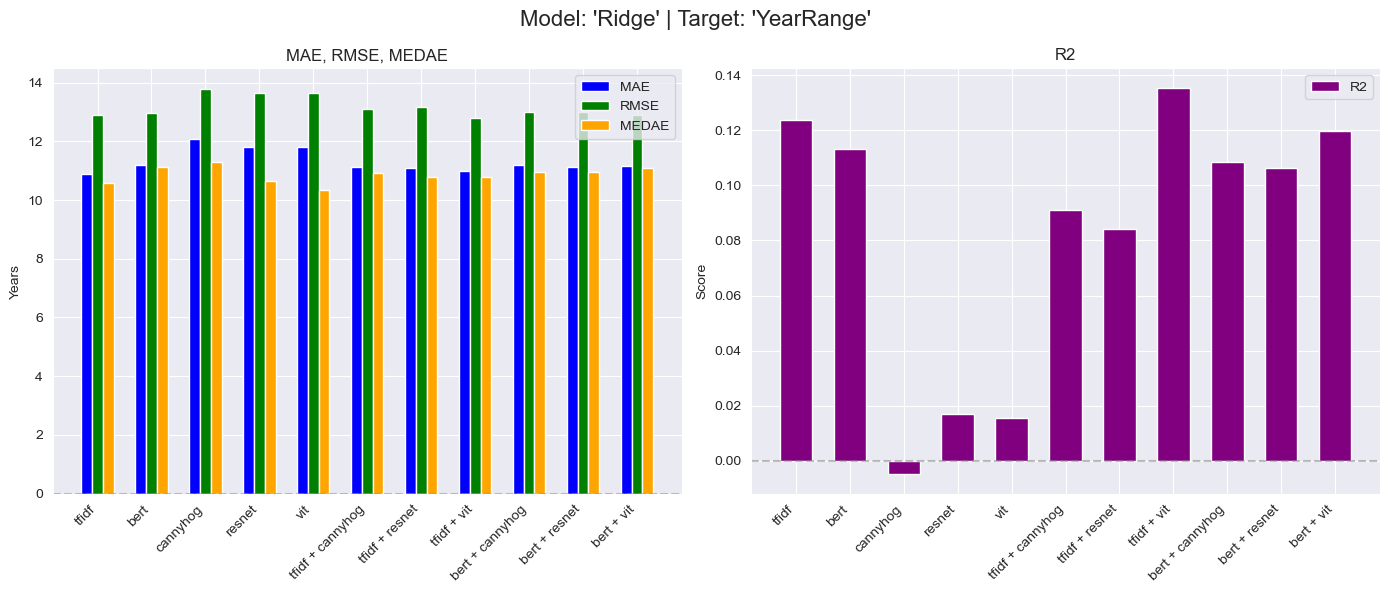

In [99]:
plot_compare_feature_scores(cv_scores, model_name, "YearRange")

## Lasso Regression

In [100]:
model_name = "Lasso"
model_class = Lasso

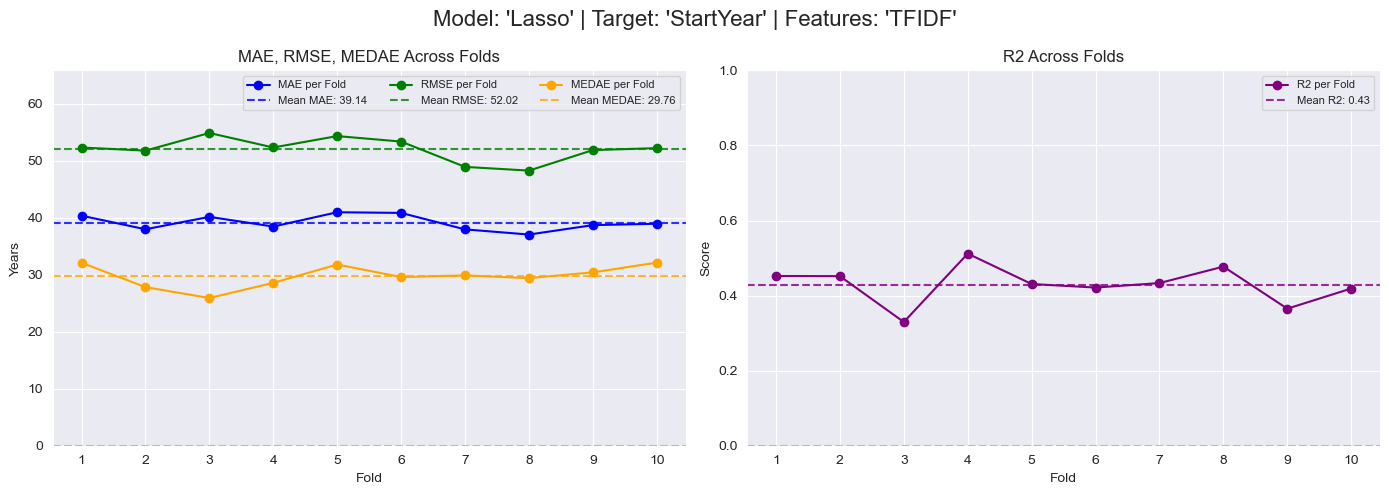

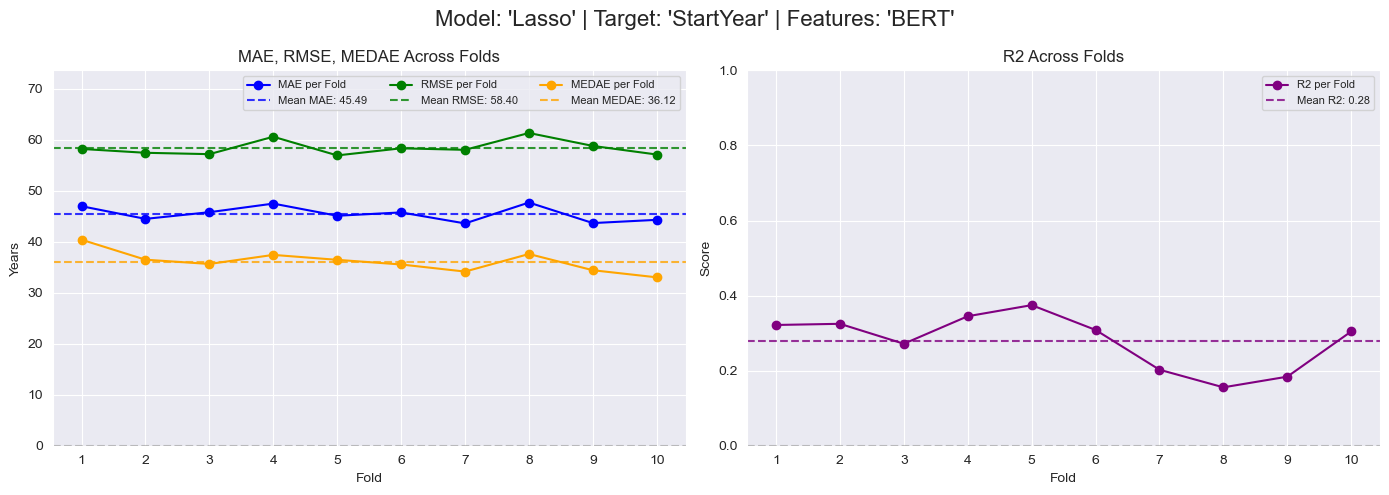

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e+06, tolerance: 7.382e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e+06, tolerance: 7.409e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

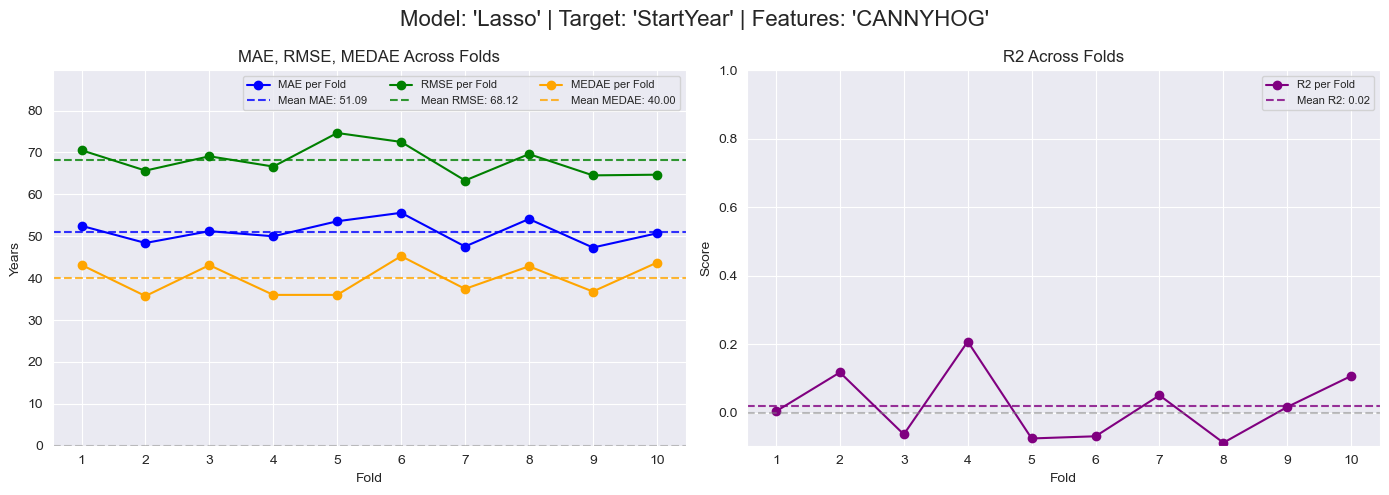

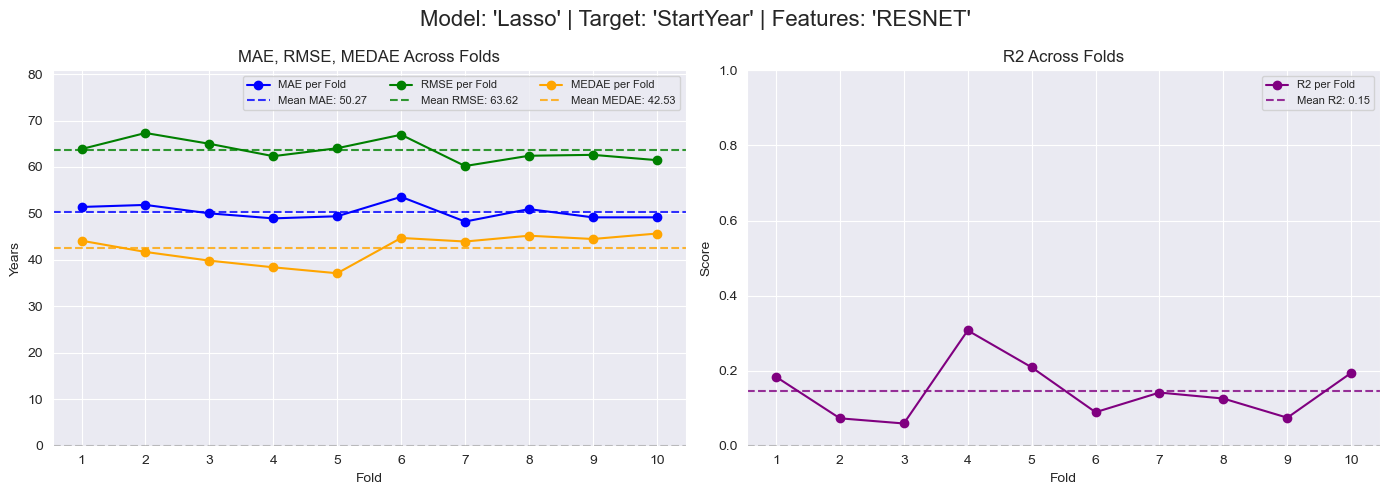

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e+03, tolerance: 7.444e+02
  model = cd_fast.enet_coordinate_descent(


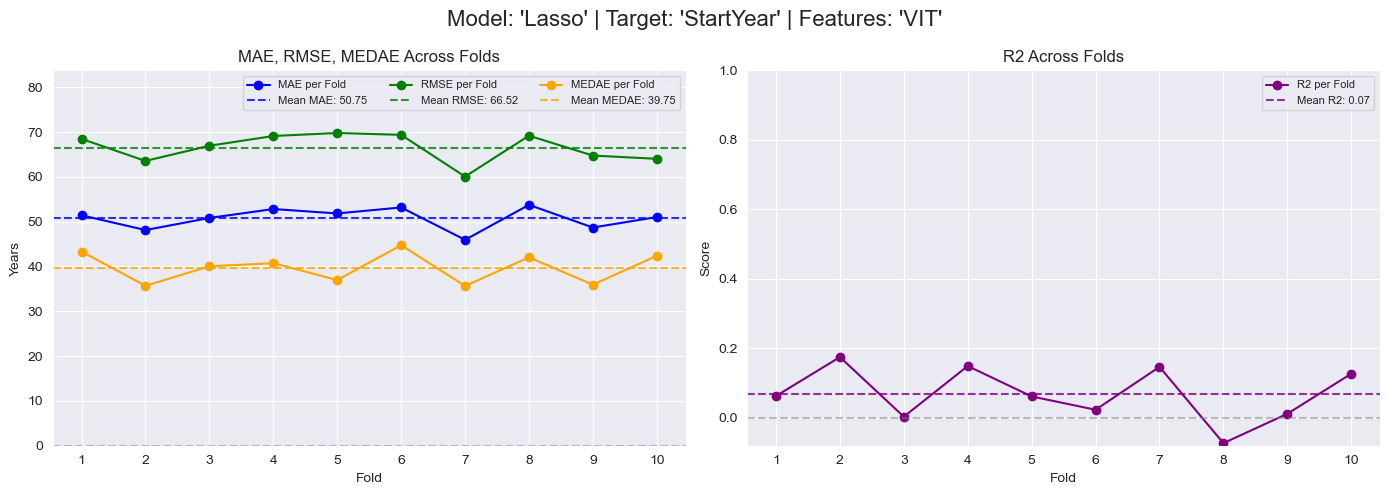

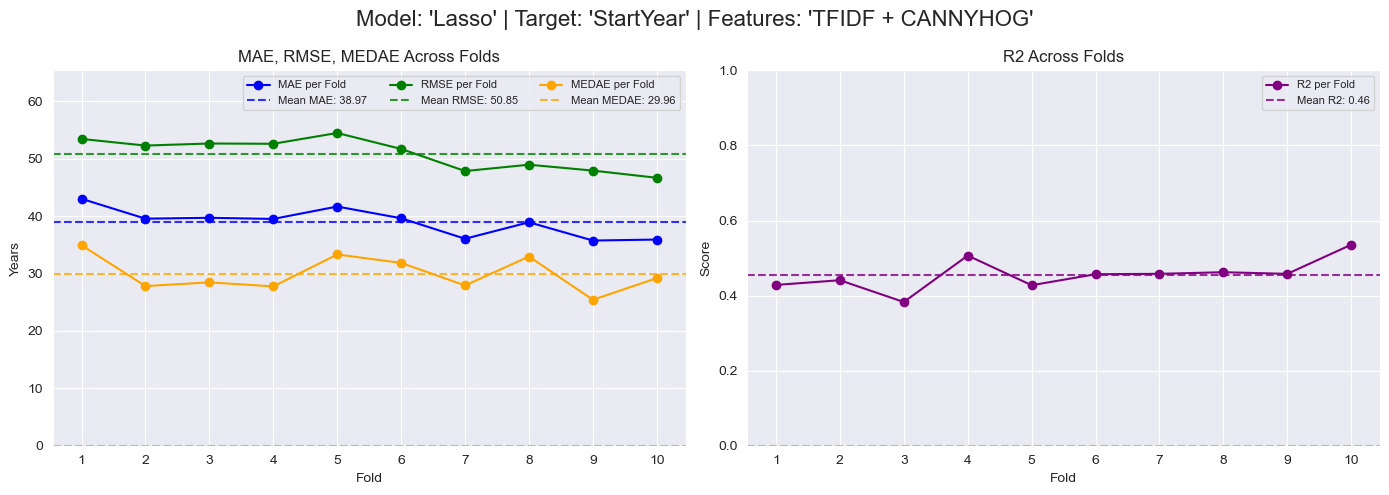

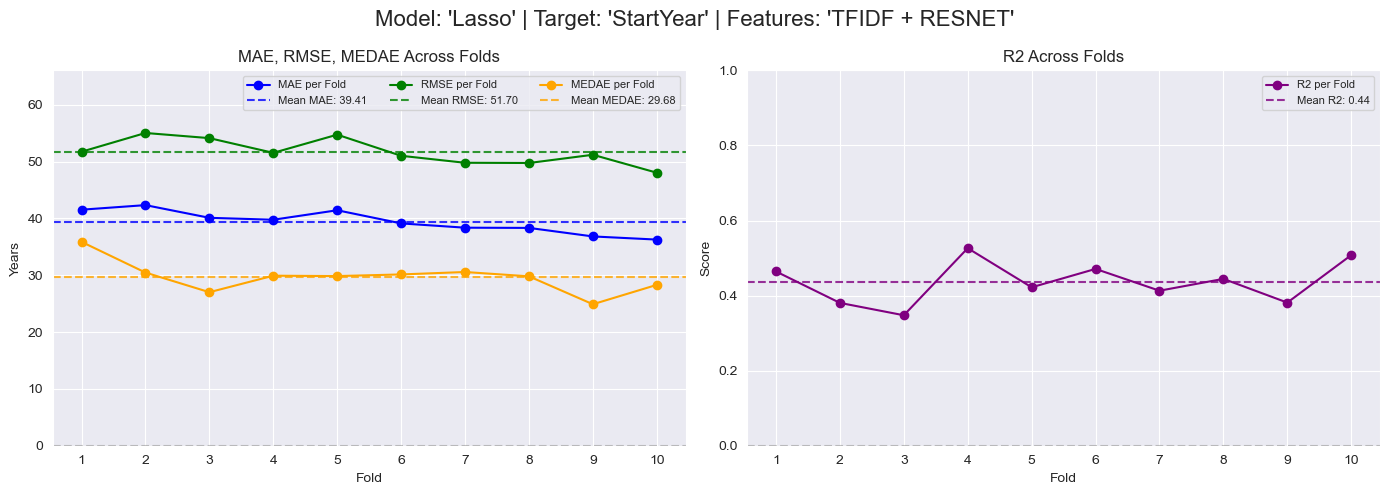

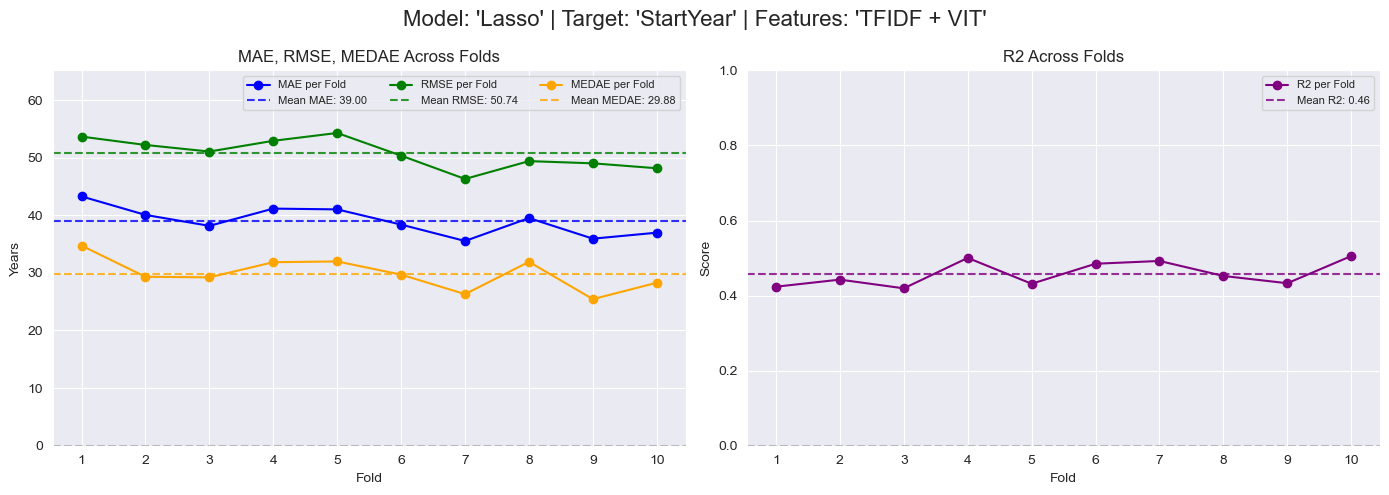

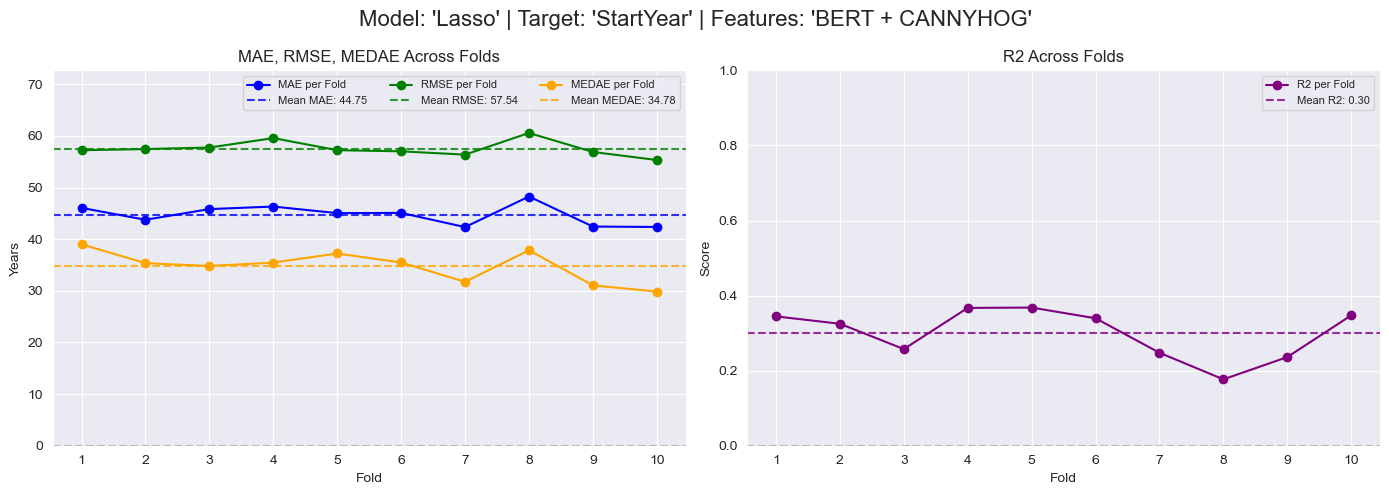

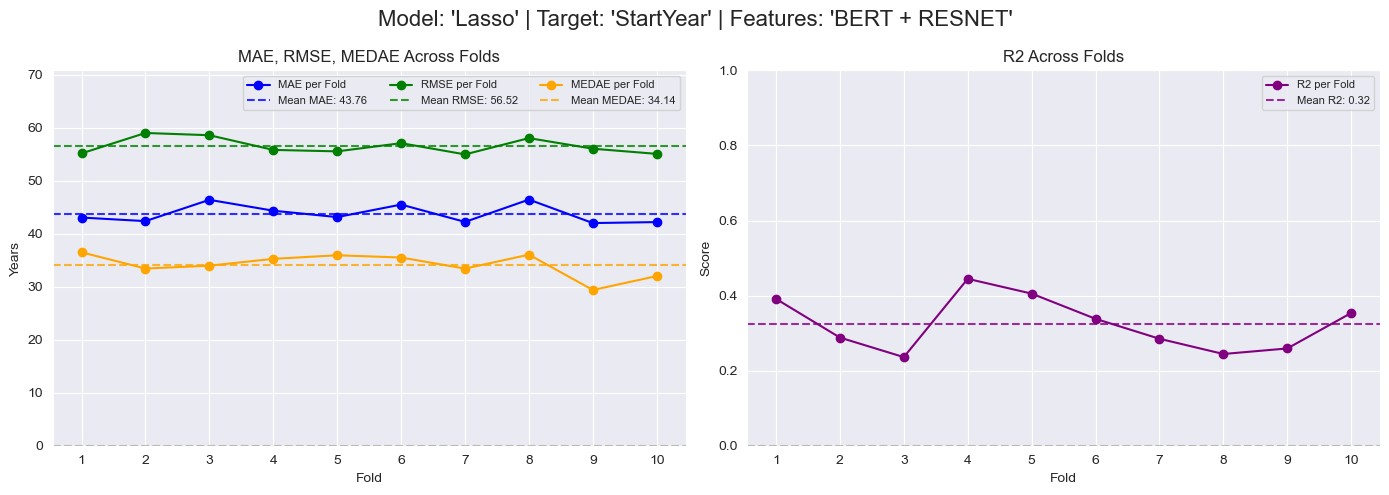

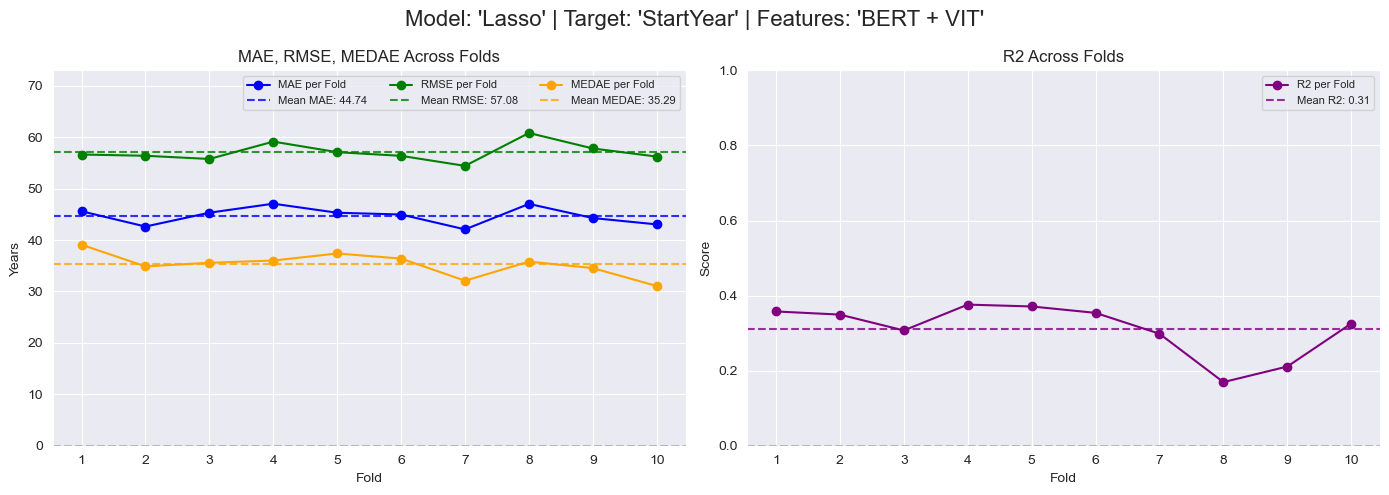

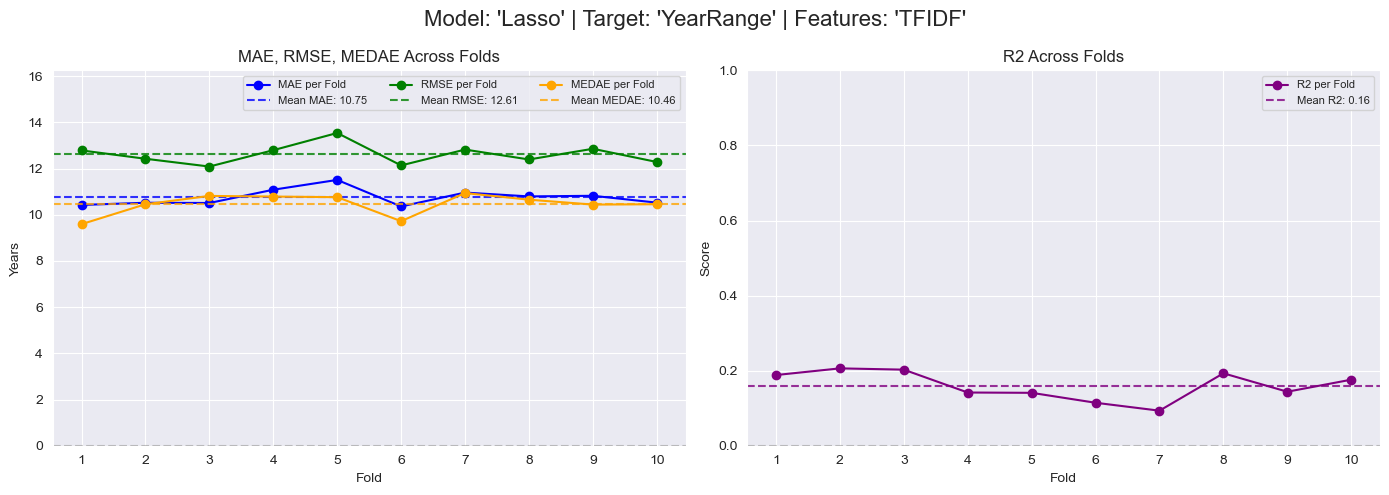

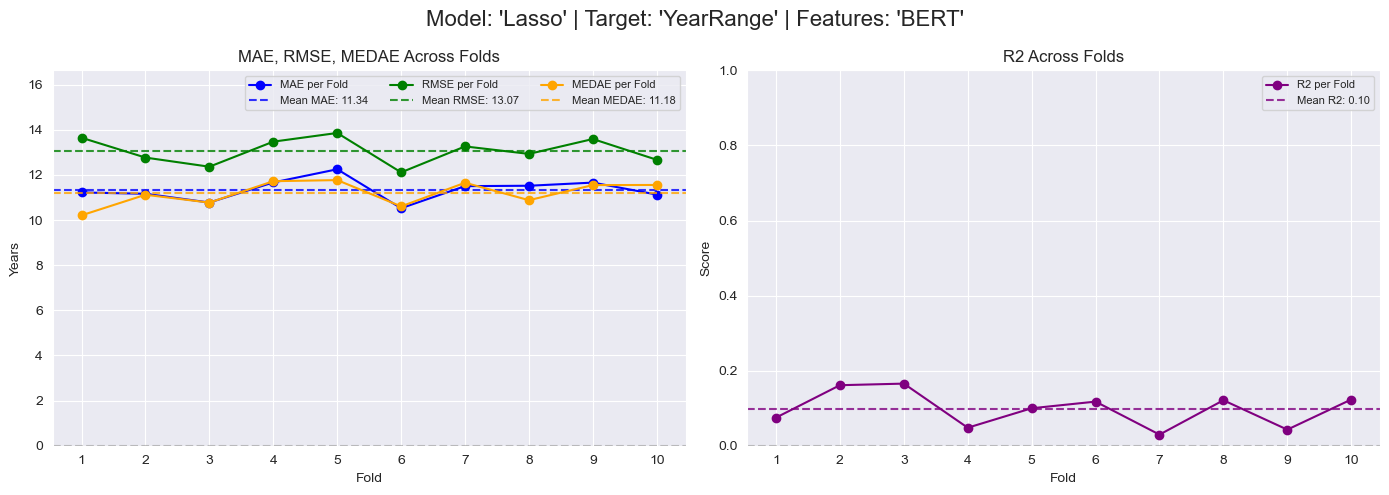

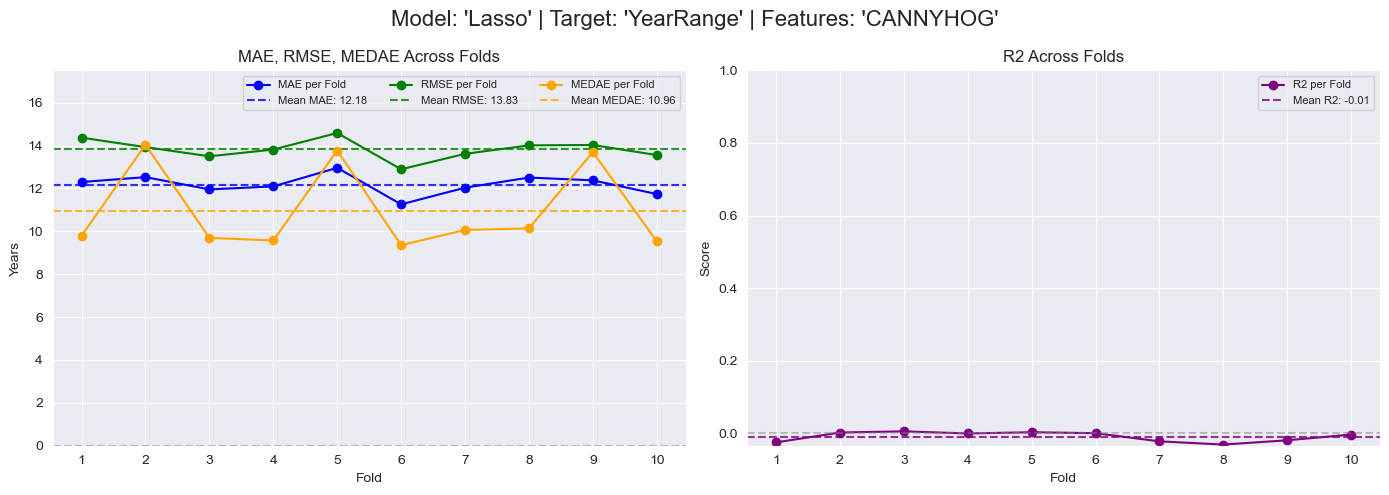

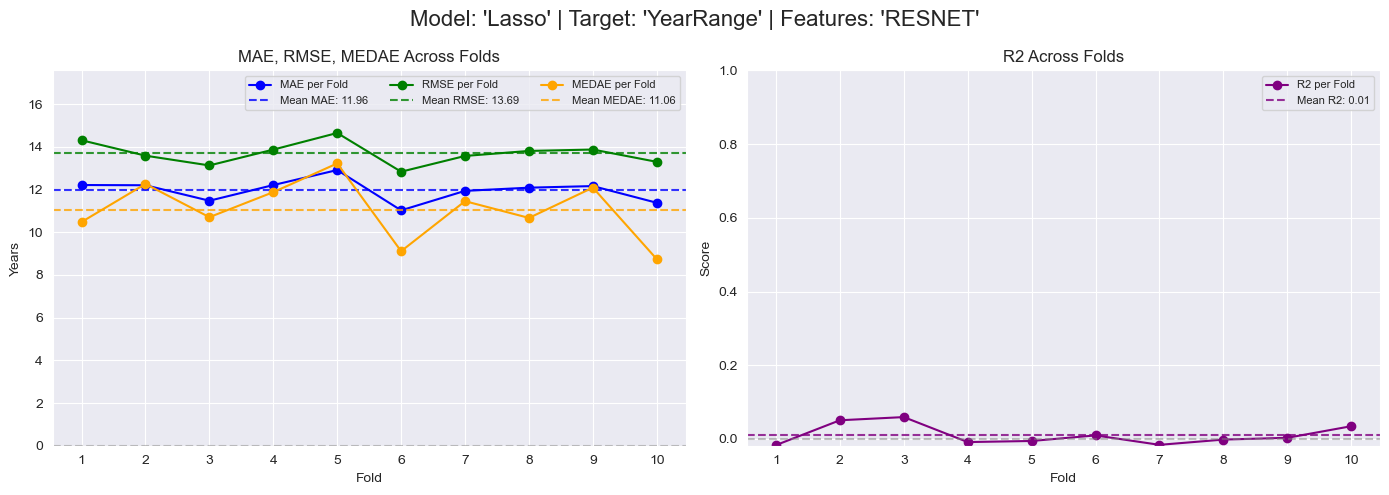

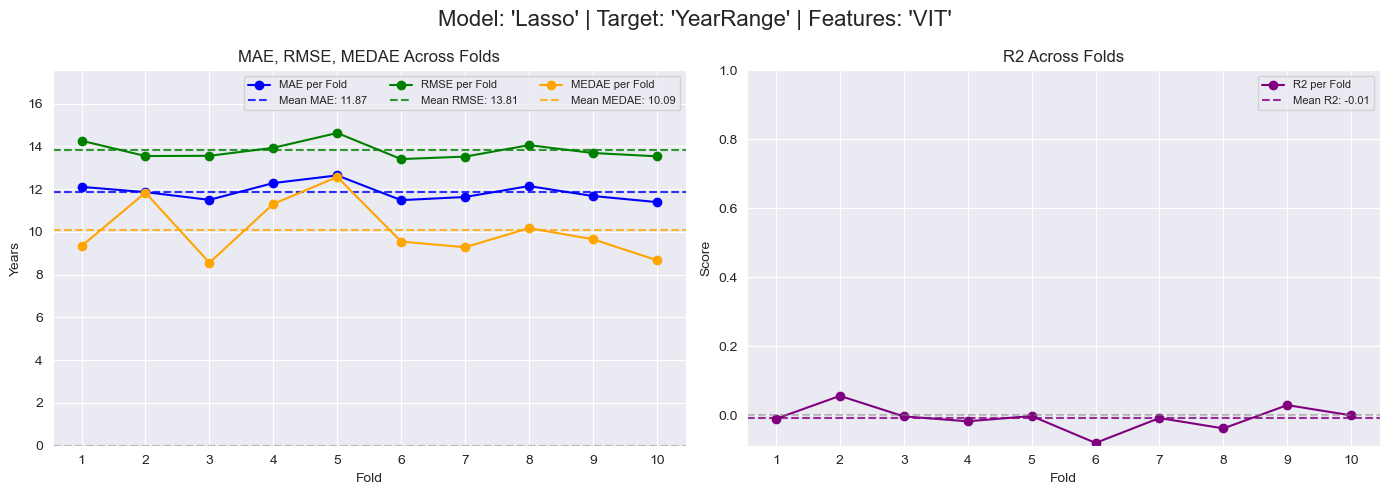

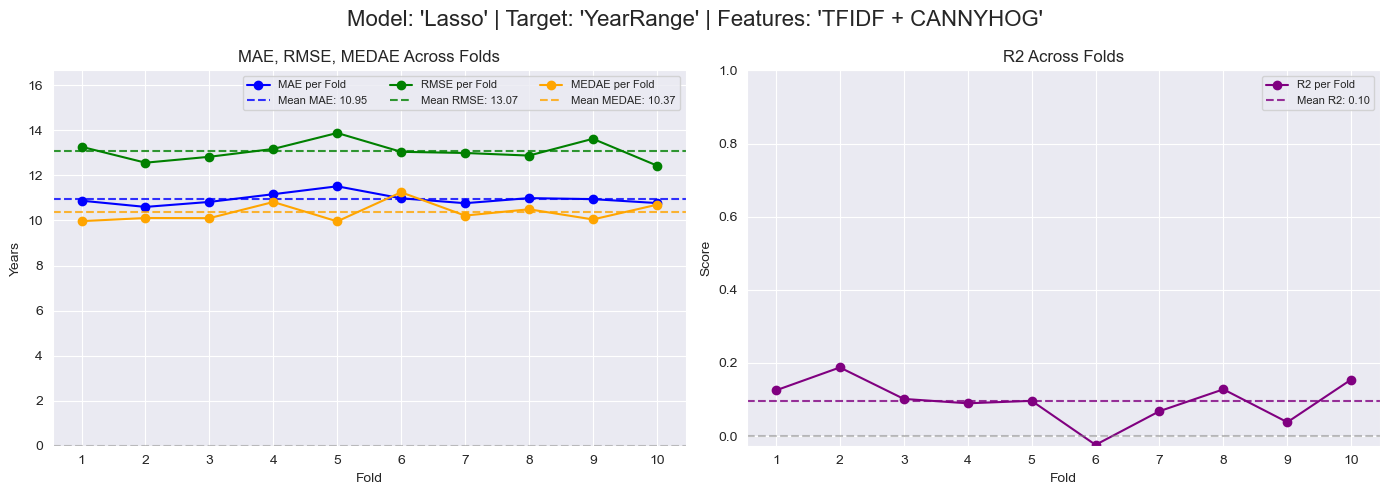

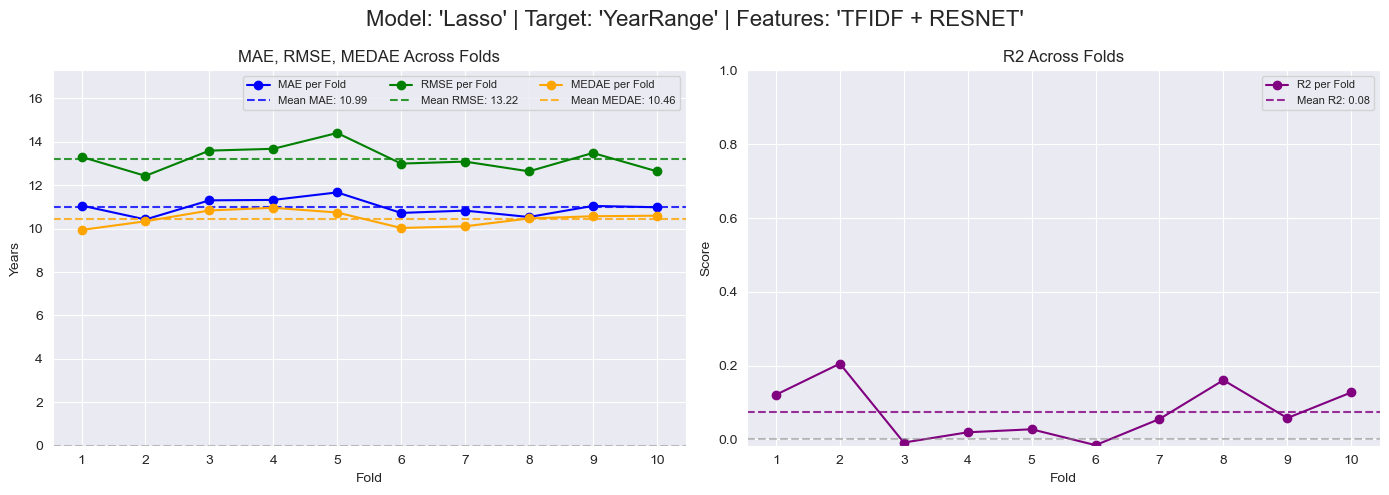

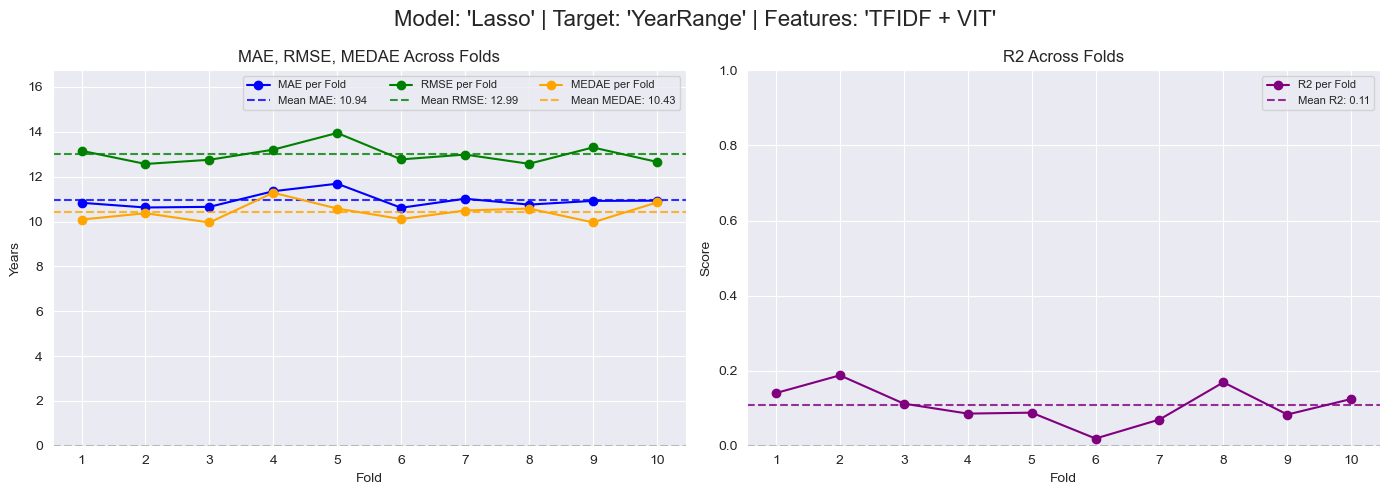

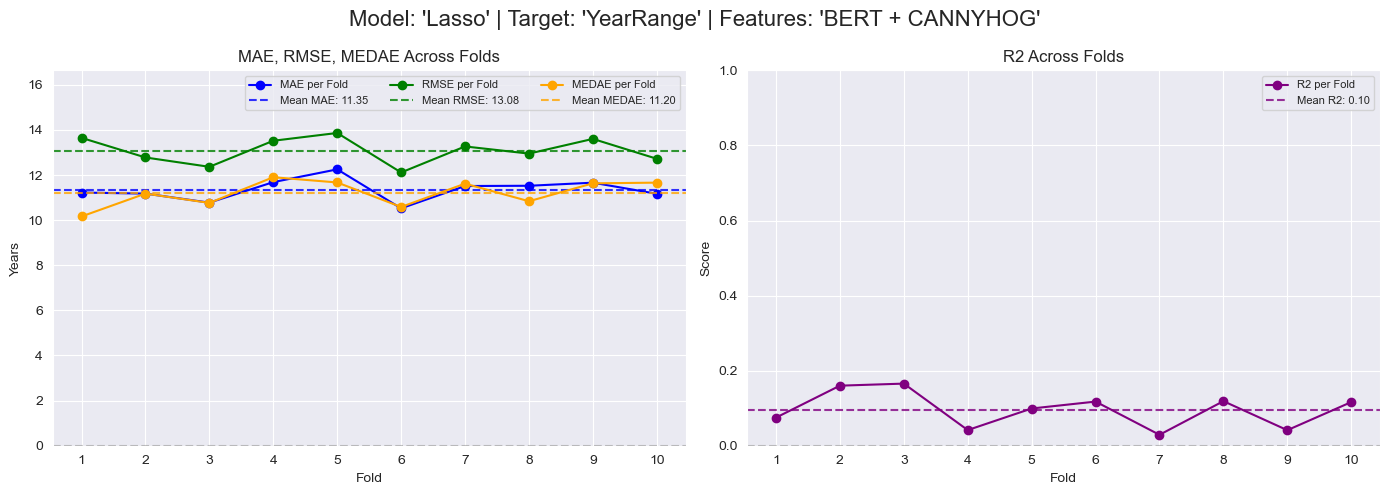

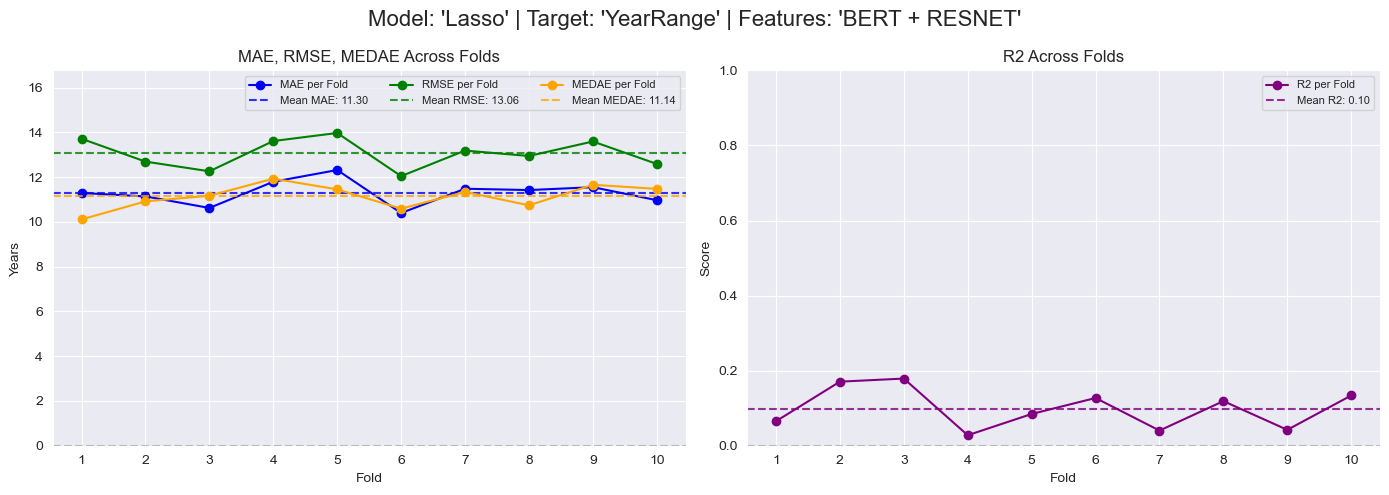

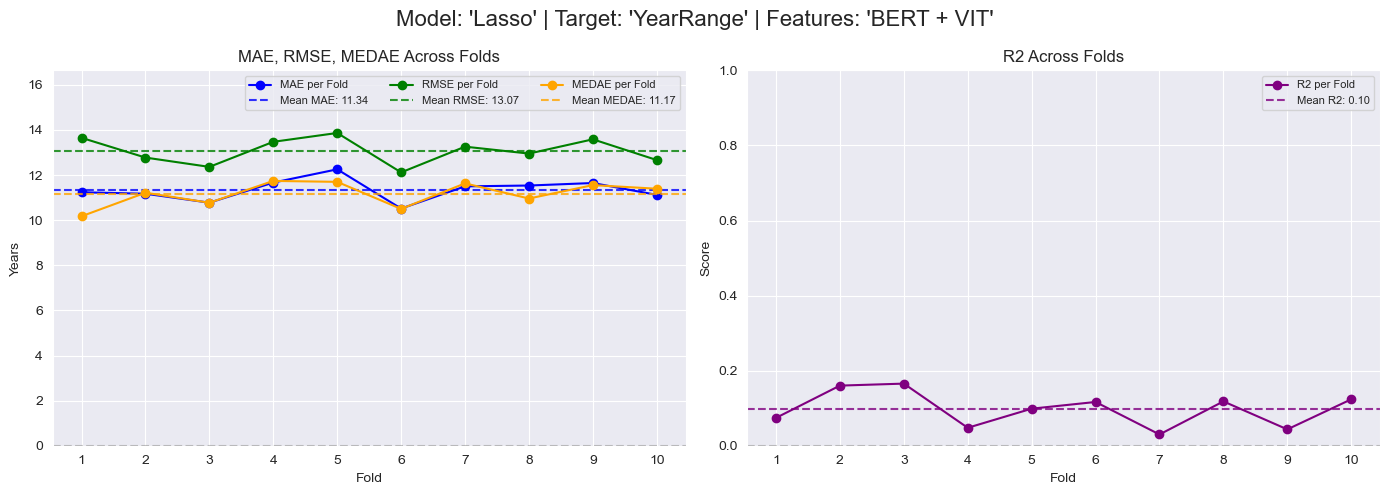

In [101]:
run_cv_all(model_name, model_class, best_params[model_name], X, y)

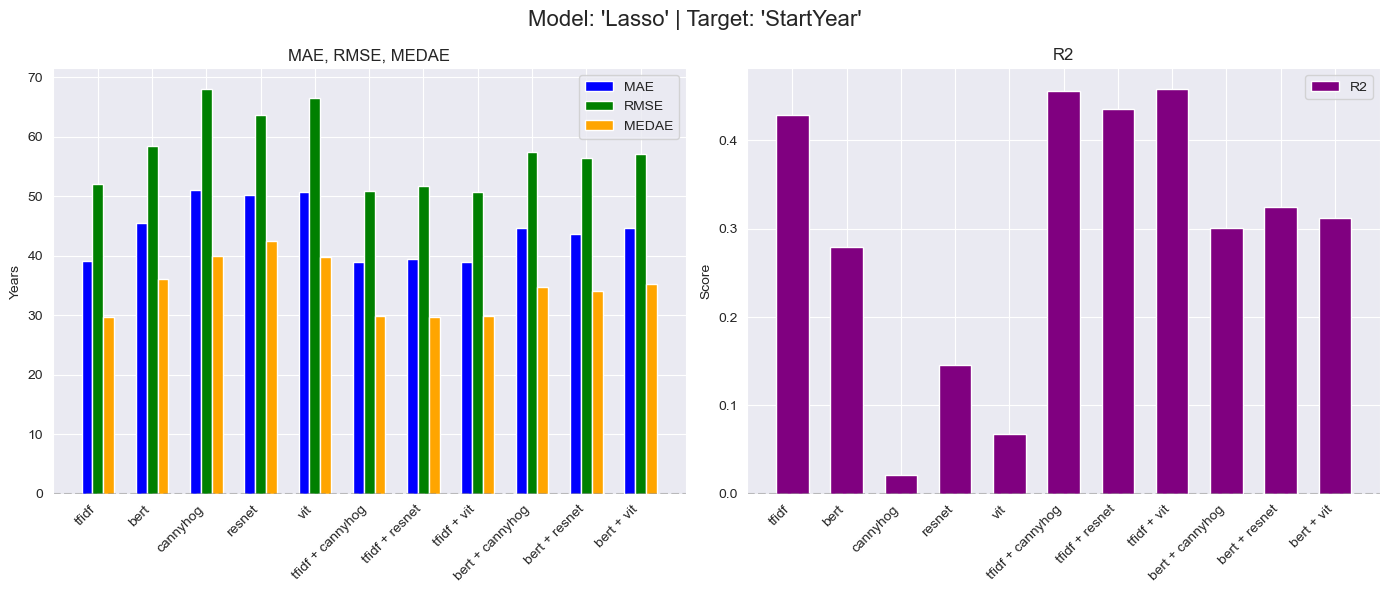

In [102]:
plot_compare_feature_scores(cv_scores, model_name, "StartYear")

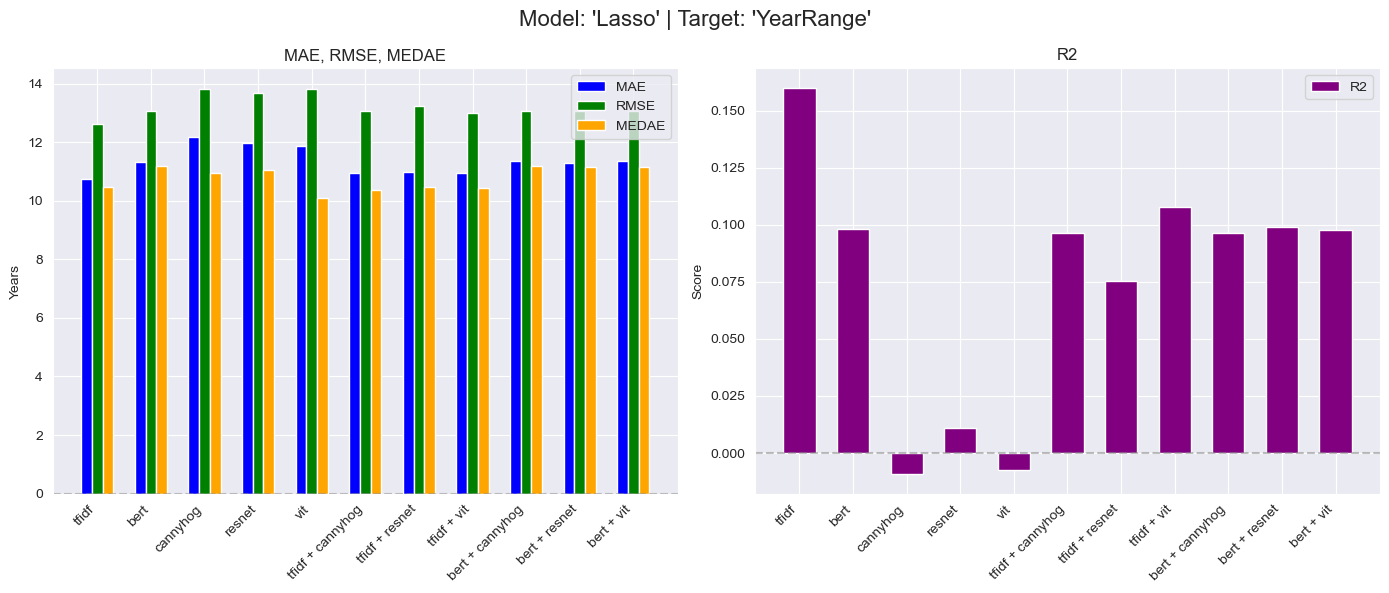

In [103]:
plot_compare_feature_scores(cv_scores, model_name, "YearRange")

## Random Forest

In [104]:
model_name = "RandomForest"
model_class = RandomForestRegressor

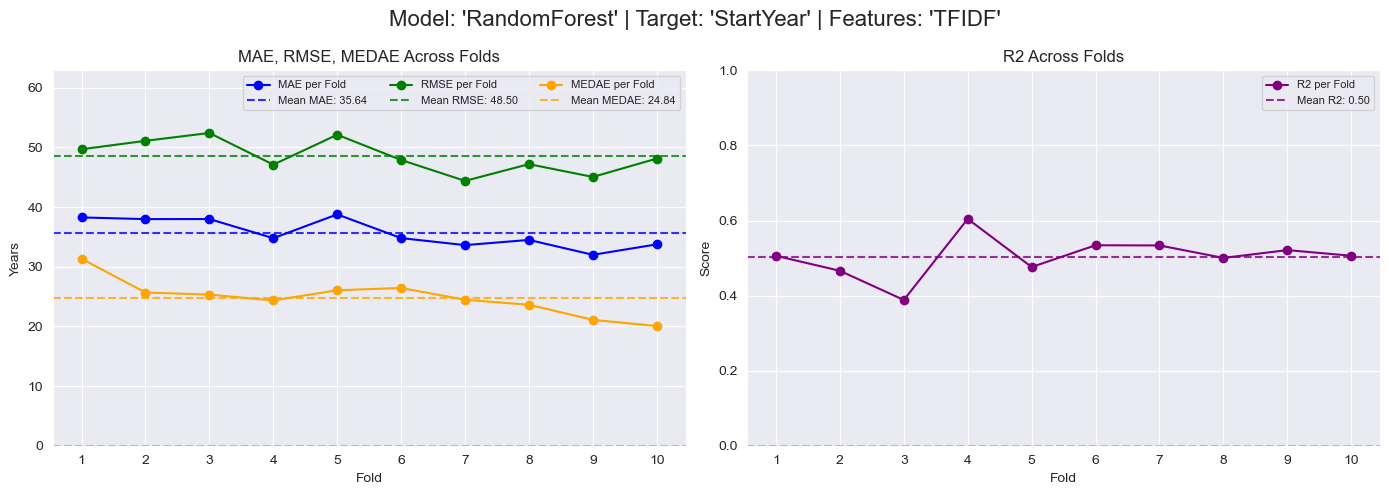

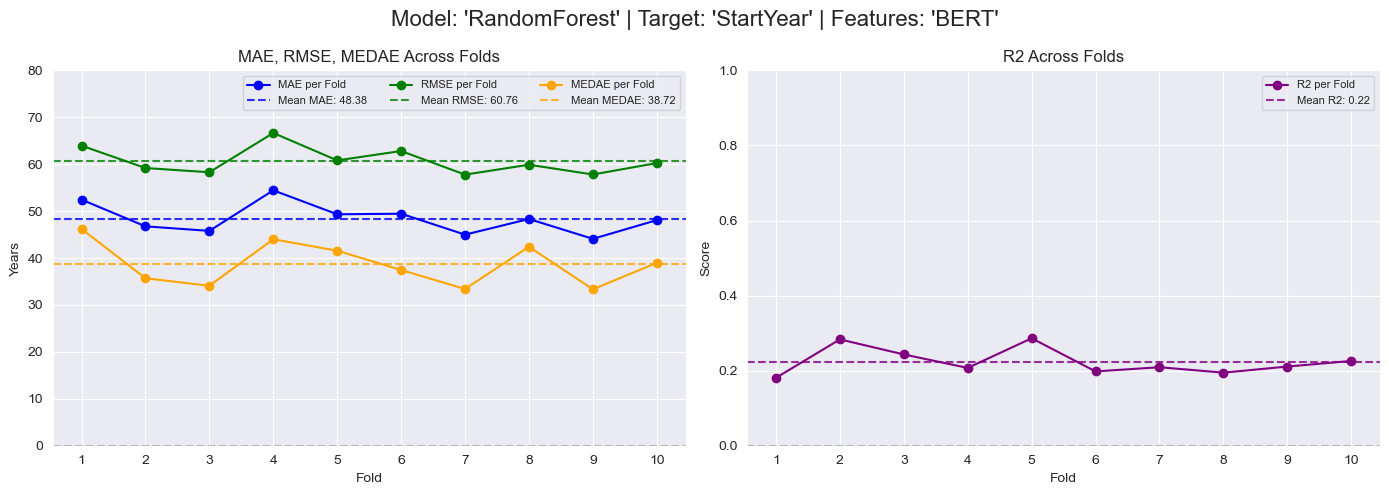

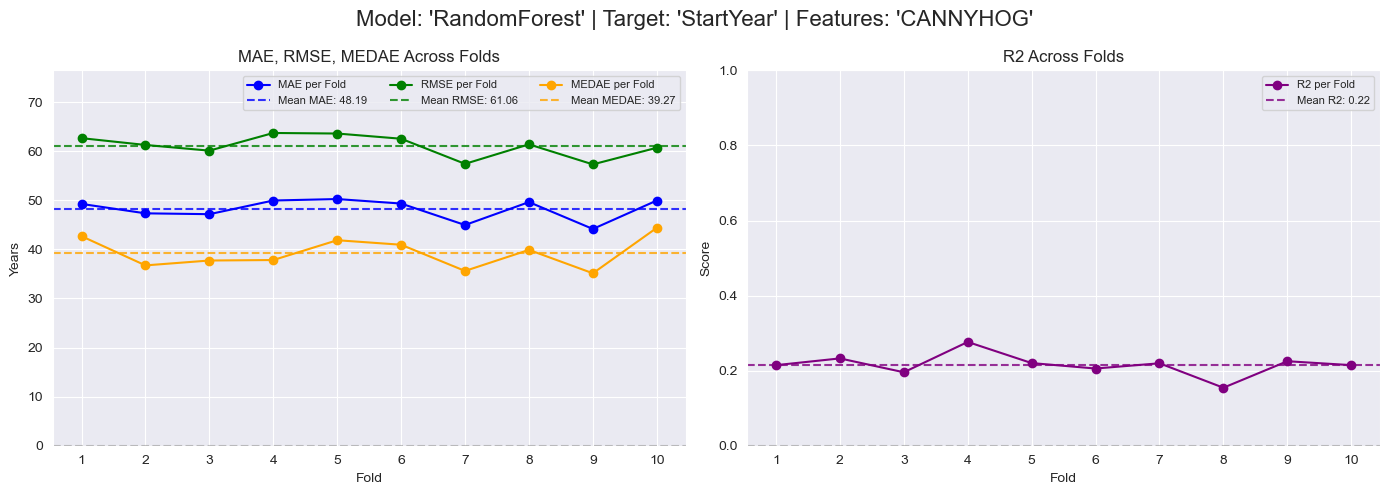

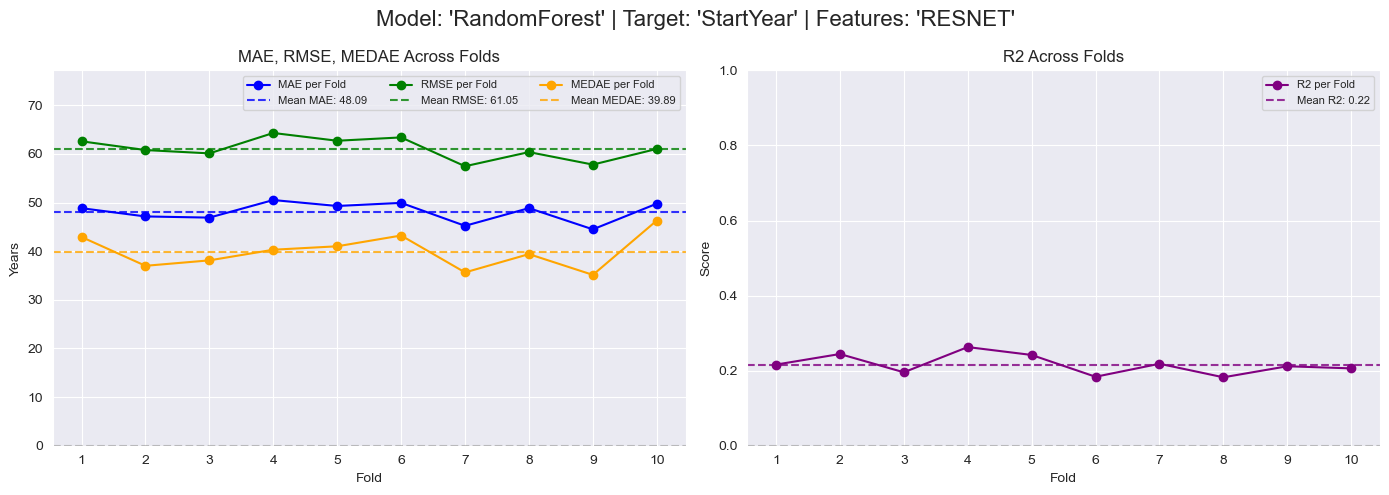

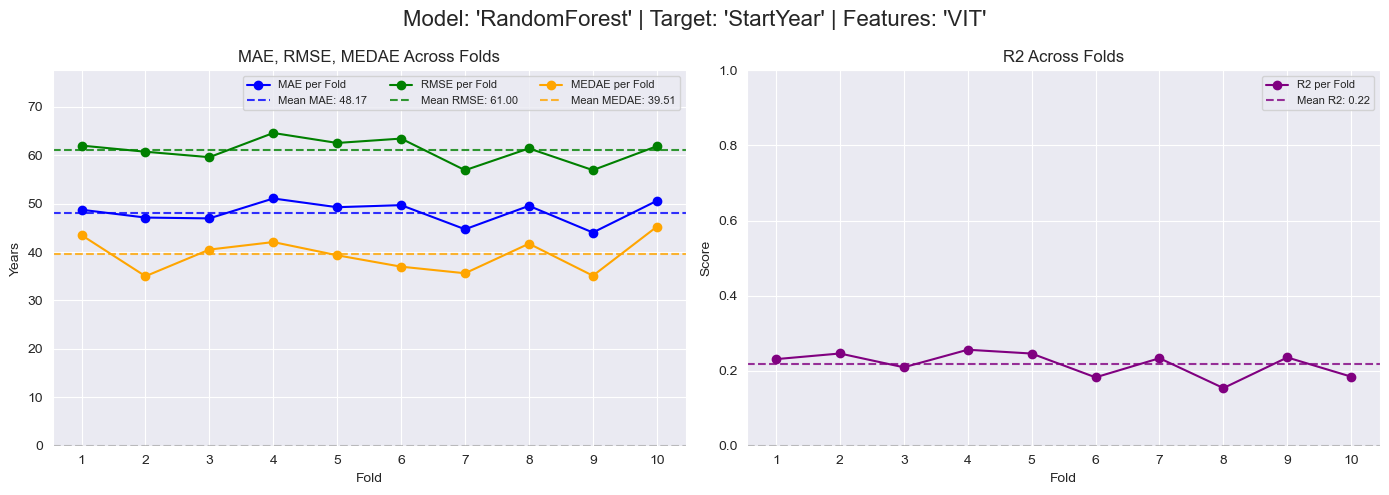

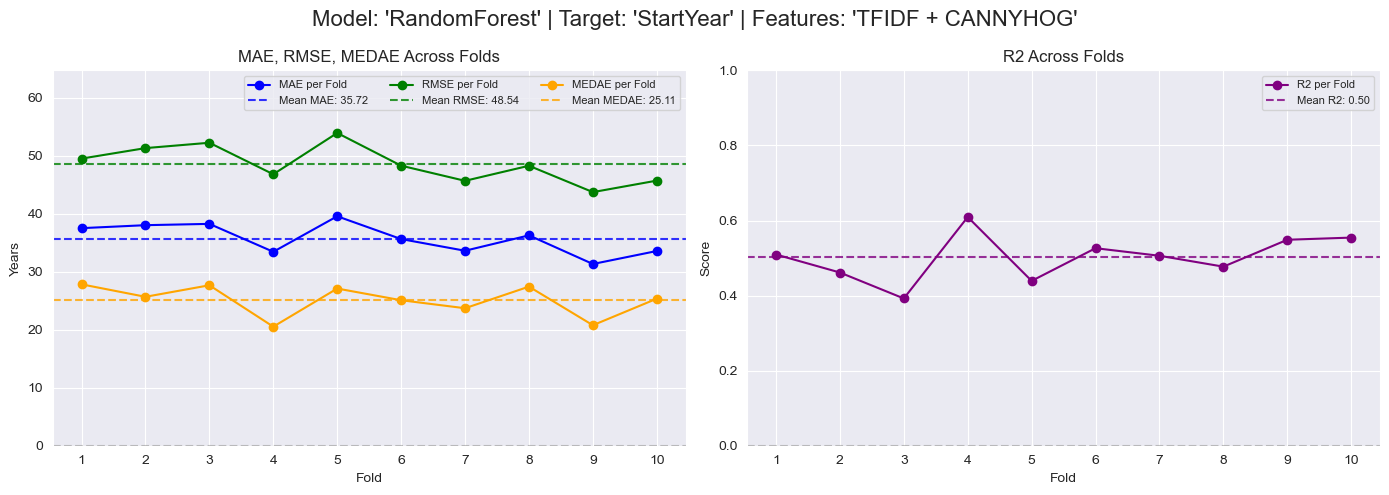

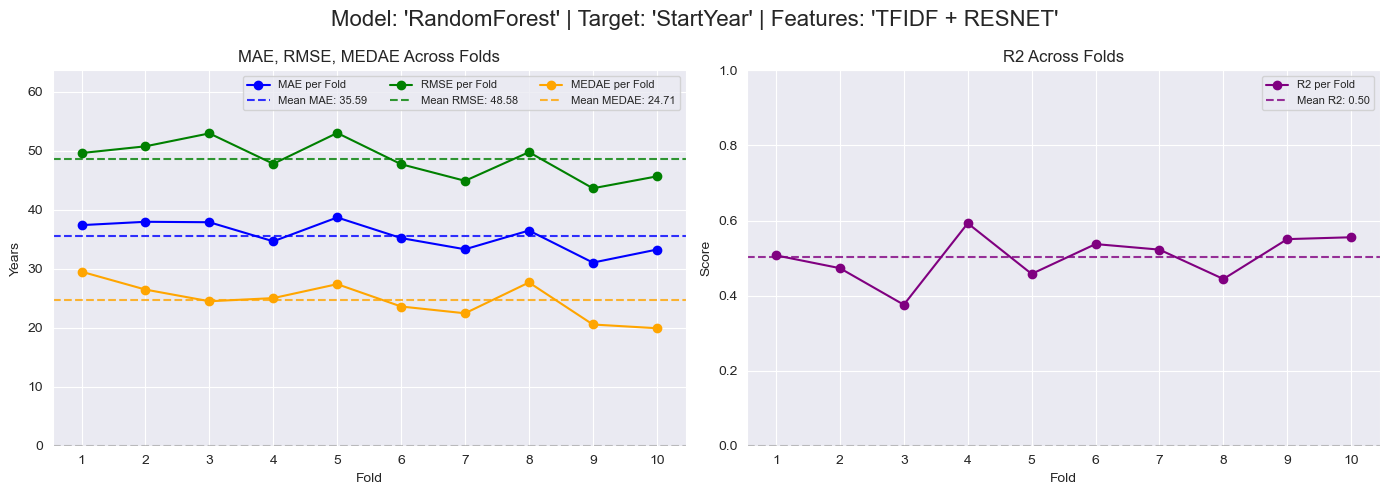

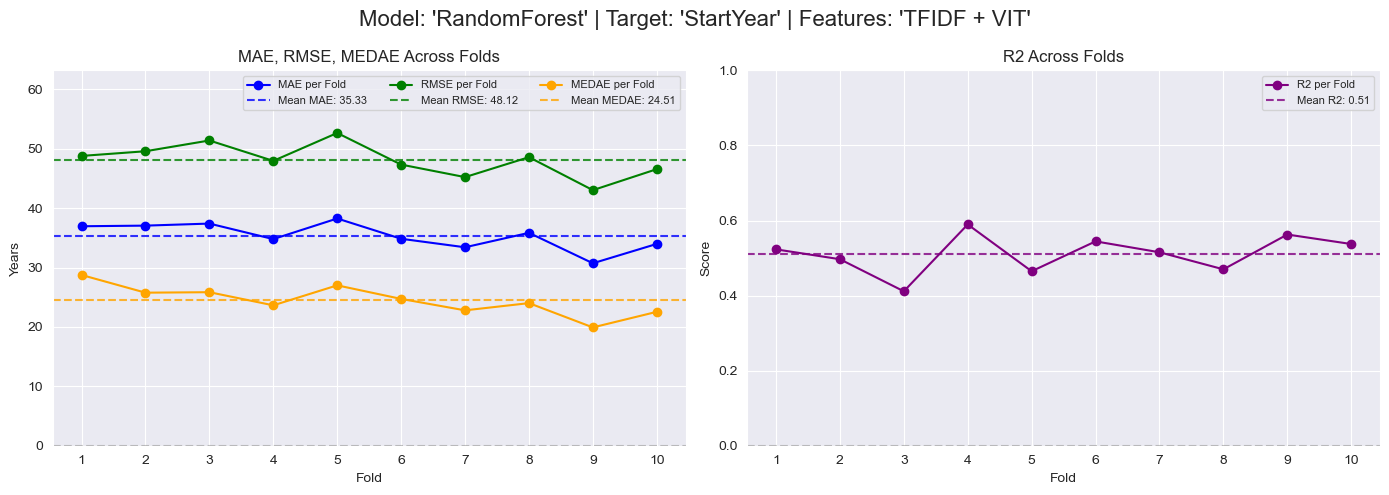

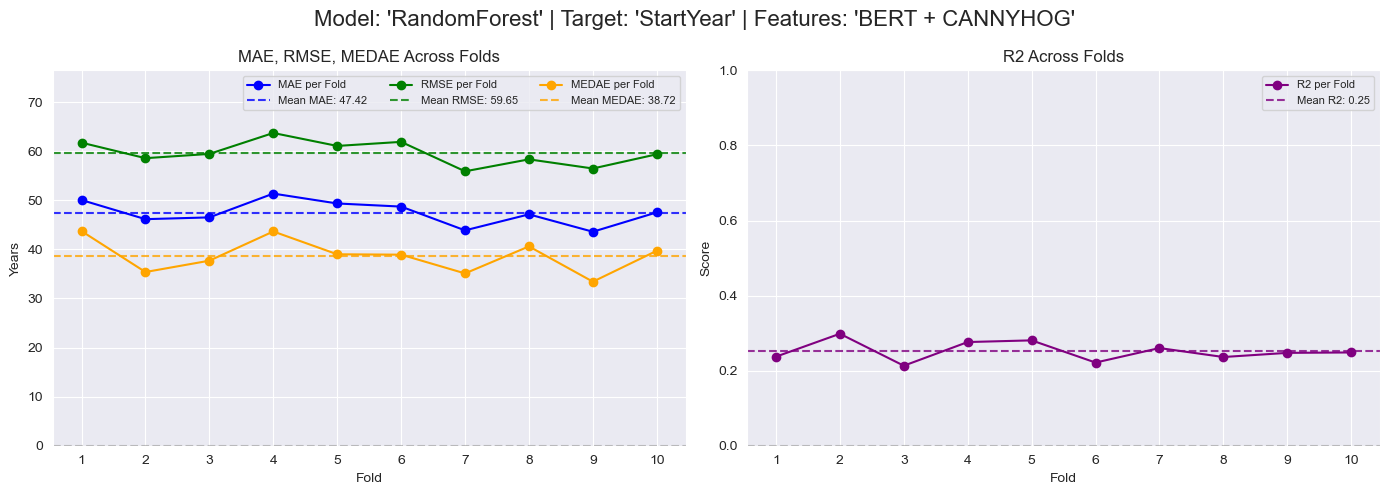

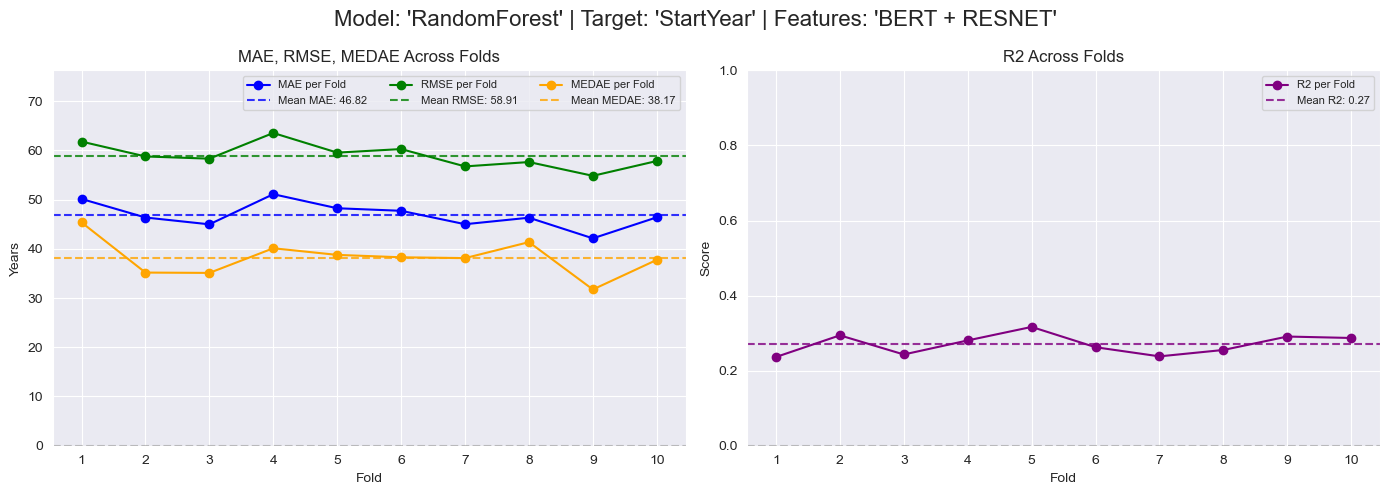

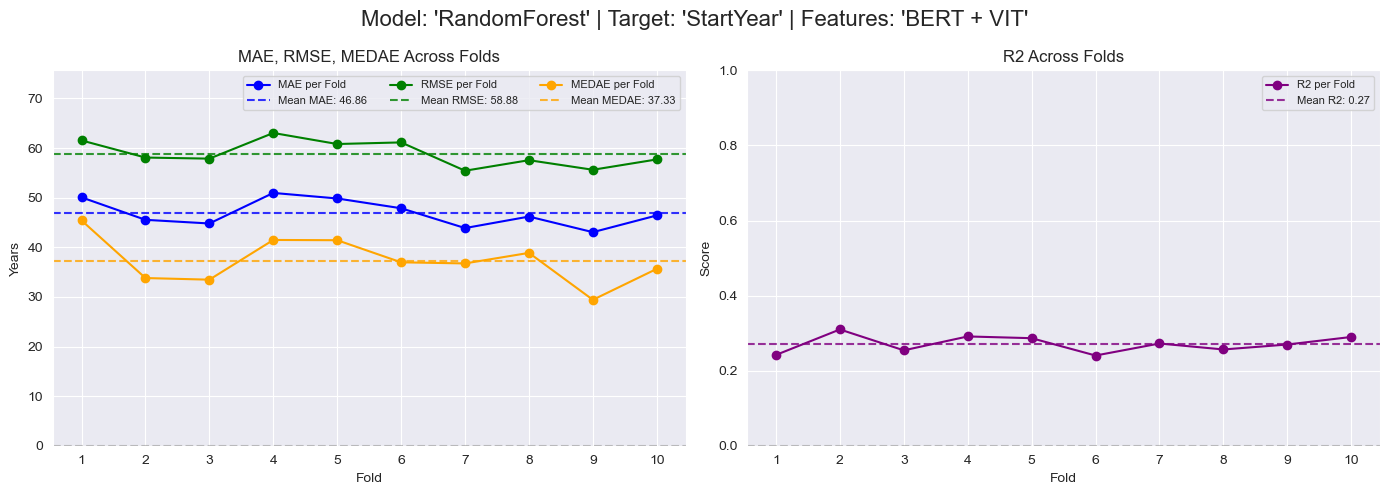

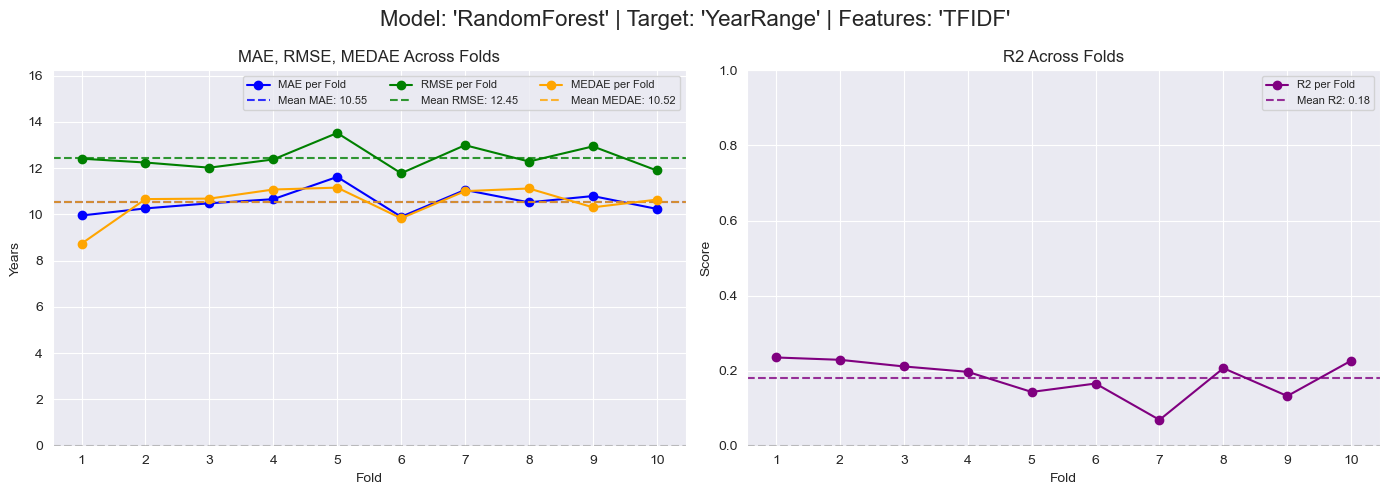

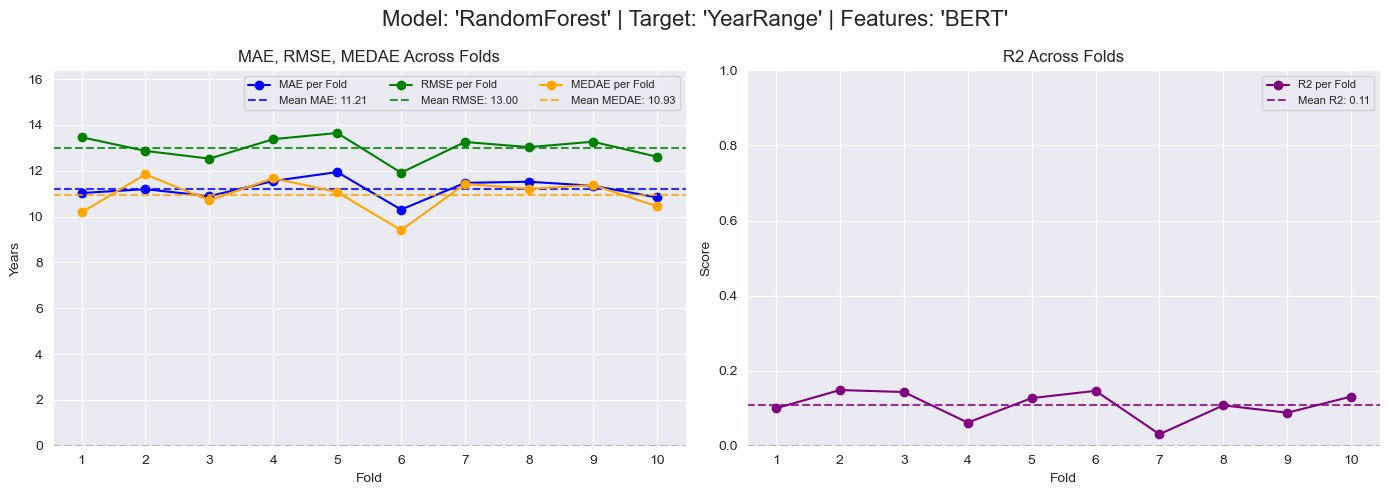

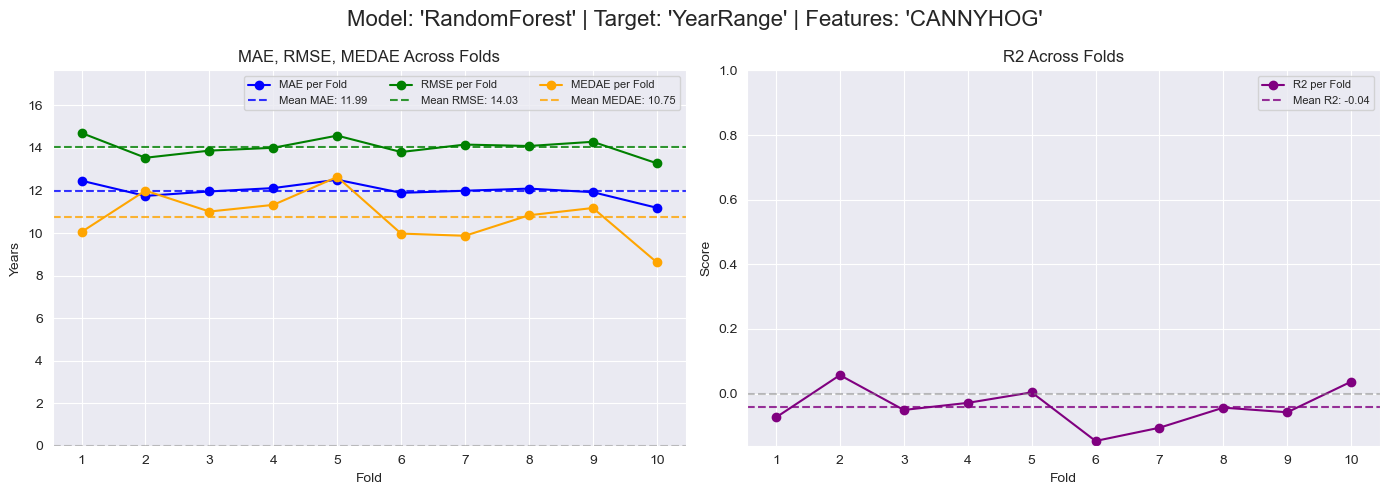

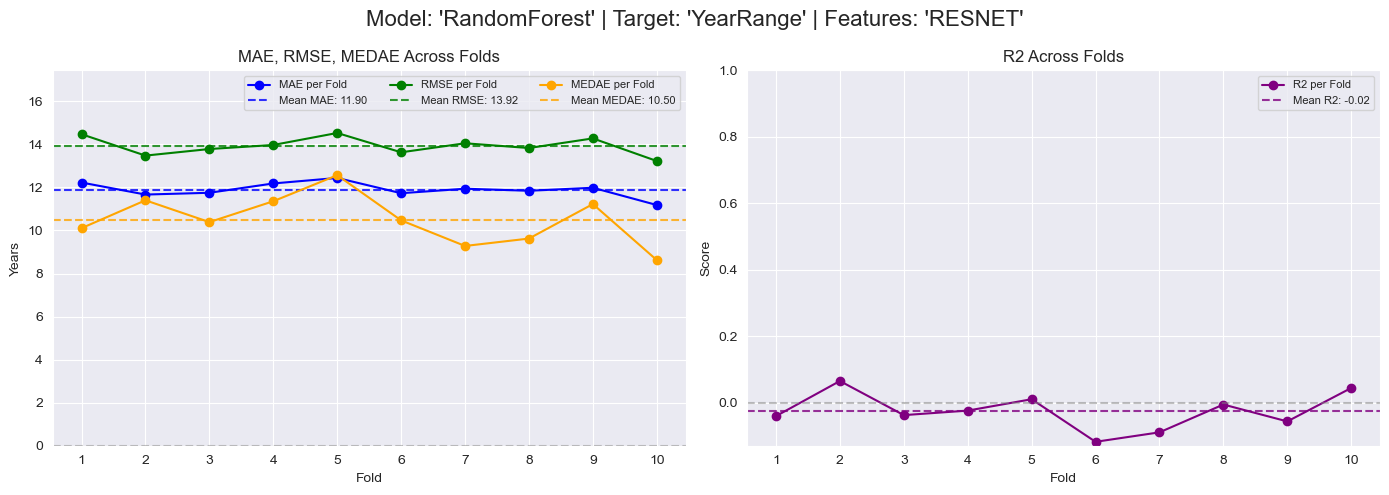

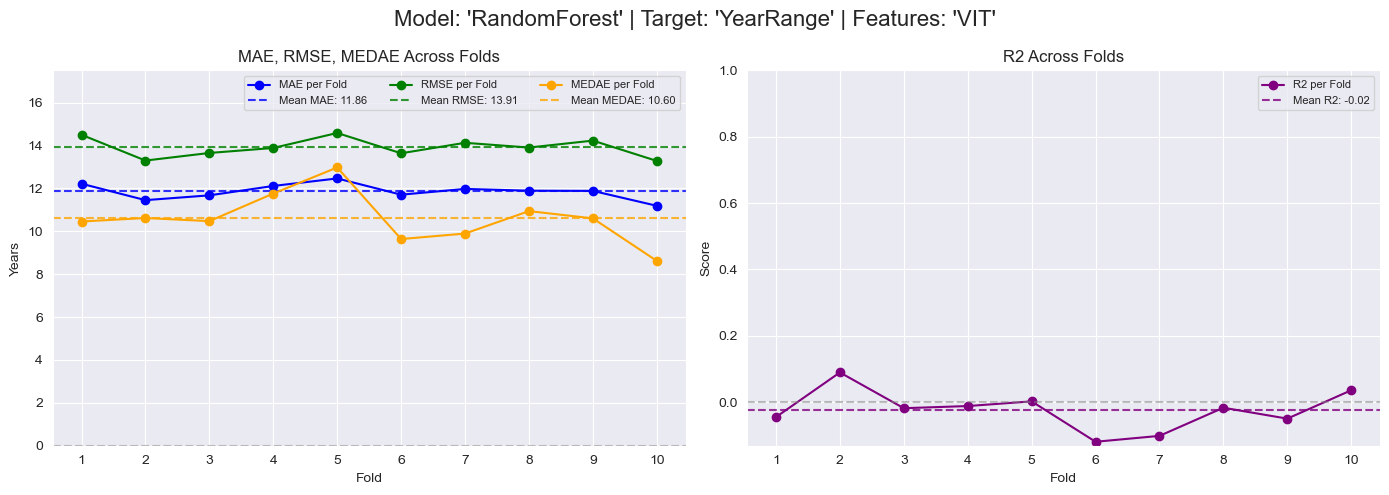

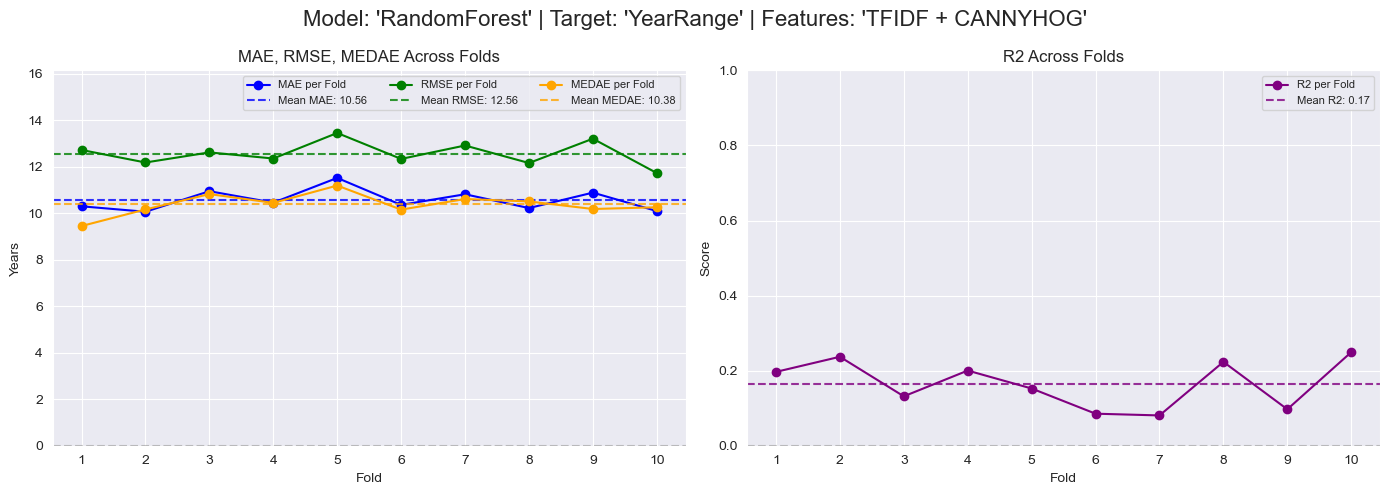

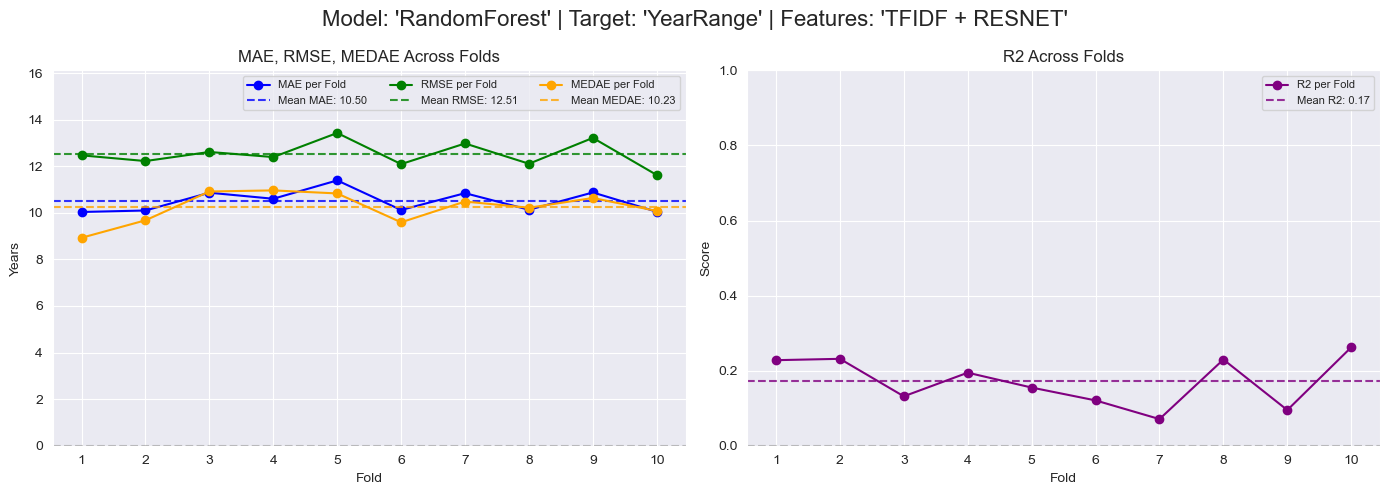

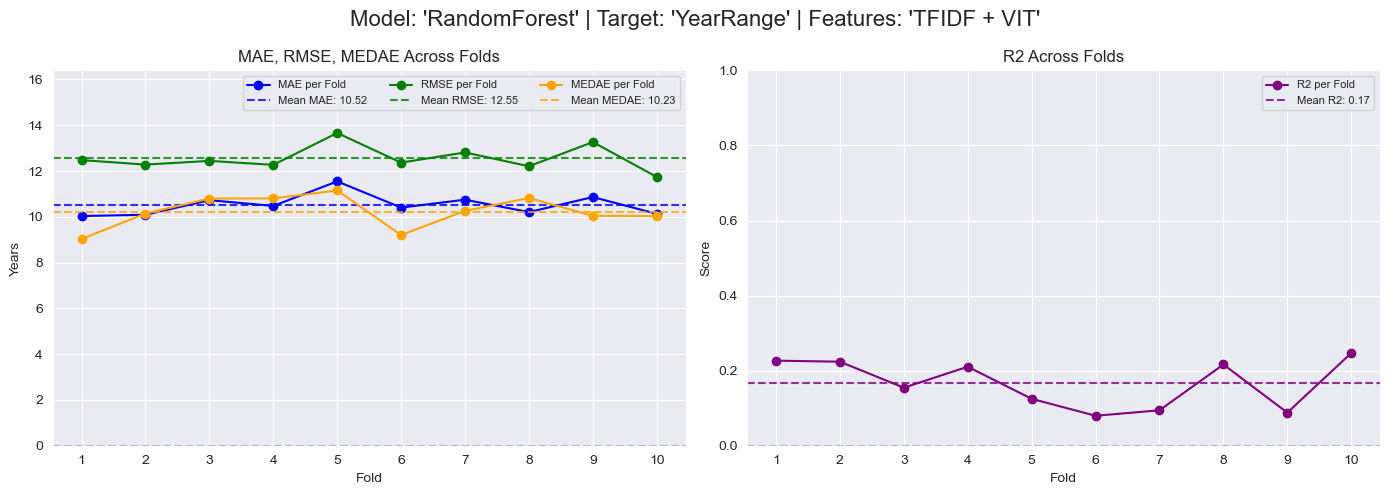

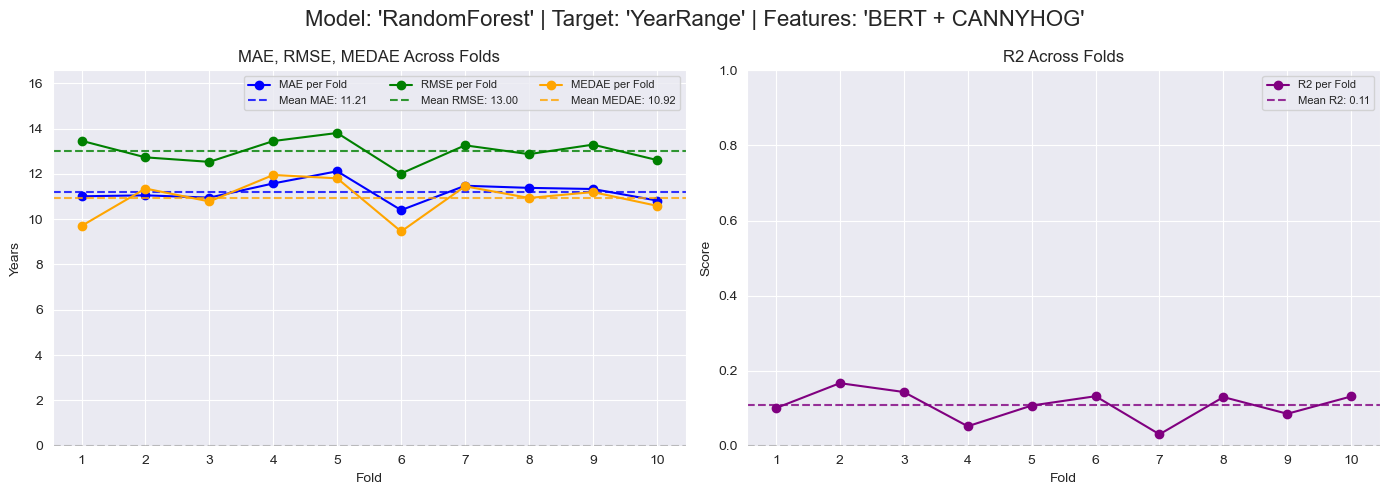

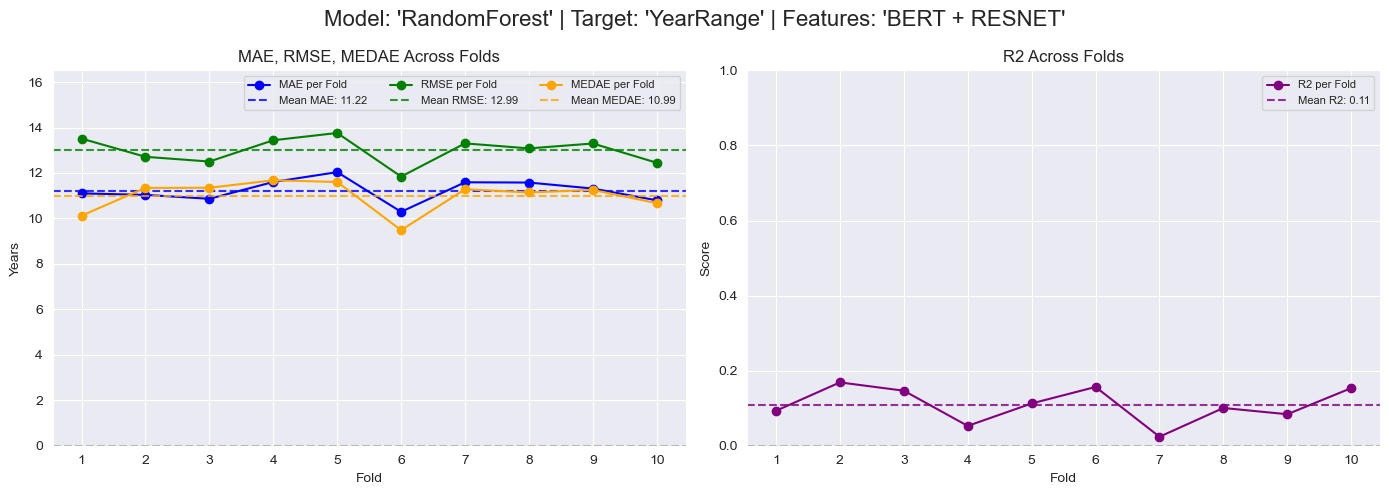

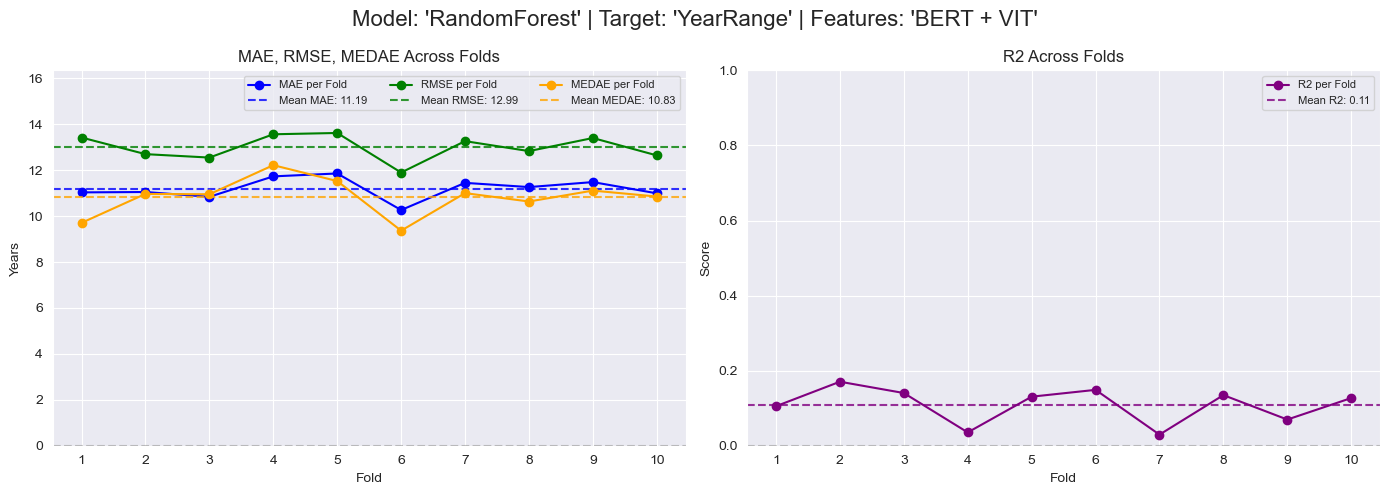

In [105]:
run_cv_all(model_name, model_class, best_params[model_name], X, y)

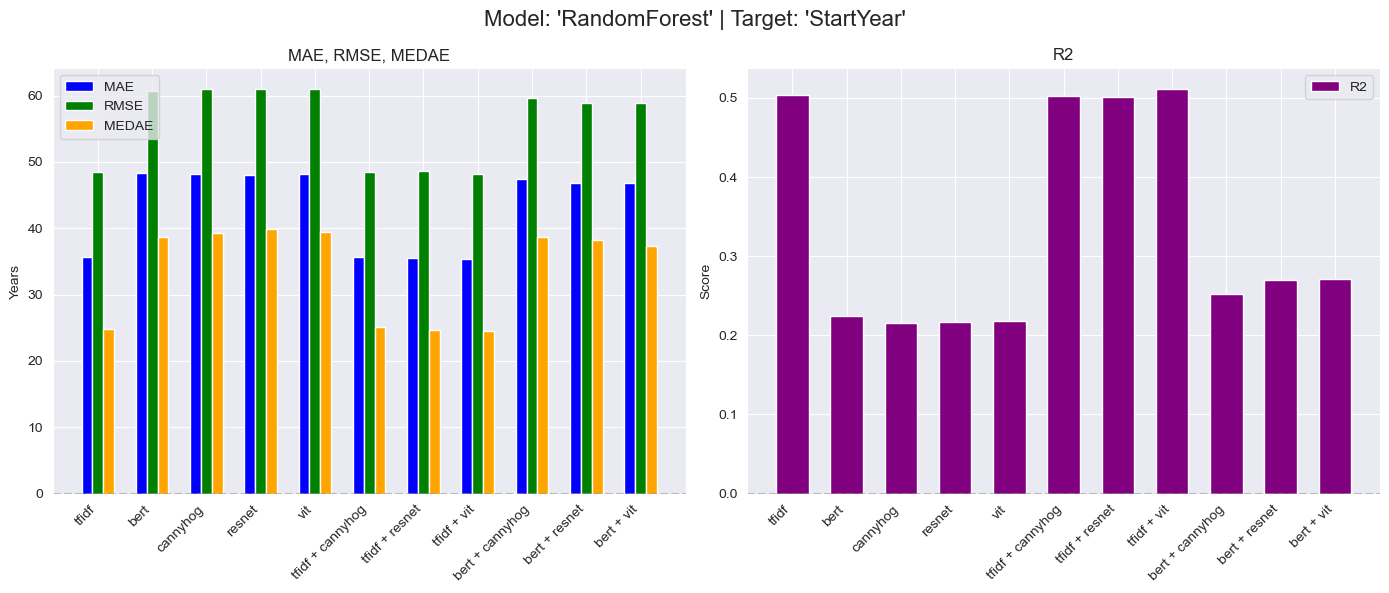

In [107]:
plot_compare_feature_scores(cv_scores, model_name, "StartYear")

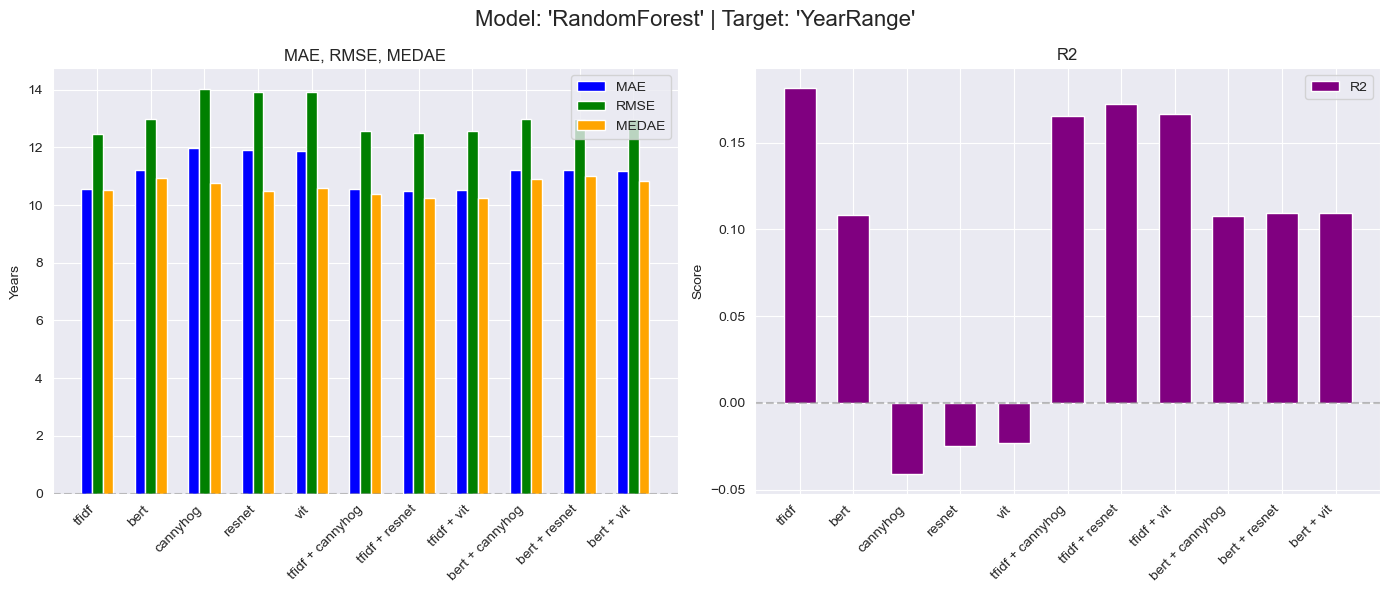

In [108]:
plot_compare_feature_scores(cv_scores, model_name, "YearRange")
